In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


# 서론

![대체 텍스트](https://drive.google.com/uc?export=view&id=1KXm3Fb5bDqlC4HX_yHHasvI4-lHcfSWY)

**<font size = "3">포스트 코로나</font>**  

> 포스트(Post, 이후)와 코로나19의 합성어로, 코로나19 극복 이후 다가올 새로운 시대·상황을 이르는 말

현재 많은 나라에서 코로나로 고통을 받고 있습니다. 물론 대한민국도 예외는 아닙니다.  

마스크는 필수가 되었으며 대학에서는 비대면 강의, 회사에서는 재택근무를 하였습니다.  

많은 스포츠리그 경기는 관중을 받지 않았으며 몇몇 영화는 영화관이 아닌 ott 서비스로 영화를 제공하였습니다.  

또한 몇몇 회사는 파산 위기에 쳐해있으며 해고당하는 직장인이 생기기 시작했습니다.

코로나의 고통이 언제까지 지속될지, 코로나가 끝나더라도 우리가 살아왔던 코로나 이전의 시대와 같은 삶을 살아갈 수 있는지 아무도 모르는 상황입니다.  

그렇기 때문에 <font color = 'red'>**우리는 포스트 코로나 시대를 준비**</font>해야 합니다.  






저희 팀은 포스트 코로나 시대를 준비하기 위해 잡은 **3가지 키워드**는 <font color = 'blue'>**20대**, **비대면**,**군집**</font>입니다.  

이 3가지의 키워드를 토대로 이야기를 풀어나가도록 하겠습니다.  

**<font color = 'blue'> 1. 20대 주목! (cgi 지수와 20대의 연관성)**  
**2. 非대면 트렌드 (카드, 배달 데이터로 본 비대면 사회)**  
**3. 군집분석 (군집으로 보는 소비패턴)</font>**

# 라이브러리 불러오기

In [3]:
# 데이터 처리
import pandas as pd
import numpy as np

# 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
%matplotlib inline
from matplotlib import font_manager, rc
import matplotlib.font_manager as fm

import seaborn as sns

# 스케일링
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
# 차원 축소
from sklearn.manifold import TSNE
# 군집화
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

pd.set_option('max_rows', 999)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Colab 한글 폰트 설정

In [4]:
# 나눔고딕 설치


import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=5)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

# Colab 나눔고딕 설정

plt.rc('font', family='NanumBarunGothic')

# 실행 후에도 한글이 나오지 않는 경우 런타임 다시 시작 후 다시 실행

fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


# 데이터 불러오기

In [5]:
card = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/input/card.csv')
delivery_df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/input/delivery.csv', usecols = ['PROCESS_DT','GOODS_AMOUNT'])
index = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/input/index.csv')
time = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/input/Time.csv')
fpopl = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/input/fpopl.csv', usecols = ['popltn_cascnt','agrde_se_code','base_ymd'])

# 전처리

## Card 전처리

In [6]:
type(pd.to_datetime(card['receipt_dttm'][0], format = '%Y%m%d').day)

int

In [7]:
card['receipt_dttm'] = pd.to_datetime(card['receipt_dttm'], format = '%Y%m%d')

card['year'] = card['receipt_dttm'].apply(lambda x: x.year)
card['month'] = card['receipt_dttm'].apply(lambda x: x.month)
card['day'] = card['receipt_dttm'].apply(lambda x: x.day)

#card['weekday'] = card['receipt_dttm'].apply(lambda x: x.weekday())
card['weeks'] = card['receipt_dttm'].apply(lambda x: x.isocalendar()[1])
#card['adstrd_code'] = card['adstrd_code'].apply(lambda x: str(x)[:-2])
#card = pd.merge(card, adstrd[['adstrd_code','brtc_nm','signgu_nm']], on = 'adstrd_code', how = 'left')

# 매출 건수, 매출 금액에 있는 문자열 데이터 변경
def find_object(x):
  try:
    x = np.int64(x)
  except:
    x = np.NaN

  return x
  
card['selng_cascnt'] = card['selng_cascnt'].apply(lambda x: find_object(x))
card['salamt'] = card['salamt'].apply(lambda x: find_object(x))
card = card.dropna(subset=['selng_cascnt','salamt'], axis = 0).copy()

card_week = card.groupby('weeks')[['selng_cascnt','salamt']].sum().reset_index()
card_month = card.groupby('month')[['selng_cascnt','salamt']].sum().reset_index()
card_month_avg = card.groupby('month')[['selng_cascnt','salamt']].mean().reset_index()
card_month_avg['avg'] = (card.groupby('month')[['selng_cascnt','salamt']].sum()['salamt'] / card.groupby('month')[['selng_cascnt','salamt']].sum()['selng_cascnt']).reset_index()[0]

card_count = card.groupby('mrhst_induty_cl_nm')['selng_cascnt'].sum().sort_values(ascending = False)
card_balance = card.groupby('mrhst_induty_cl_nm')['salamt'].sum().sort_values(ascending = False)

card_net = card.loc[card['mrhst_induty_cl_nm'] == '인터넷P/G']
card_net_df = card_net.groupby('weeks')[['salamt','selng_cascnt']].sum().reset_index()

card_pre = card.loc[card['weeks'] < 9]
card_pos = card.loc[card['weeks'] >= 9]

card_pre_count = (card_pre.groupby('mrhst_induty_cl_nm')['selng_cascnt'].sum() / 2).sort_values(ascending = False)
card_pre_balance = (card_pre.groupby('mrhst_induty_cl_nm')['salamt'].sum() / 2).sort_values(ascending = False)

card_pos_count = (card_pos.groupby('mrhst_induty_cl_nm')['selng_cascnt'].sum() / 4).sort_values(ascending = False)
card_pos_balance = (card_pos.groupby('mrhst_induty_cl_nm')['salamt'].sum() / 4).sort_values(ascending = False)

## Index 전처리

In [8]:
index['period'] = pd.to_datetime(index['period'], format = '%Y%m')
#index.apply(lambda x: pd.to_datetime(str(x['period'])[:4] + '-' + str(x['period'])[4:], format = '%Y-%m'), axis = 1)
index['year'] = index['period'].apply(lambda x: x.year)
index['month'] = index['period'].apply(lambda x: x.month)
index['weekday'] = index['period'].apply(lambda x: x.weekday())
index['weeks'] = index['period'].apply(lambda x: x.isocalendar()[1])

## fpopl 전처리

In [9]:
fpopl['base_ymd'] = pd.to_datetime(fpopl['base_ymd'], format = '%Y%m%d')
#fpopl['base_ymd'] = fpopl['base_ymd'].apply(lambda x: str(x)[:4] + '-' + str(x)[4:6] + '-' + str(x)[6:])
#fpopl['base_ymd'] = fpopl['base_ymd'].apply(lambda x: pd.to_datetime(x, format = '%Y-%m-%d'))
fpopl['weeks'] = fpopl['base_ymd'].apply(lambda x: x.isocalendar()[1])

fpopl_dic = {'age_00':'0s','age_10':'10s', 'age_15':'10s','age_20':'20s', 'age_25':'20s','age_30':'30s','age_35':'30s','age_40':'40s','age_45':'40s','age_50':'50s','age_55':'50s','age_60':'60s','age_65':'60s','age_70':'70s'}
fpopl['agrde_se_code'] = fpopl['agrde_se_code'].map(fpopl_dic)
fpopl_gr = fpopl.groupby('weeks')['popltn_cascnt'].sum()
fpopl_gr = fpopl_gr.reset_index()

## delivery 전처리

In [10]:
delivery_df['PROCESS_DT'] = delivery_df['PROCESS_DT'].apply(lambda x: pd.to_datetime(x, format = '%Y-%m-%d'))
delivery_df['month'] = delivery_df['PROCESS_DT'].apply(lambda x: x.month)
delivery_df['day'] = delivery_df['PROCESS_DT'].apply(lambda x: x.day)
delivery_df['weeks'] = delivery_df['PROCESS_DT'].apply(lambda x: x.isocalendar()[1])

weeks_amount = delivery_df.groupby('weeks')['GOODS_AMOUNT'].sum().reset_index()
weeks_amount = weeks_amount.loc[weeks_amount['weeks'] <= 23]

## time 전처리

In [11]:
time['date'] = time['date'].apply(pd.to_datetime)
time['weeks'] = time['date'].apply(lambda x: x.isocalendar()[1])
time_con = time.groupby('weeks')['confirmed'].max().reset_index()

# 20대 주목! (cgi 지수와 20대의 연관성)

## cgi 지수 확인

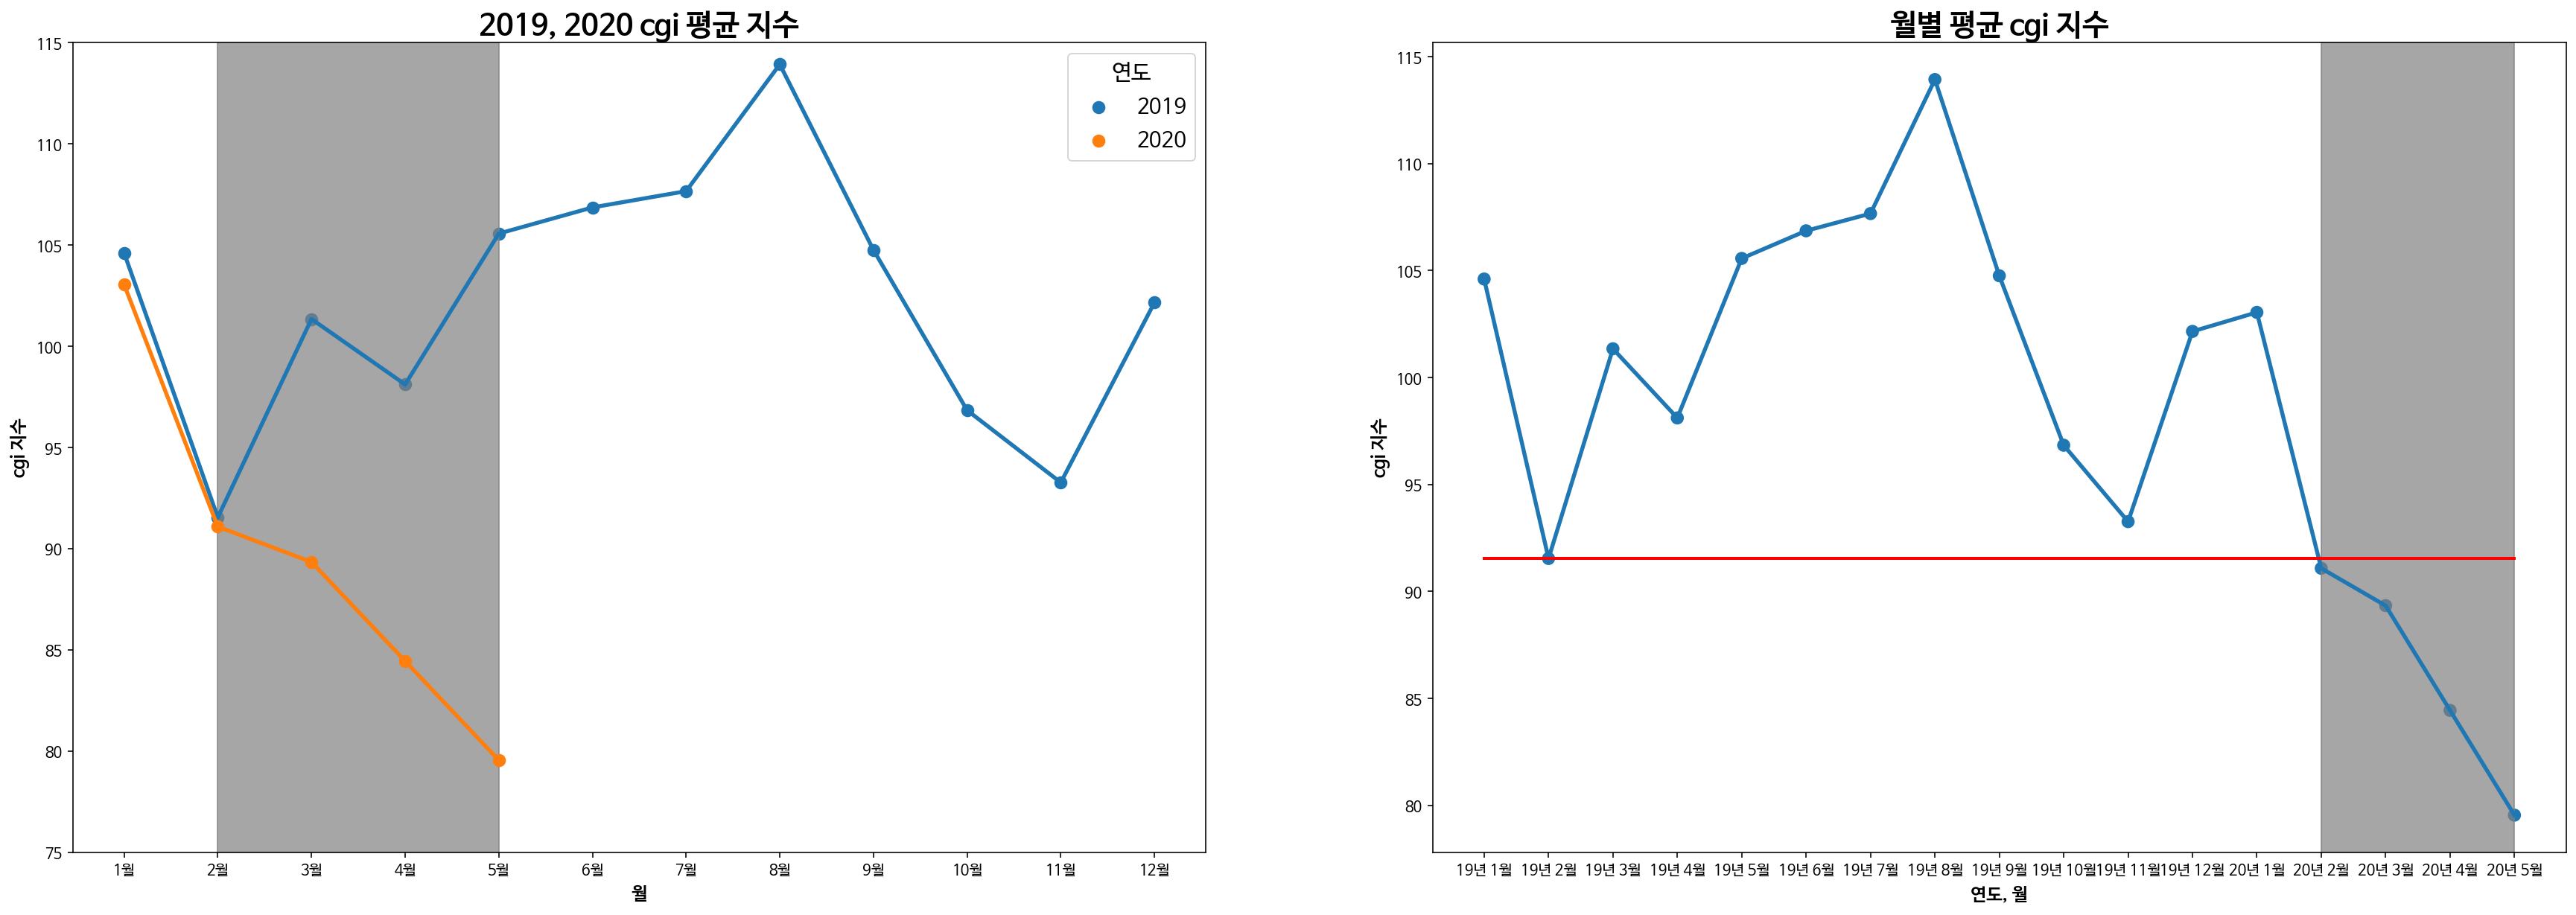

In [12]:
index.loc[index.loc[index['year'] == 2019].index,'month2'] = index.loc[index['year'] == 2019]['month']
index.loc[index.loc[index['year'] == 2020].index,'month2'] = index.loc[index['year'] == 2020]['month'] + 12

fig, ax = plt.subplots(1,2, figsize = (30,10))

sns.pointplot(x = 'month', y = 'cgi', hue = 'year', data = index.groupby(['year','month'])['cgi'].mean().reset_index(), ax = ax[0])
ax[0].set_xticklabels([f'{x}월' for x in np.arange(1,13)])
ax[0].set_title('2019, 2020 cgi 평균 지수', fontsize = 20, fontweight = 'bold')
ax[0].set_xlabel('월', fontsize = 12, fontweight = 'bold')
ax[0].set_ylabel('cgi 지수', fontsize = 12, fontweight = 'bold')
ax[0].set_ylim(75,115)
ax[0].axvspan(1, 4, color='gray', alpha = 0.7)
ax[0].legend(loc = 'upper right', fontsize='x-large', title = '연도', title_fontsize = 15)

sns.pointplot(x = 'month2', y = 'cgi', data = index, ci = False, ax = ax[1])
ax[1].set_xticklabels([f'19년 {x}월' for x in np.arange(1,13)] + [f'20년 {x}월' for x in np.arange(1,6)])
ax[1].set_title('월별 평균 cgi 지수', fontsize = 20, fontweight = 'bold')
ax[1].set_xlabel('연도, 월', fontsize = 12, fontweight = 'bold')
ax[1].set_ylabel('cgi 지수', fontsize = 12, fontweight = 'bold')
ax[1].plot([0,16],[index.loc[index['month2'] == 2]['cgi'].mean(),index.loc[index['month2'] == 2]['cgi'].mean()], color = 'r', linewidth = 2)
ax[1].axvspan(13, 16, color='gray', alpha = 0.7)

fig.show()

> - **cgi : 카테고리성장지수 (2018년 월평균 대비 매출 성장 비율, 100을 기준으로 이상이면 매출 상승, 이하면 하락)**  
- 오른쪽 그래프는 왼쪽 그래프를 2019, 2020년 월별로 재표현 한 그래프

2019, 2020년 모두 1 ~ 2월에 같은 추세를 보였습니다.  
그렇기 때문에 이 당시에는 코로나의 영향이 아직 오지 않은 시기로 생각했습니다.

그러다 2월 이후부터는 다른 경향을 보였습니다.  
2020년에는 cgi 지수가 꾸준히 하락하는 모습을 보였습니다.  
2020년 2월 이후 부터는 2019년 기간 중 cgi 지수가 가장 낮았던 2월 보다도 낮은 cgi 지수를 기록하였습니다.  

<font color = 'red'>**위와 같은 근거로 2월 이후 부터 5월 까지를 코로나로 인한 경제 타격 시점이라고 예상하였습니다.**</font>

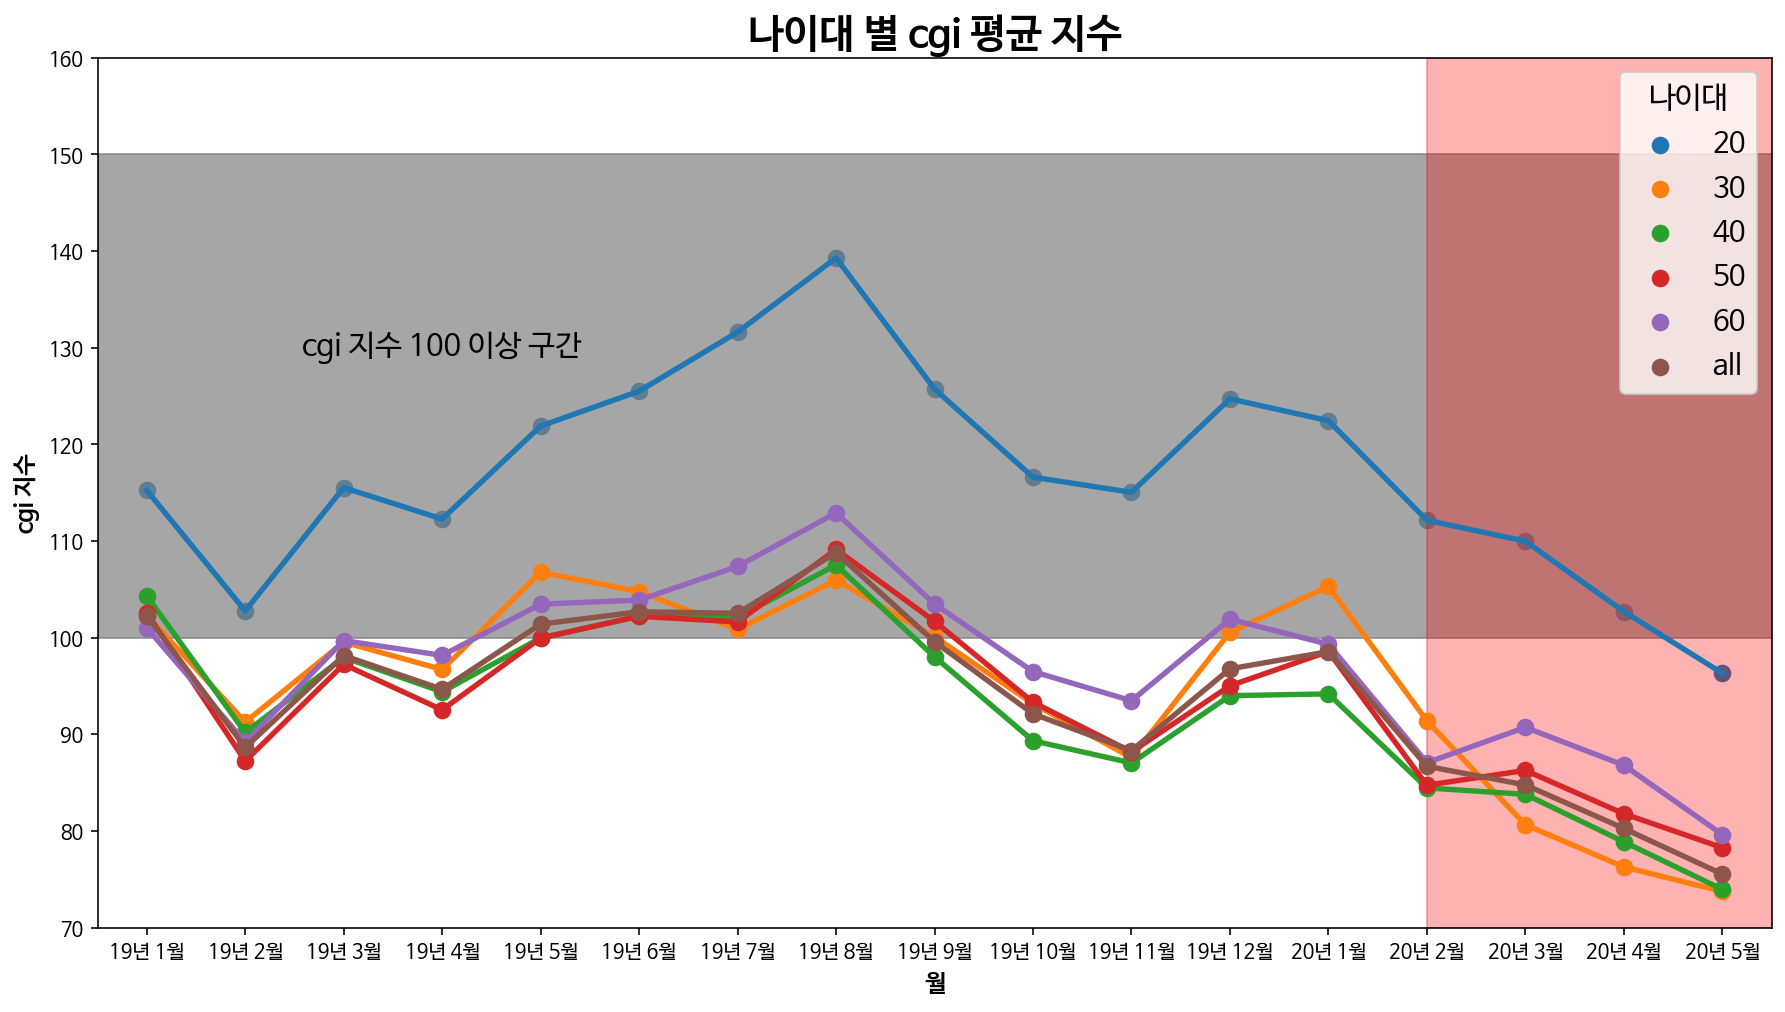

In [13]:
index_age = index.groupby(['age','month2'])['cgi'].mean().reset_index()

fig = plt.figure(figsize = (15,8))
ax = sns.pointplot(x = 'month2', y = 'cgi', hue = 'age', data = index_age)
plt.xticks(np.arange(0,17),[f'19년 {x}월' for x in np.arange(1,13)] + [f'20년 {x}월' for x in np.arange(1,6)])
plt.title('나이대 별 cgi 평균 지수', fontsize = 20, fontweight = 'bold')
plt.xlabel('월', fontsize = 12, fontweight = 'bold')
plt.ylabel('cgi 지수', fontsize = 12, fontweight = 'bold')
ax.annotate('cgi 지수 100 이상 구간', xy = (3, 130), xytext = (3, 130), va = 'center', ha = 'center', fontsize = 15)
plt.legend(loc = 'upper right',  fontsize='x-large', title = '나이대', title_fontsize = 15)
plt.axhspan(100, 150, color='gray', alpha = 0.7)
plt.xlim(-0.5,16.5)
plt.ylim(70,160)
plt.axvspan(13, 17, color='red', alpha = 0.3)

fig.show()

> - **cgi : 카테고리성장지수 (2018년 월평균 대비 매출 성장 비율, 100을 기준으로 이상이면 매출 상승, 이하면 하락)**  



<font color = 'blue'>**20대**</font>의 경우 2020년 **5월을 제외하고는 모두 cgi 수치가 100을 넘었습니다**.  


또한 **<font color = 'blue'>20대</font>가 가장 높은 cgi 지수를 기록**하였습니다.  

다른 나이대는 cgi 지수가 주로 100 근처에 있었는데 <font color = 'red'>**2020년 3월 부터는 확실히 하락세**</font>를 보였습니다.

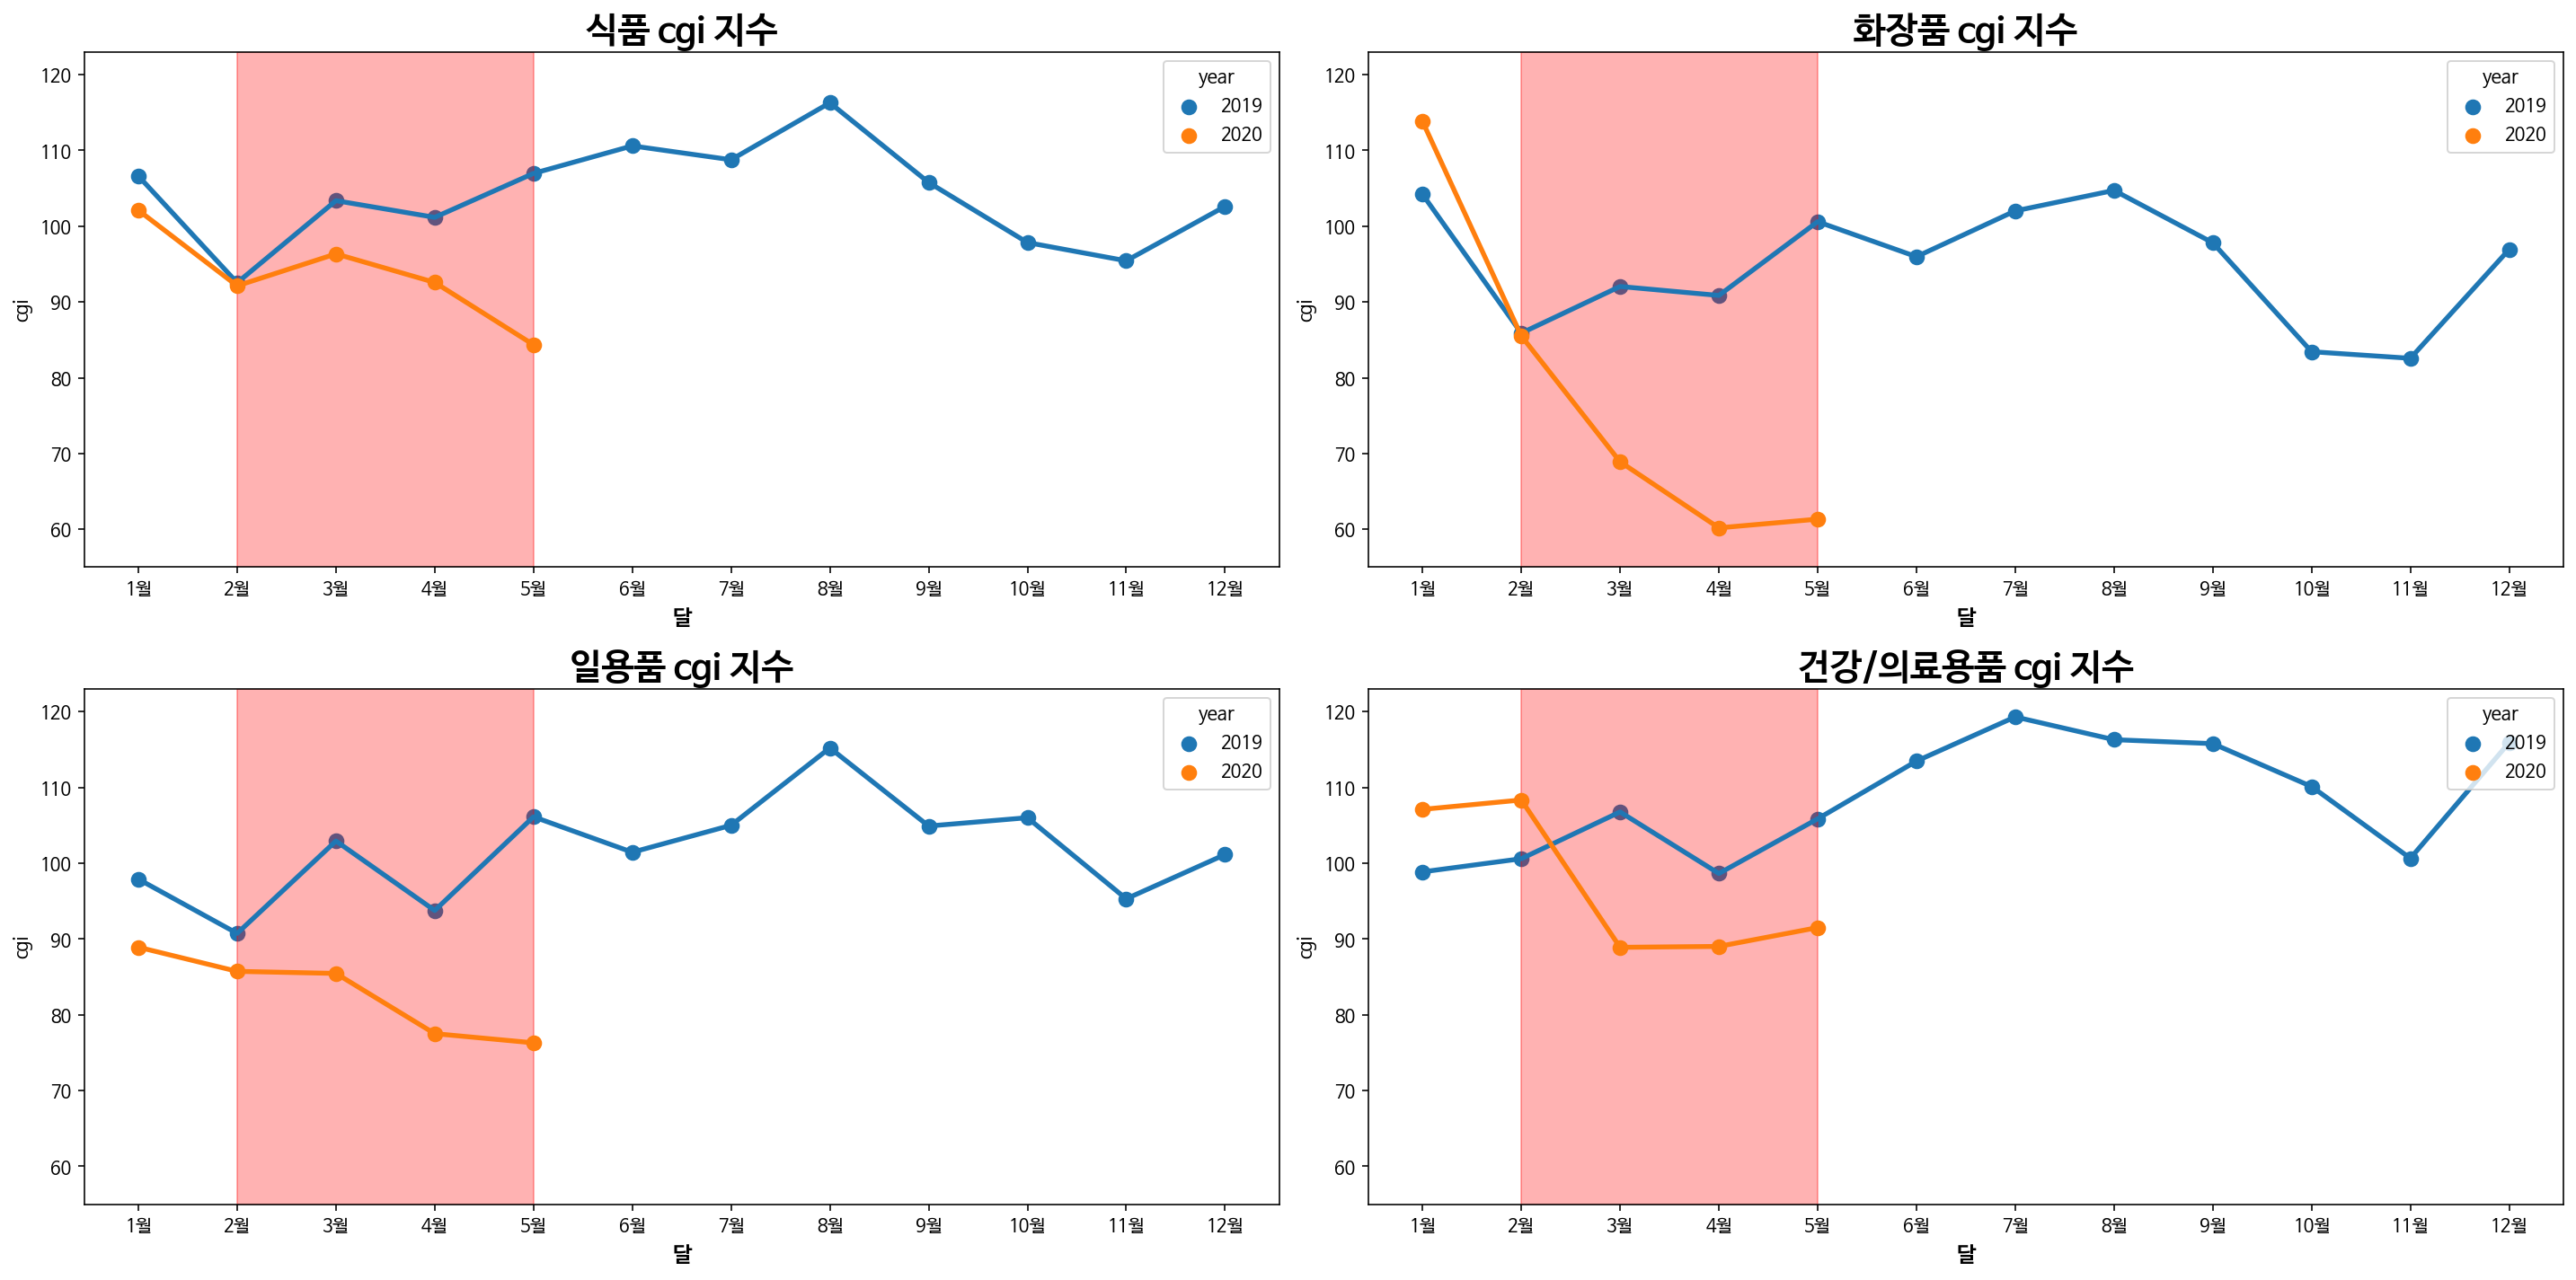

In [14]:
fig, ax = plt.subplots(2,2,figsize = (20,10))
sns.pointplot(x = 'month', y = 'cgi', hue = 'year', data = index.loc[index['catl'] == '식품'], ax = ax[0,0], ci = False)
ax[0,0].set_title('식품 cgi 지수', fontsize = 20, fontweight = 'bold')
ax[0,0].set_xticklabels([f'{x}월' for x in np.arange(1,13)])
ax[0,0].set_xlabel('달', fontsize = 12, fontweight = 'bold')
ax[0,0].axvspan(1, 4, color='red', alpha = 0.3)
ax[0,0].set_ylim(55,123)

sns.pointplot(x = 'month', y = 'cgi', hue = 'year', data = index.loc[index['catl'] == '화장품'], ax = ax[0,1], ci = False)
ax[0,1].set_title('화장품 cgi 지수', fontsize = 20, fontweight = 'bold')
ax[0,1].set_xticklabels([f'{x}월' for x in np.arange(1,13)])
ax[0,1].set_xlabel('달', fontsize = 12, fontweight = 'bold')
ax[0,1].axvspan(1, 4, color='red', alpha = 0.3)
ax[0,1].set_ylim(55,123)

sns.pointplot(x = 'month', y = 'cgi', hue = 'year', data = index.loc[index['catl'] == '일용품'], ax = ax[1,0], ci = False)
ax[1,0].set_title('일용품 cgi 지수', fontsize = 20, fontweight = 'bold')
ax[1,0].set_xticklabels([f'{x}월' for x in np.arange(1,13)])
ax[1,0].set_xlabel('달', fontsize = 12, fontweight = 'bold')
ax[1,0].axvspan(1, 4, color='red', alpha = 0.3)
ax[1,0].set_ylim(55,123)

sns.pointplot(x = 'month', y = 'cgi', hue = 'year', data = index.loc[index['catl'] == '건강/의료용품'], ax = ax[1,1], ci = False)
ax[1,1].set_title('건강/의료용품 cgi 지수', fontsize = 20, fontweight = 'bold')
ax[1,1].set_xticklabels([f'{x}월' for x in np.arange(1,13)])
ax[1,1].set_xlabel('달', fontsize = 12, fontweight = 'bold')
ax[1,1].axvspan(1, 4, color='red', alpha = 0.3)
ax[1,1].set_ylim(55,123)
ax[1,1].legend(loc = 'upper right', title = 'year', title_fontsize = 10)

plt.tight_layout()
fig.show()

**2020년 2월 이후로는 cgi 지수가 모든 카테고리에서 떨어졌습니다.**  
특히 **<font color = 'red'>화장품의 하향세</font>가 눈에 띄는 모습이였습니다.**  

건강/의료용품의 경우 오히려 2020년 1월, 2월에 2019년 1월, 2월보다 더 높은 수치를 기록하였습니다.  
식품, 일용품의 경우 2020년 1월, 2월 부터도 2019년 보다 같거나 더 낮은 cgi 지수를 보였습니다.

In [15]:
index_cgi = index.groupby(['year','month','catl'])['cgi'].mean().reset_index()
index_cgi_19 = index_cgi.loc[(index_cgi['month'] <= 5)&(index_cgi['year'] == 2019)][['month','catl','cgi']]
index_cgi_19.columns = ['month','catl','cgi_19']
index_cgi_20 = index_cgi.loc[(index_cgi['month'] <= 5)&(index_cgi['year'] == 2020)].reset_index()[['month','catl','cgi']]
index_cgi_20.columns  = ['month','catl','cgi_20']
index_df = pd.merge(index_cgi_19, index_cgi_20, how='left')
index_df['cgi_nus'] = index_df.apply(lambda x: x['cgi_20'] - x['cgi_19'], axis = 1)

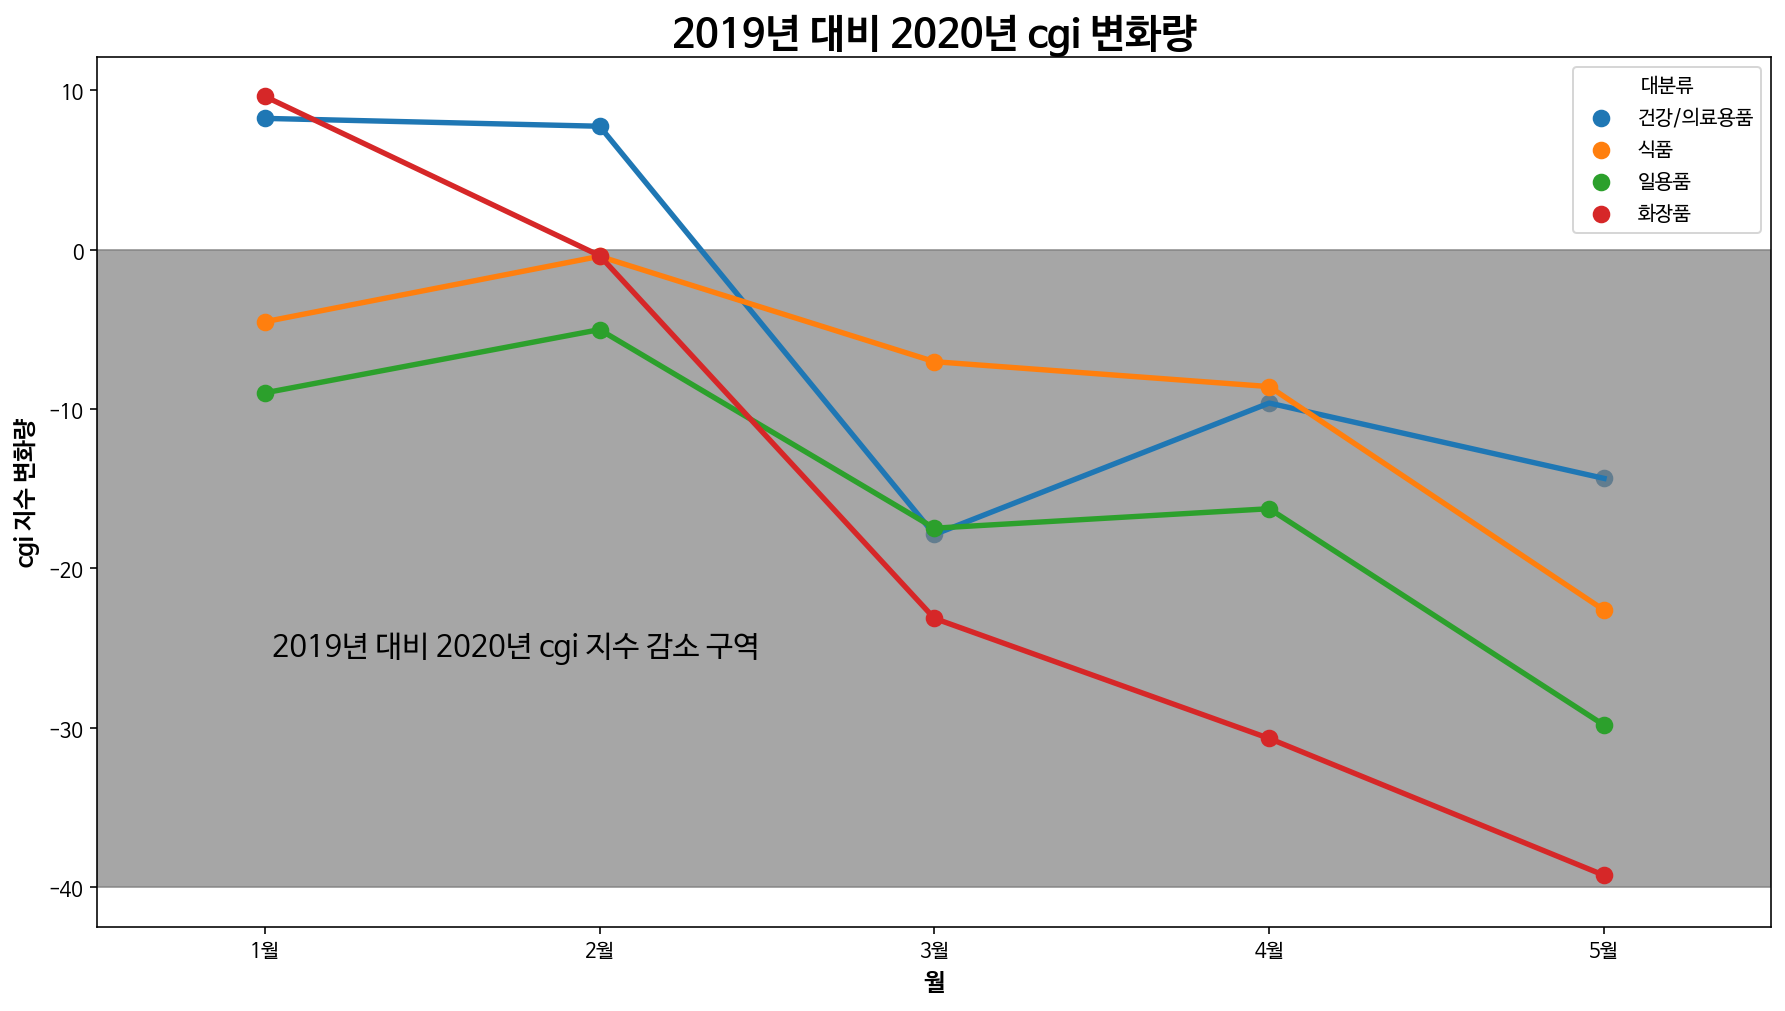

In [16]:
fig = plt.figure(figsize = (15,8))
ax = sns.pointplot(x = 'month', y = 'cgi_nus', data = index_df, hue = 'catl')
plt.xticks(np.arange(0,5),[f'{x}월' for x in np.arange(1,6)])
plt.title('2019년 대비 2020년 cgi 변화량', fontsize = 20, fontweight = 'bold')
plt.xlabel('월', fontsize = 12, fontweight = 'bold')
plt.ylabel('cgi 지수 변화량', fontsize = 12, fontweight = 'bold')
ax.legend(loc = 'upper right',title = '대분류', title_fontsize = 10)
plt.axhspan(0, -40, color='gray', alpha = 0.7)
plt.annotate('2019년 대비 2020년 cgi 지수 감소 구역', xy = (0.75, -25), xytext = (0.75, -25), va = 'center', ha = 'center', fontsize = 15)
plt.show()

> - **cgi 변화량 : 2019년과 2020년을 비교하기 위해 2020년 월별 cgi 평균 지수를 2019년 월별 cgi 평균 지수를 뺐다.**  
- **cgi 변화량 0 초과 : 2019년에 비해 2020년에 cgi 지수가 높음.**  
- **cgi 변화량 0 미만 : 2019년에 비해 2020년에 cgi 지수가 낮음.**

**<font color  = 'red'>2월 이후(3월) 부터 모든 대분류에서 cgi의 변화량이 감소</font>하였습니다.**  
4가지 카테고리 중 **화장품의 하락이 가장 컸습니다.**  

건강/의료용품은 코로나 경제 타격 예상 지점인 3월부터 cgi 변화량이 0 미만의 값을 기록하였으며 또한 증가와 감소 모두 보였습니다.

**<font color = 'red'>식품의 변화폭이 가장 적어보입니다.</font>**

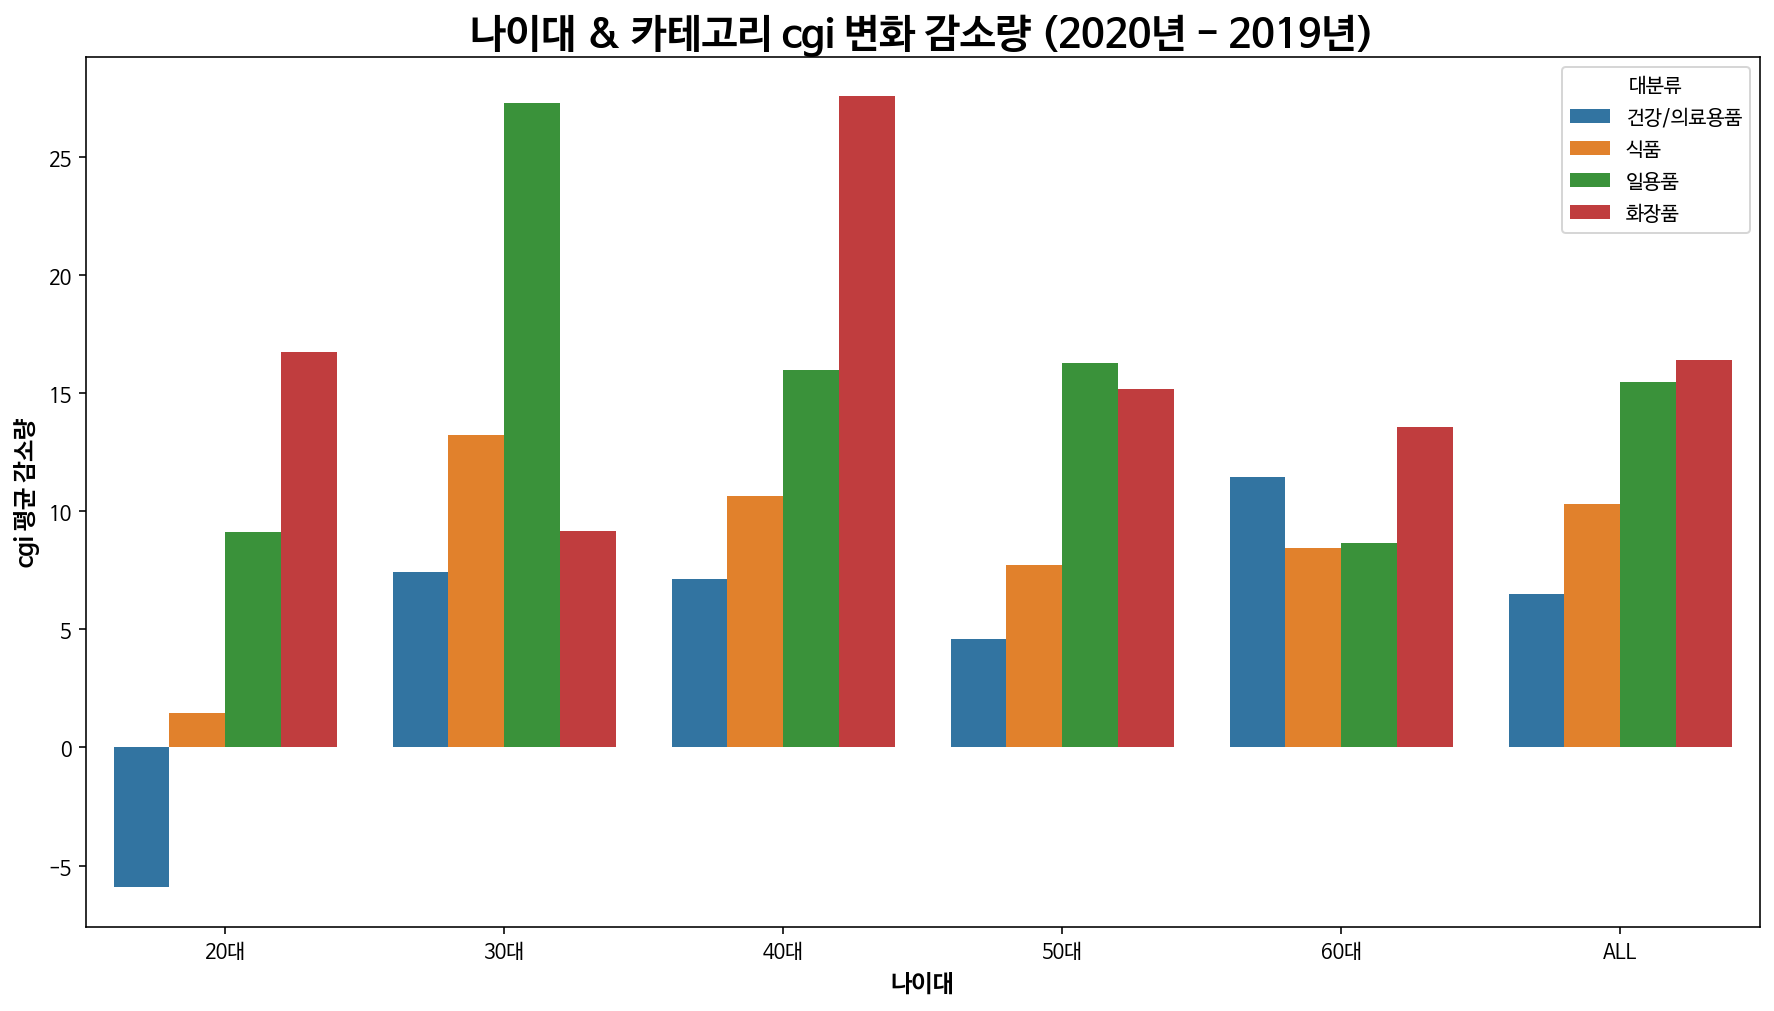

In [17]:
index_age_cgi = index.loc[index['month'] <= 5].groupby(['age','catl'])['cgi'].mean().reset_index()
index_age_cgi['cgi_nus'] = index.loc[(index['month'] <= 5)&(index['year'] == 2019)].groupby(['age','catl','year'])['cgi'].mean().reset_index()['cgi'] - index.loc[(index['month'] <= 5)&(index['year'] == 2020)].groupby(['age','catl','year'])['cgi'].mean().reset_index()['cgi']

fig = plt.figure(figsize = (15,8))
ax = sns.barplot(x = 'age', y = 'cgi_nus' ,hue = 'catl', data = index_age_cgi)
plt.title('나이대 & 카테고리 cgi 변화 감소량 (2020년 - 2019년)', fontsize = 20, fontweight = 'bold')
plt.xticks(np.arange(0,6), ['20대','30대','40대','50대','60대','ALL'])
plt.xlabel('나이대', fontsize = 12, fontweight = 'bold')
plt.ylabel('cgi 평균 감소량', fontsize = 12, fontweight = 'bold')
ax.legend(loc = 'upper right',title = '대분류', title_fontsize = 10)

fig.show()

> - **cgi 변화 감소량 : 2019년과 2020년을 비교하기 위해 2020년 나이대 별 cgi 평균 지수를 2019년 바이대 별 cgi 평균 지수를 뺐다.**  
- **cgi 변화량 0 초과 : 2019년에 비해 2020년에 cgi 지수가 감소.**  
- **cgi 변화량 0 미만 : 2019년에 비해 2020년에 cgi 지수가 증가.**


**<font color = 'red'>가장 눈에 띄는 것은 20대였습니다.</font>**  
**<font color = 'blue'>20대</font>는 유일하게 음의 cgi 변화량, 즉 평균 cgi 지수에서 2019년도 대비 증가를 보였습니다.**  

**이러한 증가를 보인 것은 건강/의료용품이었습니다.**    

**<font color = 'blue'>20대</font>의 식품의 경우 위 그래프에서 감소한 cgi 변화량 중 가장 낮은 감소량을 보였다.**

그 외에도 30대에서 일용품, 40대 화장품 감소가 비교적 눈에 띄었습니다.

### 화장품

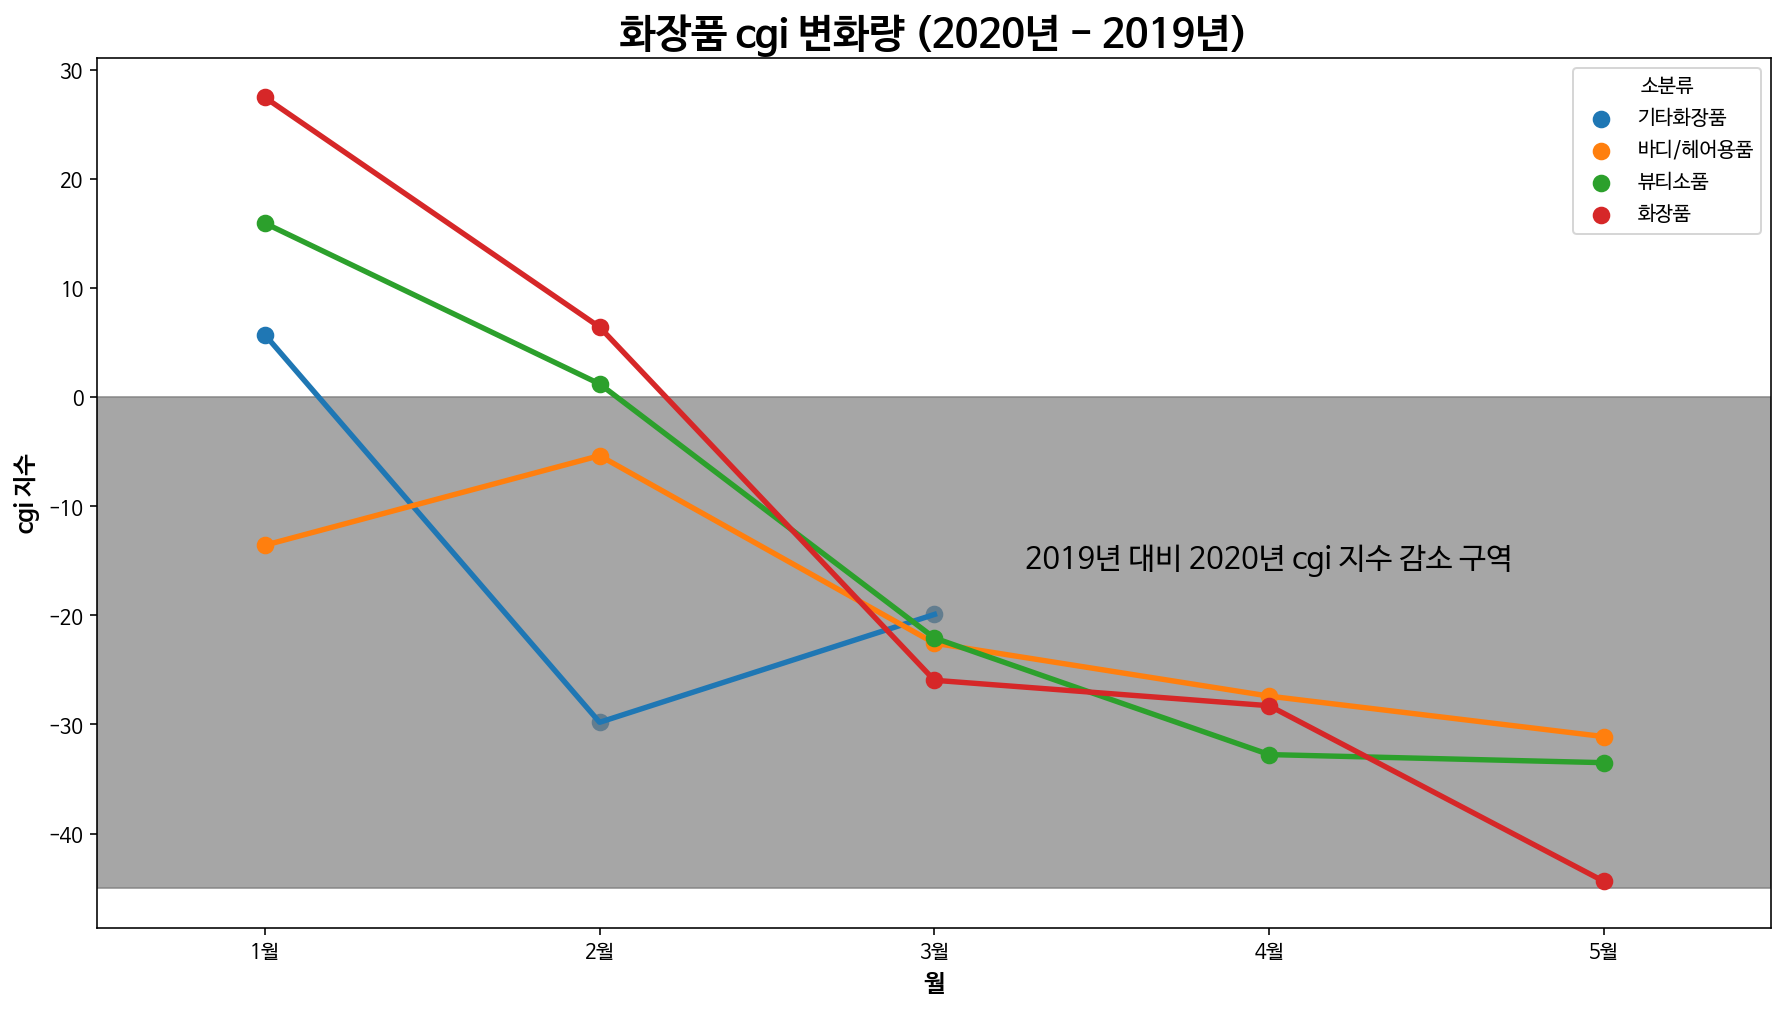

In [18]:
index_cgi2 = index.groupby(['year','month','catl','catm'])['cgi'].mean().reset_index()
index_cgi2_19 = index_cgi2.loc[(index_cgi2['month'] <= 5)&(index_cgi2['year'] == 2019)][['month','catm','catl','cgi']]
index_cgi2_19.columns = ['month','catm','catl','cgi_19']
index_cgi2_20 = index_cgi2.loc[(index_cgi2['month'] <= 5)&(index_cgi2['year'] == 2020)].reset_index()[['month','catm','catl','cgi']]
index_cgi2_20.columns  = ['month','catm','catl','cgi_20']
index_df2 = pd.merge(index_cgi2_19, index_cgi2_20, how='left')
index_df2['cgi_nus'] = index_df2.apply(lambda x: x['cgi_20'] - x['cgi_19'], axis = 1)

fig = plt.figure(figsize = (15,8))
ax = sns.pointplot(x = 'month', y = 'cgi_nus', hue = 'catm', data = index_df2.loc[index_df2['catl'] == '화장품'])
plt.title('화장품 cgi 변화량 (2020년 - 2019년)', fontsize = 20, fontweight = 'bold')
plt.xticks(np.arange(0,5),[f'{x}월' for x in np.arange(1,6)])
plt.xlabel('월', fontsize = 12, fontweight = 'bold')
plt.ylabel('cgi 지수', fontsize = 12, fontweight = 'bold')
ax.legend(loc = 'upper right',title = '소분류', title_fontsize = 10)
plt.axhspan(0, -45, color='gray', alpha = 0.7)
plt.annotate('2019년 대비 2020년 cgi 지수 감소 구역', xy = (3, -15), xytext = (3, -15), va = 'center', ha = 'center', fontsize = 15)

plt.show()

> - **cgi 변화량 : 2019년과 2020년을 비교하기 위해 2020년 월별 cgi 평균 지수를 2019년 월별 cgi 평균 지수를 뺐다.**  
- **cgi 변화량 0 초과 : 2019년에 비해 2020년에 cgi 지수가 높음(매출 증가).**  
- **cgi 변화량 0 미만 : 2019년에 비해 2020년에 cgi 지수가 낮음(매출 감소).**

기타화장품에는 2020년도 4월부터 데이터가 존재하지 않았습니다.  

수치의 차이는 있지만 **전체적으로 하락하는 모습입니다.**  
특히 **3월부터는 모든 cgi 지수 변화량이 음의 값을 기록하여 2019년에 비해 2020년에 매출이 감소**하였습니다.

그 중에서도 **뷰티소품, 화장품의 하락이 커보입니다.**  

**뷰티소품**은 **1월에 2번째로 높은 양의 cgi 지수 변화량**을 보였지만 **5월에는 두 번째로 낮은 cgi 지수**를 보였습니다.  

**화장품**은 **1월에 가장 높은 양의 cgi 지수 변화량**을 보였지만 **5월에는 가장 낮은 cgi 지수**를 보였습니다.  

**바디/헤어용품**은 한 번도 **cgi 지수가 0을 넘은 적이 없고** 계속 하락하는 모습입니다. 하지만 화장품, 뷰티소품의 변화량에 비해 **비교적 적은 변화량**을 보입니다.  

<font color = 'red'>**마스크와 한 몸이 된 코로나 시대에는 얼굴의 반 이상이 가려져 뷰티 소품이나 화장품 소비가 하락세일 것으로 보입니다.**</font>  
<font color = 'red'>**하지만 씻기는 해야되므로 바디/헤어용품의 소비에는 큰 변화가 없을 것으로 보입니다.**</font>

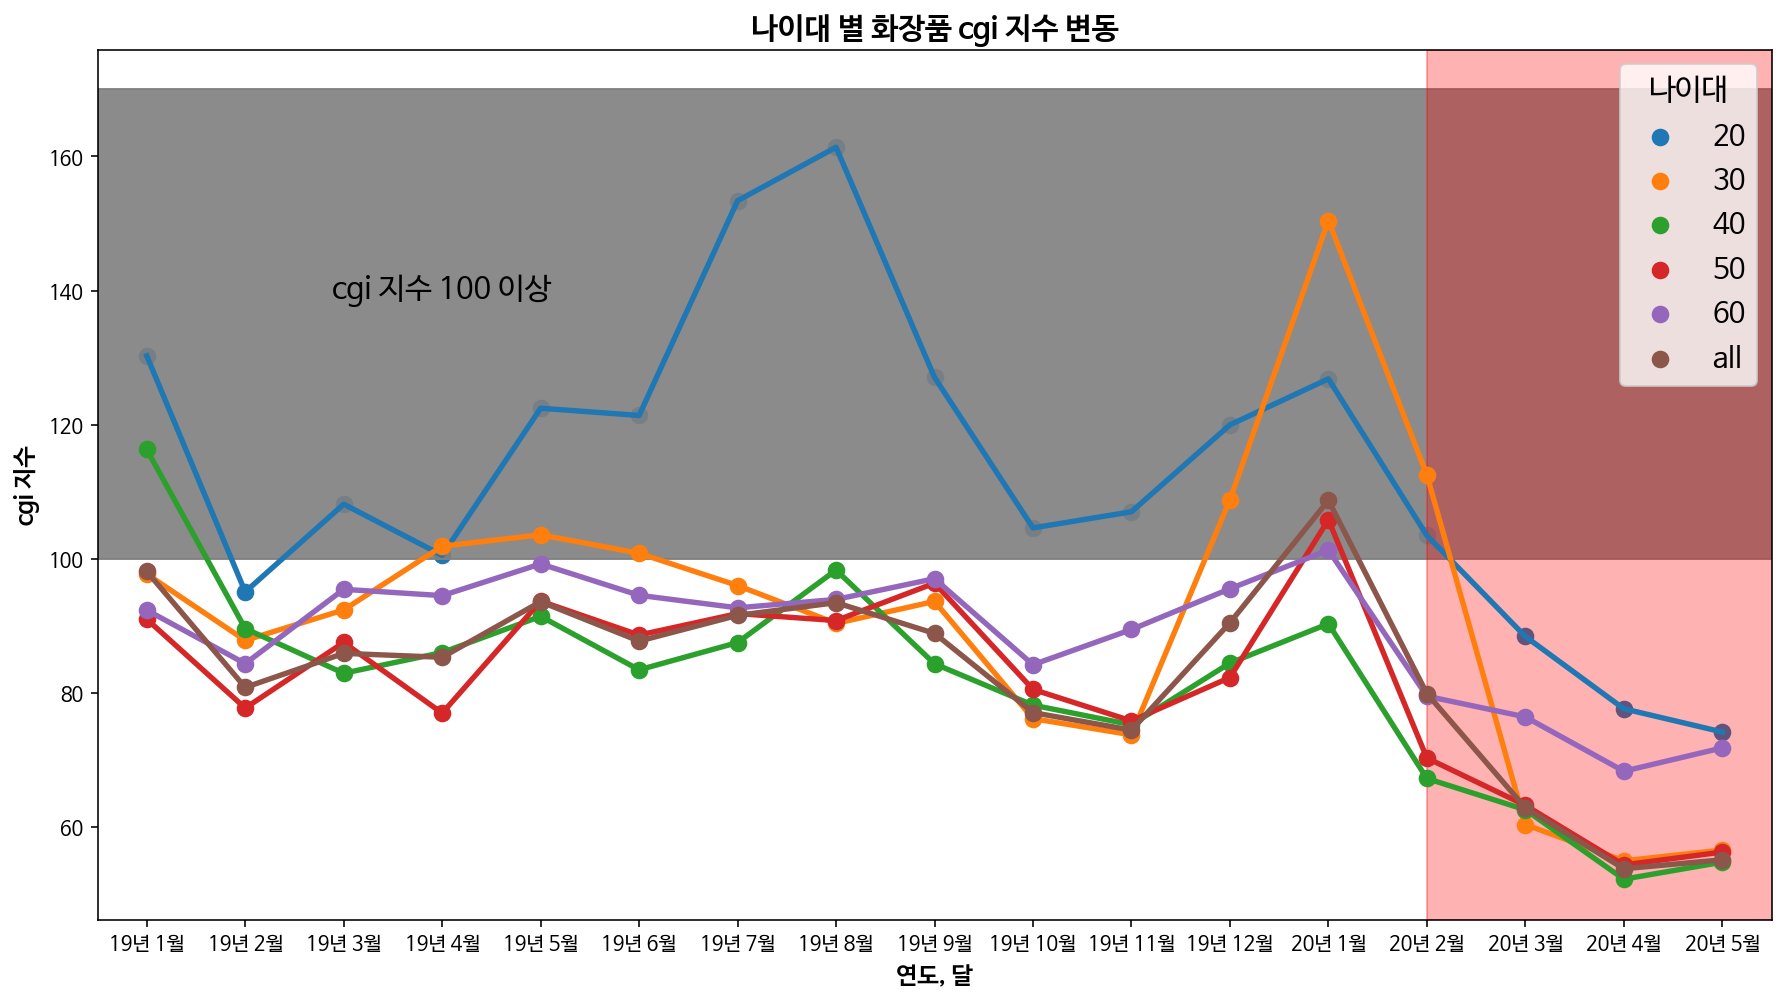

In [19]:
cosmetic = index.loc[index['catl'] == '화장품']
cosmetic.loc[cosmetic.loc[cosmetic['year'] == 2019].index,'month2'] = cosmetic.loc[cosmetic['year'] == 2019]['month']
cosmetic.loc[cosmetic.loc[cosmetic['year'] == 2020].index,'month2'] = cosmetic.loc[cosmetic['year'] == 2020]['month'] + 12

fig = plt.figure(figsize = (15,8))
ax = sns.pointplot(x = 'month2', y = 'cgi', hue = 'age', data = cosmetic, ci = False)
plt.title('나이대 별 화장품 cgi 지수 변동', fontsize = 15, fontweight = 'bold')
plt.xticks(np.arange(0,17),([f'19년 {x}월' for x in np.arange(1,13)] + [f'20년 {x}월' for x in np.arange(1,6)]))
plt.axhspan(100, 170, color='gray', alpha = 0.7)
ax.annotate('cgi 지수 100 이상', xy = (3, 140), xytext = (3, 140), va = 'center', ha = 'center', fontsize = 15)
plt.legend(loc='upper right', fontsize='x-large',title = '나이대', title_fontsize = 15)
plt.xlabel('연도, 달', fontsize = 12, fontweight = 'bold')
plt.ylabel('cgi 지수', fontsize = 12, fontweight = 'bold')
plt.axhspan(100, 170, color='gray', alpha = 0.7)
plt.xlim(-0.5,16.5)
plt.axvspan(13, 17, color='red', alpha = 0.3)
fig.show()

> - **cgi : 카테고리성장지수 (2018년 월평균 대비 매출 성장 비율, 100을 기준으로 이상이면 매출 상승, 이하면 하락)**

대부분의 나이대에서는 이미 2019년 부터 화장품의 cgi 지수가 100 미만을 기록하여 매출 하락을 보였습니다.

**<font color = 'blue'>20대</font>의 경우 19년 2월을 제외하고는 20년 2월 전까지 꾸준하게 화장품 cgi 지수가 100을 넘겼습니다.**  
**20년 2월 이후로는 다른 나이대와 같이 하락세를 보였습니다.**  

<font color = 'red'>**꾸준히 화장품 소비가 있던 20대에게도 코로나의 영향이 있어보입니다.**</font>

### 식품

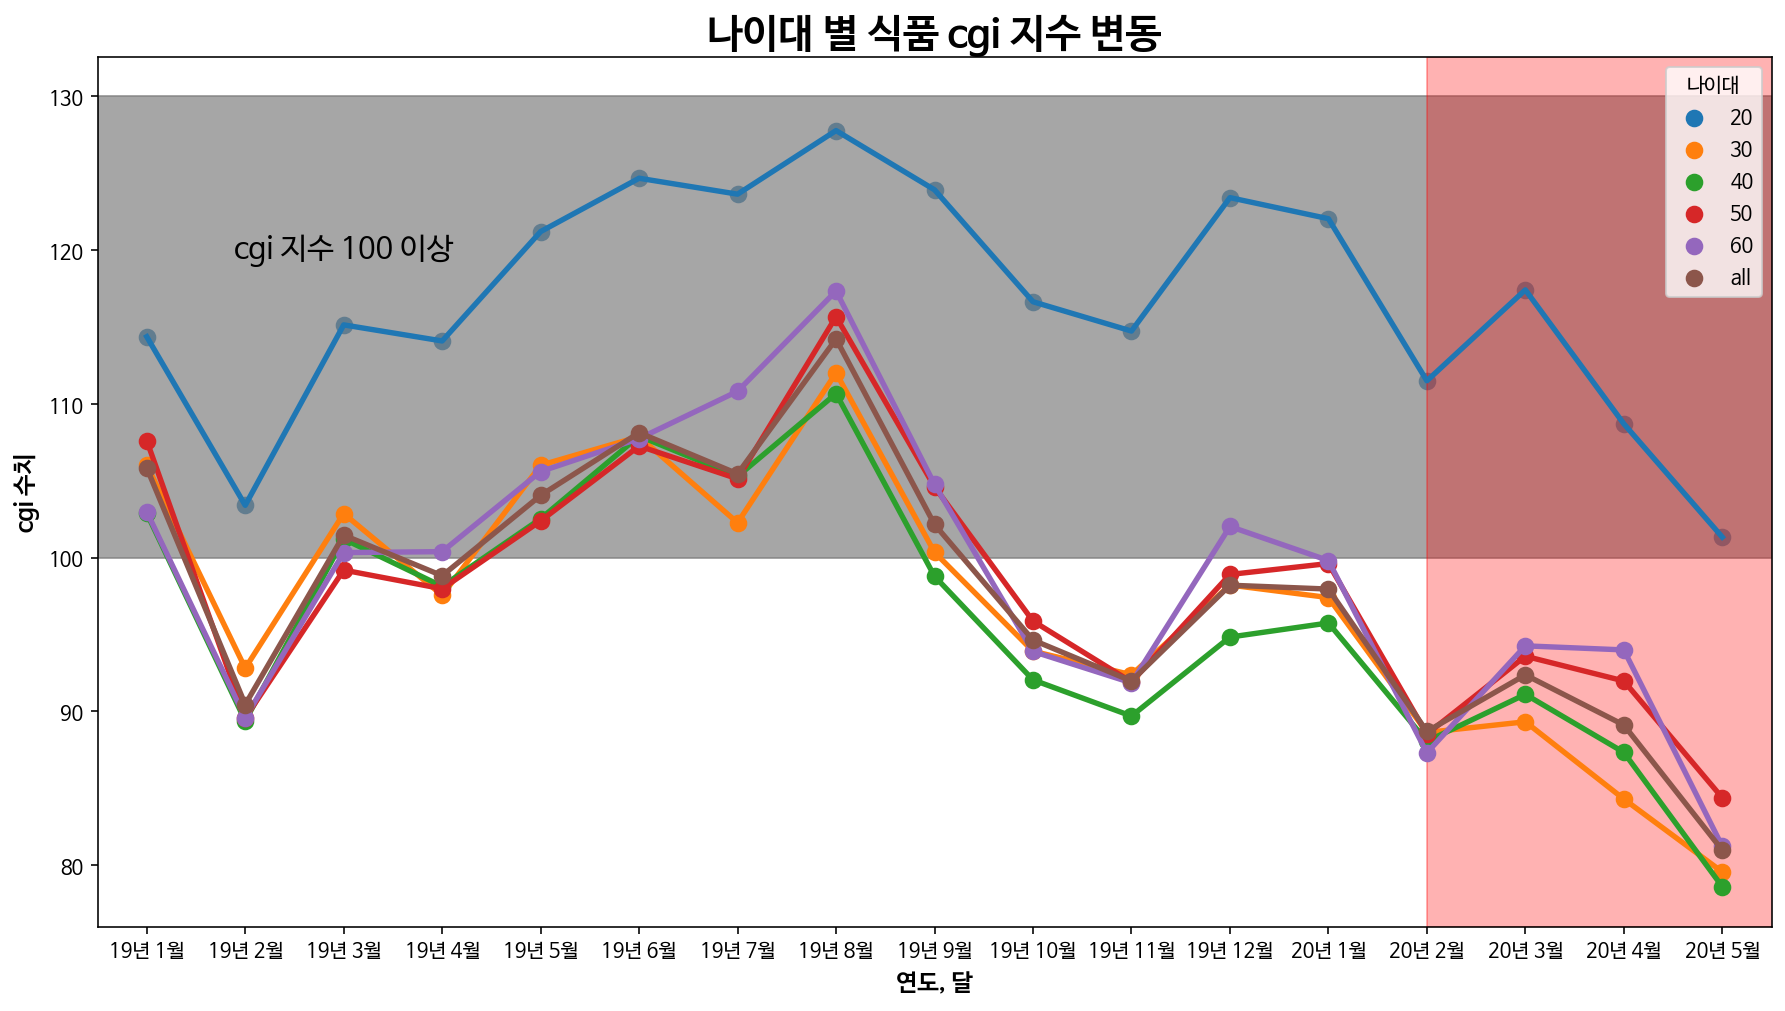

In [20]:
food = index.loc[index['catl'] == '식품']
food.loc[food.loc[food['year'] == 2019].index,'month2'] = food.loc[food['year'] == 2019]['month']
food.loc[food.loc[food['year'] == 2020].index,'month2'] = food.loc[food['year'] == 2020]['month'] + 12

fig = plt.figure(figsize = (15,8))
ax = sns.pointplot(x = 'month2', y = 'cgi', hue = 'age', data = food, ci = False)
plt.title('나이대 별 식품 cgi 지수 변동', fontsize = 20, fontweight = 'bold')
plt.xticks(np.arange(0,17),[f'19년 {x}월' for x in np.arange(1,13)] + [f'20년 {x}월' for x in np.arange(1,6)])
plt.axhspan(100, 130, color='gray', alpha = 0.7)
ax.annotate('cgi 지수 100 이상', xy = (2, 120), xytext = (2, 120), va = 'center', ha = 'center', fontsize = 15)
plt.legend(loc='upper right', fontsize='x-large')
plt.xlim(-0.5,16.5)
plt.xlabel('연도, 달', fontsize = 12, fontweight = 'bold')
plt.ylabel('cgi 수치', fontsize = 12, fontweight = 'bold')
plt.legend(loc='upper right',title = '나이대', title_fontsize = 10)
plt.axvspan(13, 17, color='red', alpha = 0.3)


fig.show()

3월부터 모든 나이대에서 감소를 보였습니다.

**하지만 <font color = 'blue'>20대</font>의 <font color = 'red'>식품 cgi 지수의 경우 꾸준히 100 이상을 기록하였습니다.</font>**  
**<font color = 'blue'>20대</font>에겐 식품이 중요해보입니다. ~~(저에게도 중요하고요)~~**

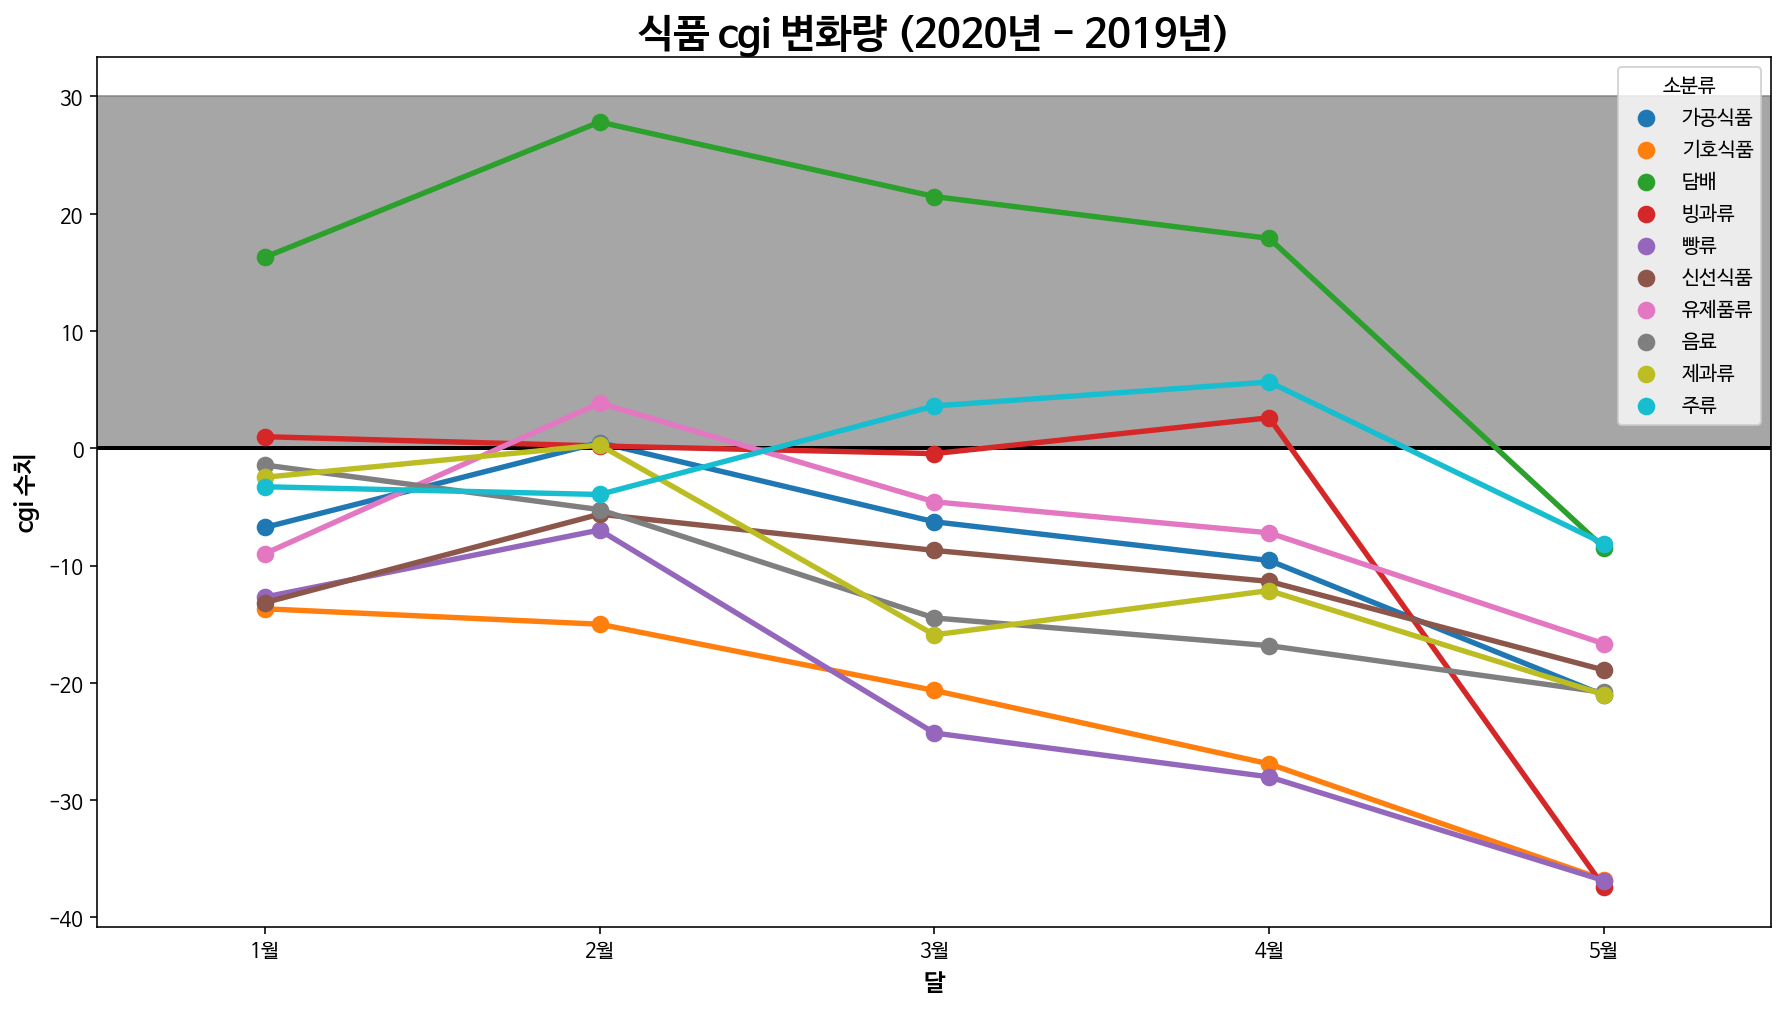

In [21]:
fig = plt.figure(figsize = (15,8))
ax = sns.pointplot(x = 'month', y = 'cgi_nus', hue = 'catm', data = index_df2.loc[index_df2['catl'] == '식품'])
plt.title('식품 cgi 변화량 (2020년 - 2019년)', fontsize = 20, fontweight = 'bold')
plt.xticks(np.arange(0,5),[f'{x}월' for x in np.arange(1,6)])
plt.plot([-1,5],[0,0], color = 'black', linewidth=2)
plt.xlim(-0.5,4.5)
plt.axhspan(0, 30, color='gray', alpha = 0.7)
plt.legend(loc='upper right')
plt.xlabel('달', fontsize = 12, fontweight = 'bold')
plt.ylabel('cgi 수치', fontsize = 12, fontweight = 'bold')
plt.legend(loc='upper right',title = '소분류', title_fontsize = 10)
plt.show()

> - **cgi 변화량 : 2019년과 2020년을 비교하기 위해 2020년 월별 cgi 평균 지수를 2019년 월별 cgi 평균 지수를 뺐습니다.**  
- **cgi 변화량 0 초과 : 2019년에 비해 2020년에 cgi 지수가 높음(매출 증가).**  
- **cgi 변화량 0 미만 : 2019년에 비해 2020년에 cgi 지수가 낮음(매출 감소).**

**담배의 경우 높은 cgi 변화량을 꾸준히 보였습니다.**  
**하지만 5월의 급감은 눈에 띄었습니다.**  
**주류도 cgi 수치가 0 근처에서 왔다갔다 하면서 비교적 안정적인 모습을 보여줬습니다.**  

**<font color = 'red'>주류와 담배</font>** 같은 경우에는 **감소를 하여도 상대적으로 높은 cgi**를 보인걸로 보아 **<font color = 'red'>식품 중에서 우선순위</font>**인 것으로 보입니다.

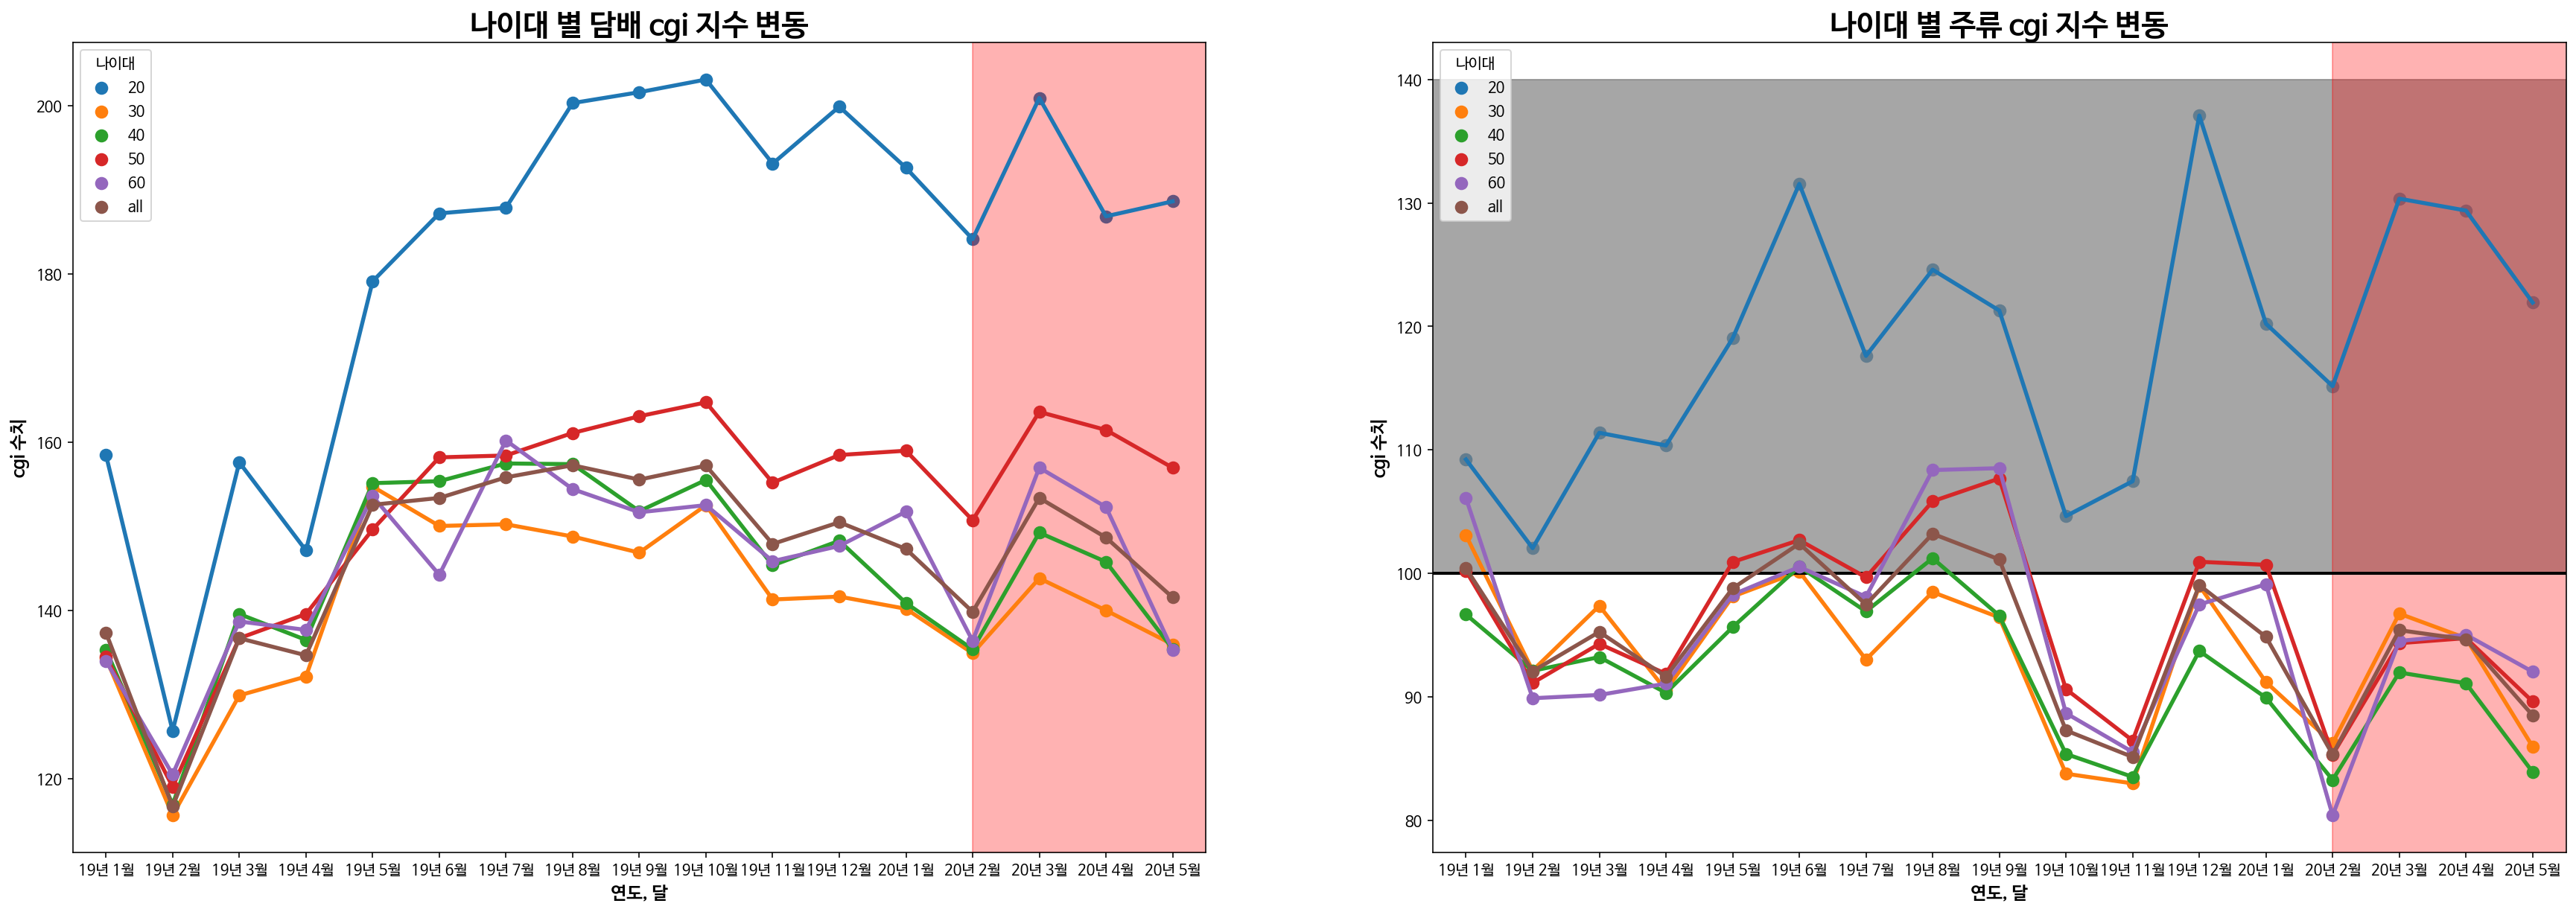

In [22]:
index_food = index.loc[(index['catm'] == '주류')|(index['catm'] == '담배')].groupby(['age','catm','month2'])['cgi'].mean().reset_index()

fig, ax = plt.subplots(1,2, figsize = (30,10))

sns.pointplot(x = 'month2', y = 'cgi', hue = 'age', data = index_food.loc[index_food['catm'] == '담배'], ax = ax[0])
ax[0].set_title('나이대 별 담배 cgi 지수 변동', fontsize = 20, fontweight = 'bold')
ax[0].set_xlabel('연도, 달', fontsize = 12, fontweight = 'bold')
ax[0].set_ylabel('cgi 수치', fontsize = 12, fontweight = 'bold')
ax[0].set_xticklabels([f'19년 {x}월' for x in np.arange(1,13)] + [f'20년 {x}월' for x in np.arange(1,6)])
ax[0].set_xlim(-0.5,16.5)
ax[0].legend(loc = 'upper left',title = '나이대', title_fontsize = 10)
ax[0].axvspan(13, 17, color='red', alpha = 0.3)

sns.pointplot(x = 'month2', y = 'cgi', hue = 'age', data = index_food.loc[index_food['catm'] == '주류'], ax = ax[1])
ax[1].set_title('나이대 별 주류 cgi 지수 변동', fontsize = 20, fontweight = 'bold')
ax[1].set_xlabel('연도, 달', fontsize = 12, fontweight = 'bold')
ax[1].set_ylabel('cgi 수치', fontsize = 12, fontweight = 'bold')
ax[1].set_xticklabels([f'19년 {x}월' for x in np.arange(1,13)] + [f'20년 {x}월' for x in np.arange(1,6)])
ax[1].plot([-0.5,16.5], [100,100], color = 'black', linewidth = 2)
ax[1].set_xlim(-0.5,16.5)
ax[1].axhspan(100, 140, color='gray', alpha = 0.7)
ax[1].legend(loc = 'upper left',title = '나이대', title_fontsize = 10)
ax[1].axvspan(13, 17, color='red', alpha = 0.3)
fig.show()

**담배의 경우 19년, 20년에 모든 연령대에서 cgi 지수가 100을 넘었습니다.**  
<font color = 'red'>**흡연자에게 담배는 매우 중요해보입니다.**</font>  
**특히 <font color = 'blue'>20대</font>의 담배 cgi 지수는 매우 높은 지수를 기록하였습니다.**

**주류 cgi의 지수는 <font color = 'blue'>20대</font>에서 계속 100을 넘었습니다.**  
**다른 나이대는 2020년 2월 이후부터(코로나 경제 영향 추측 시점) cgi 지수가 100 미만을 기록하여 감소하는 모습을 보였습니다.**

### 건강/의료용품

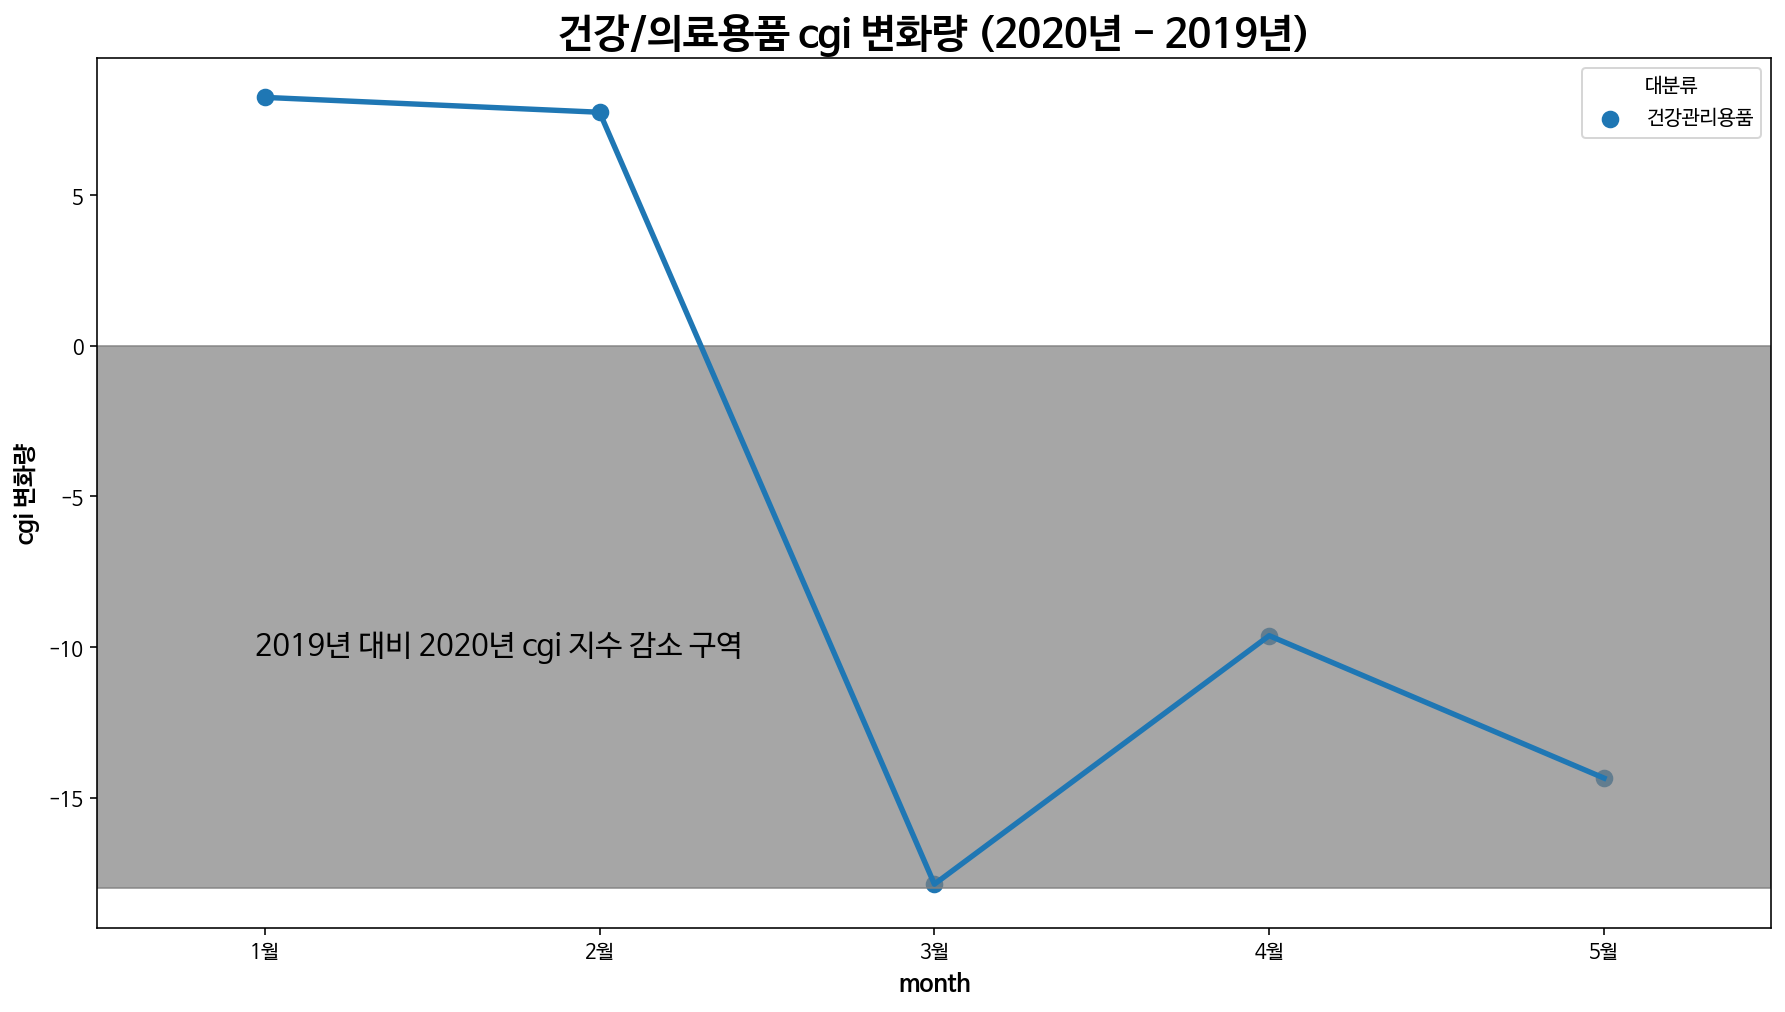

In [23]:
fig = plt.figure(figsize = (15,8))
ax = sns.pointplot(x = 'month', y = 'cgi_nus', hue = 'catm', data = index_df2.loc[index_df2['catl'] == '건강/의료용품'])
plt.title('건강/의료용품 cgi 변화량 (2020년 - 2019년)', fontsize = 20, fontweight = 'bold')
plt.xticks(np.arange(0,5),[f'{x}월' for x in np.arange(1,6)])
plt.axhspan(-18, 0, color='gray', alpha = 0.7)
plt.annotate('2019년 대비 2020년 cgi 지수 감소 구역', xy = (0.7, -10), xytext = (0.7, -10), va = 'center', ha = 'center', fontsize = 15)
plt.xlabel('month', fontsize = 12, fontweight = 'bold')
plt.ylabel('cgi 변화량', fontsize = 12, fontweight = 'bold')
plt.legend(loc = 'upper right',title = '대분류', title_fontsize = 10)
plt.show()

**2월 이후 부터 급격하게 감소하는 모습을 보였습니다.**  
**그리고 이 구간에서 cgi 변화량이 0 미만을 기록하였습니다.**

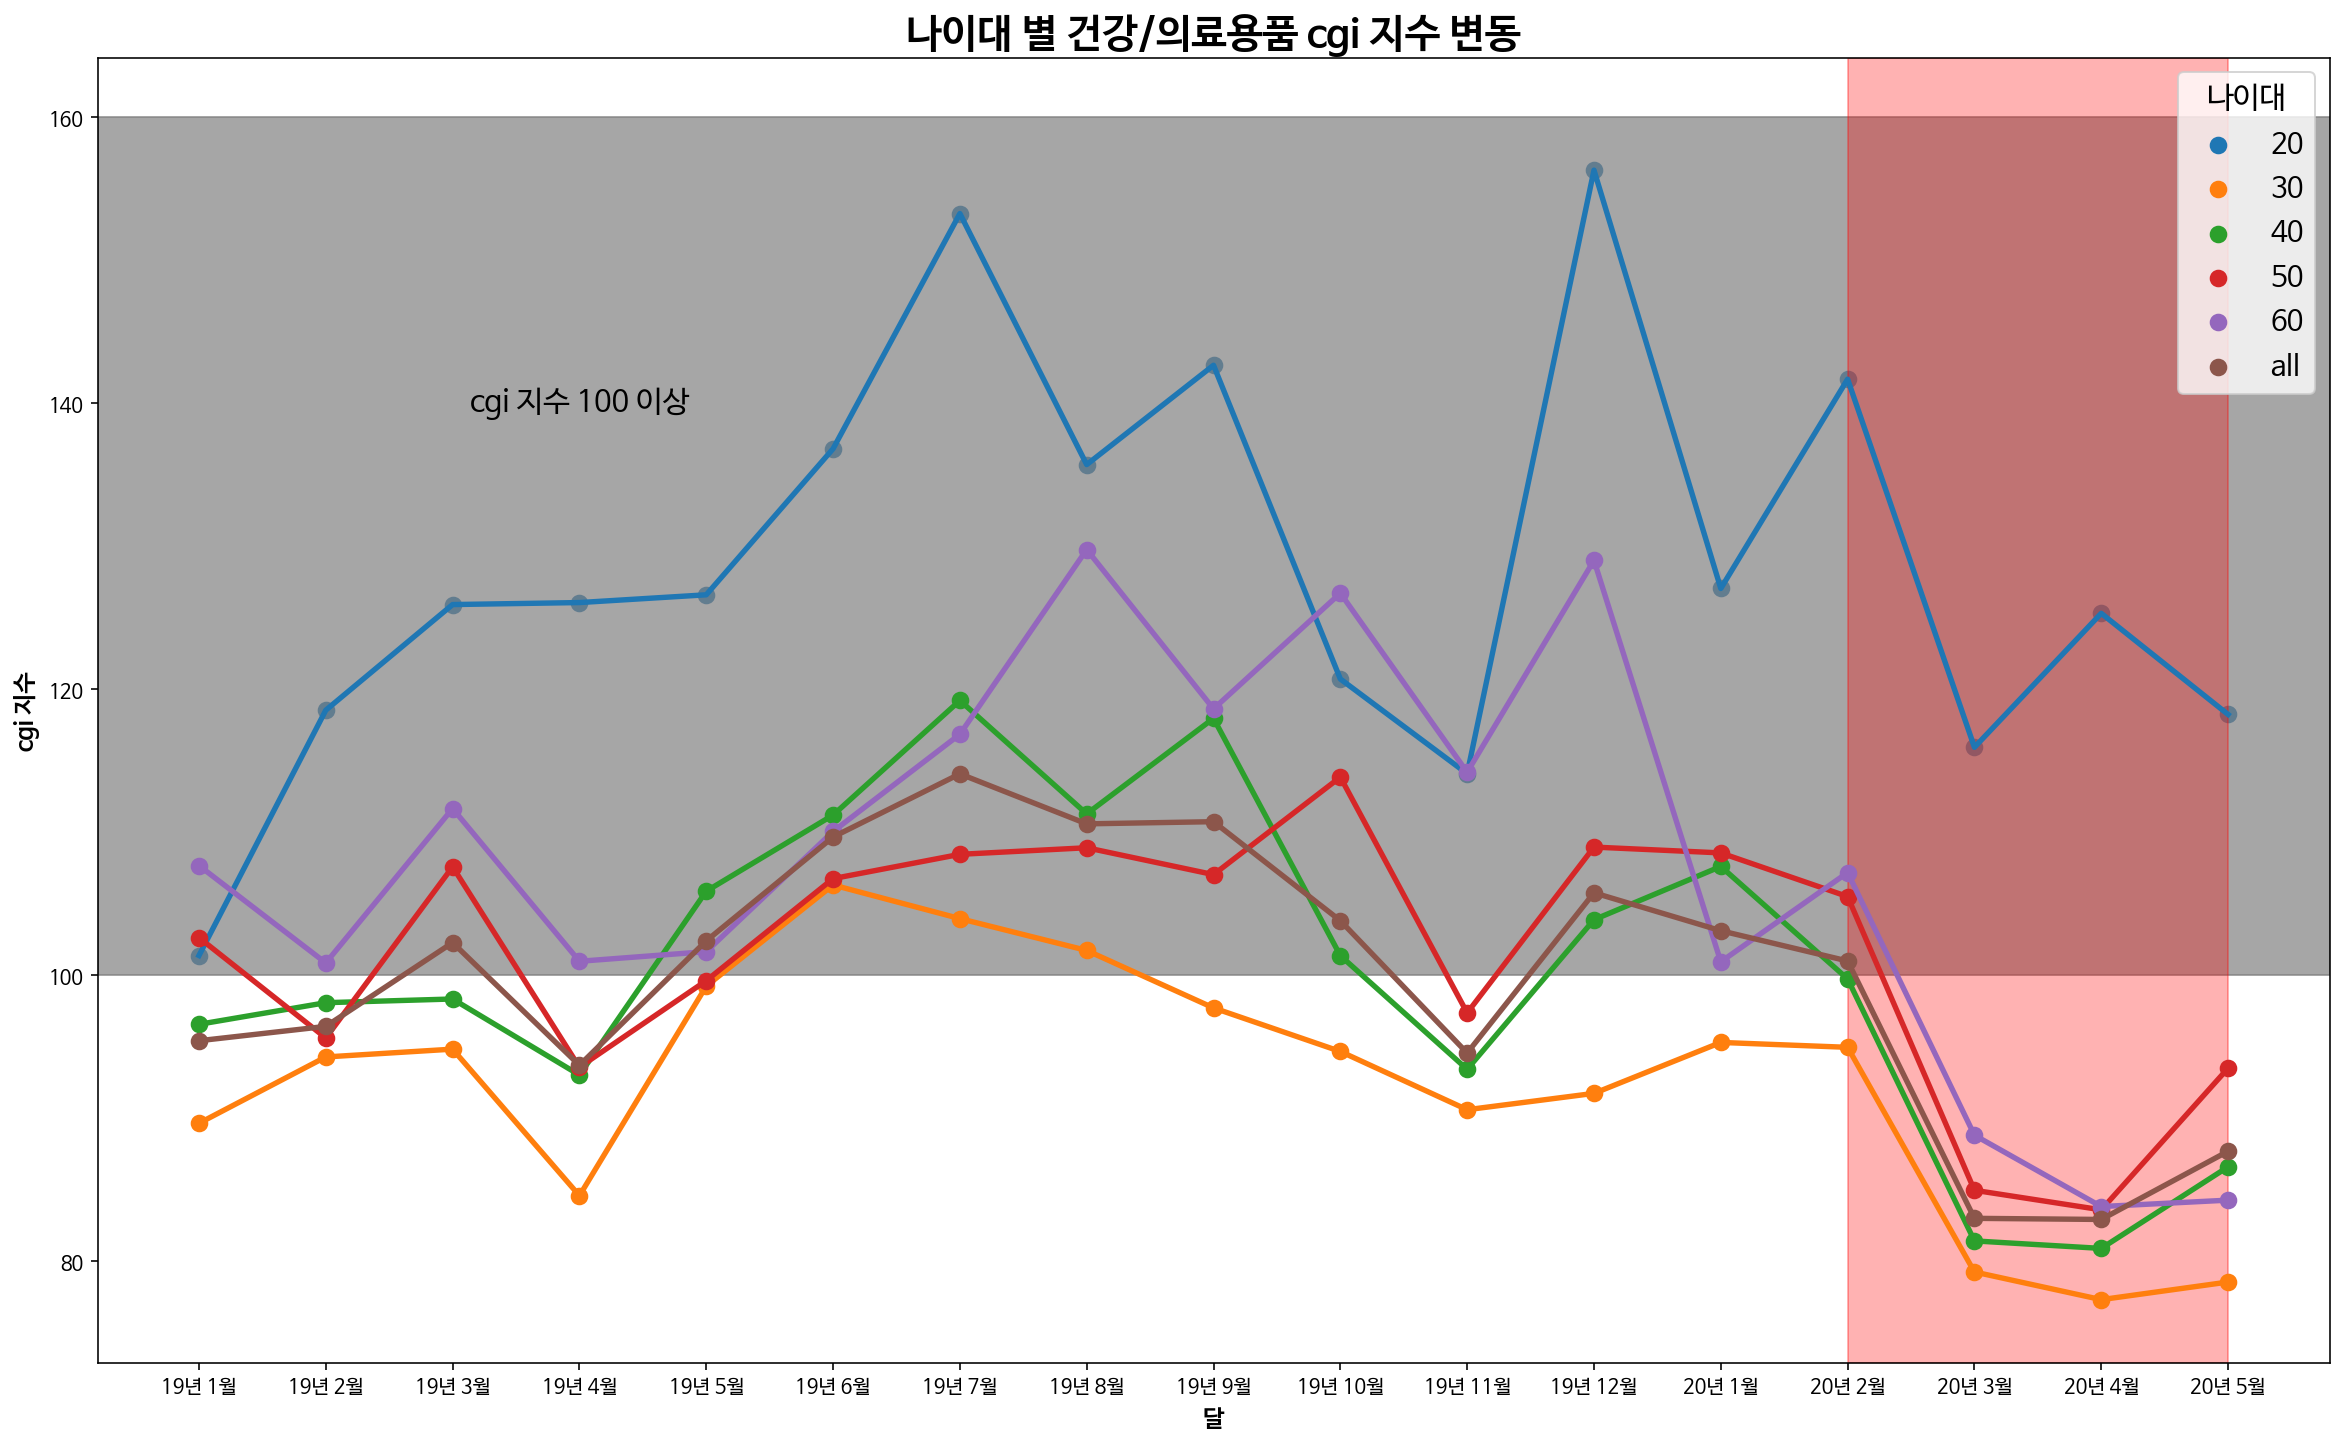

In [24]:
health = index.loc[index['catl'] == '건강/의료용품']
health.loc[health.loc[health['year'] == 2019].index,'month2'] = health.loc[health['year'] == 2019]['month']
health.loc[health.loc[health['year'] == 2020].index,'month2'] = health.loc[health['year'] == 2020]['month'] + 12

fig = plt.figure(figsize = (20,12))
ax = sns.pointplot(x = 'month2', y = 'cgi', hue = 'age', data = health, ci = False)
plt.title('나이대 별 건강/의료용품 cgi 지수 변동', fontsize = 20, fontweight = 'bold')
plt.xticks(np.arange(0,17),[f'19년 {x}월' for x in np.arange(1,13)] + [f'20년 {x}월' for x in np.arange(1,6)])
plt.axhspan(100, 160, color='gray', alpha = 0.7)
ax.annotate('cgi 지수 100 이상', xy = (3, 140), xytext = (3, 140), va = 'center', ha = 'center', fontsize = 15)
plt.legend(loc='upper right', fontsize='x-large', title = '나이대', title_fontsize= 15)
plt.xlabel('달', fontsize = 12, fontweight = 'bold')
plt.ylabel('cgi 지수', fontsize = 12, fontweight = 'bold')
plt.axvspan(13, 16, color='red', alpha = 0.3)
fig.show()

**건강/의료용품에서도 <font color = 'blue'>20대</font>가 가장 높은 cgi 지수를 보였습니다.**  
**또한 <font color = 'blue'>20대</font>는 모든 구간에서 cgi 지수가 100을 넘었습니다.**  
**그리고 2020년 2월 이후 구간(코로나 경제 타격 예상 구간)에서도 다른 나이대와 cgi 지수가 차이가 나보입니다.**

### 일용품

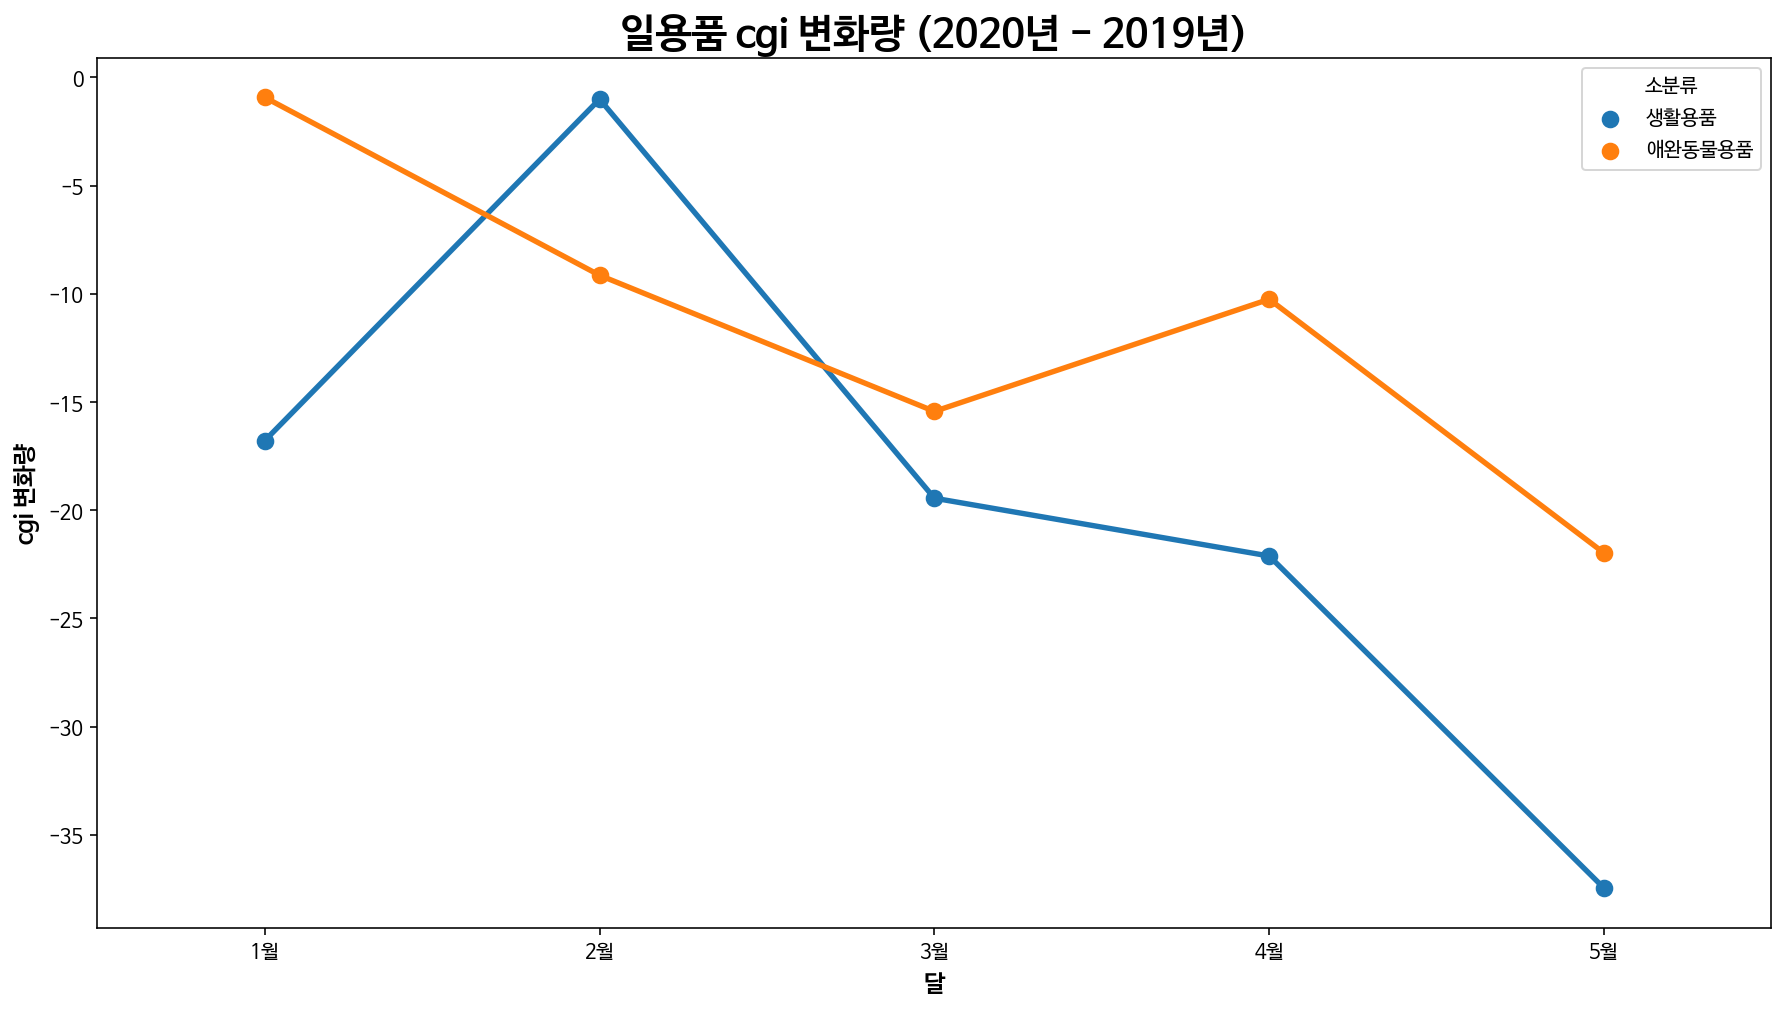

In [25]:
fig = plt.figure(figsize = (15,8))
ax = sns.pointplot(x = 'month', y = 'cgi_nus', hue = 'catm', data = index_df2.loc[index_df2['catl'] == '일용품'])
plt.title('일용품 cgi 변화량 (2020년 - 2019년)', fontsize = 20, fontweight = 'bold')
plt.xticks(np.arange(0,5),[f'{x}월' for x in np.arange(1,6)])
plt.xlabel('달', fontsize = 12, fontweight = 'bold')
plt.ylabel('cgi 변화량', fontsize = 12, fontweight = 'bold')
plt.legend(title = '소분류', title_fontsize= 10)
plt.show()

일용품은 평균 cgi 변화량이 0 미만을 기록하였습니다.  
2020년에 비해 매출이 감소하였다는 것을 볼 수 있습니다.  

생활용품의 경우 2월 이후부터(코로나 경제 타격 추측 구간)에 하락세를 보였습니다.  
비교적 애완동물용품의 변화량은 적어보였습니다.

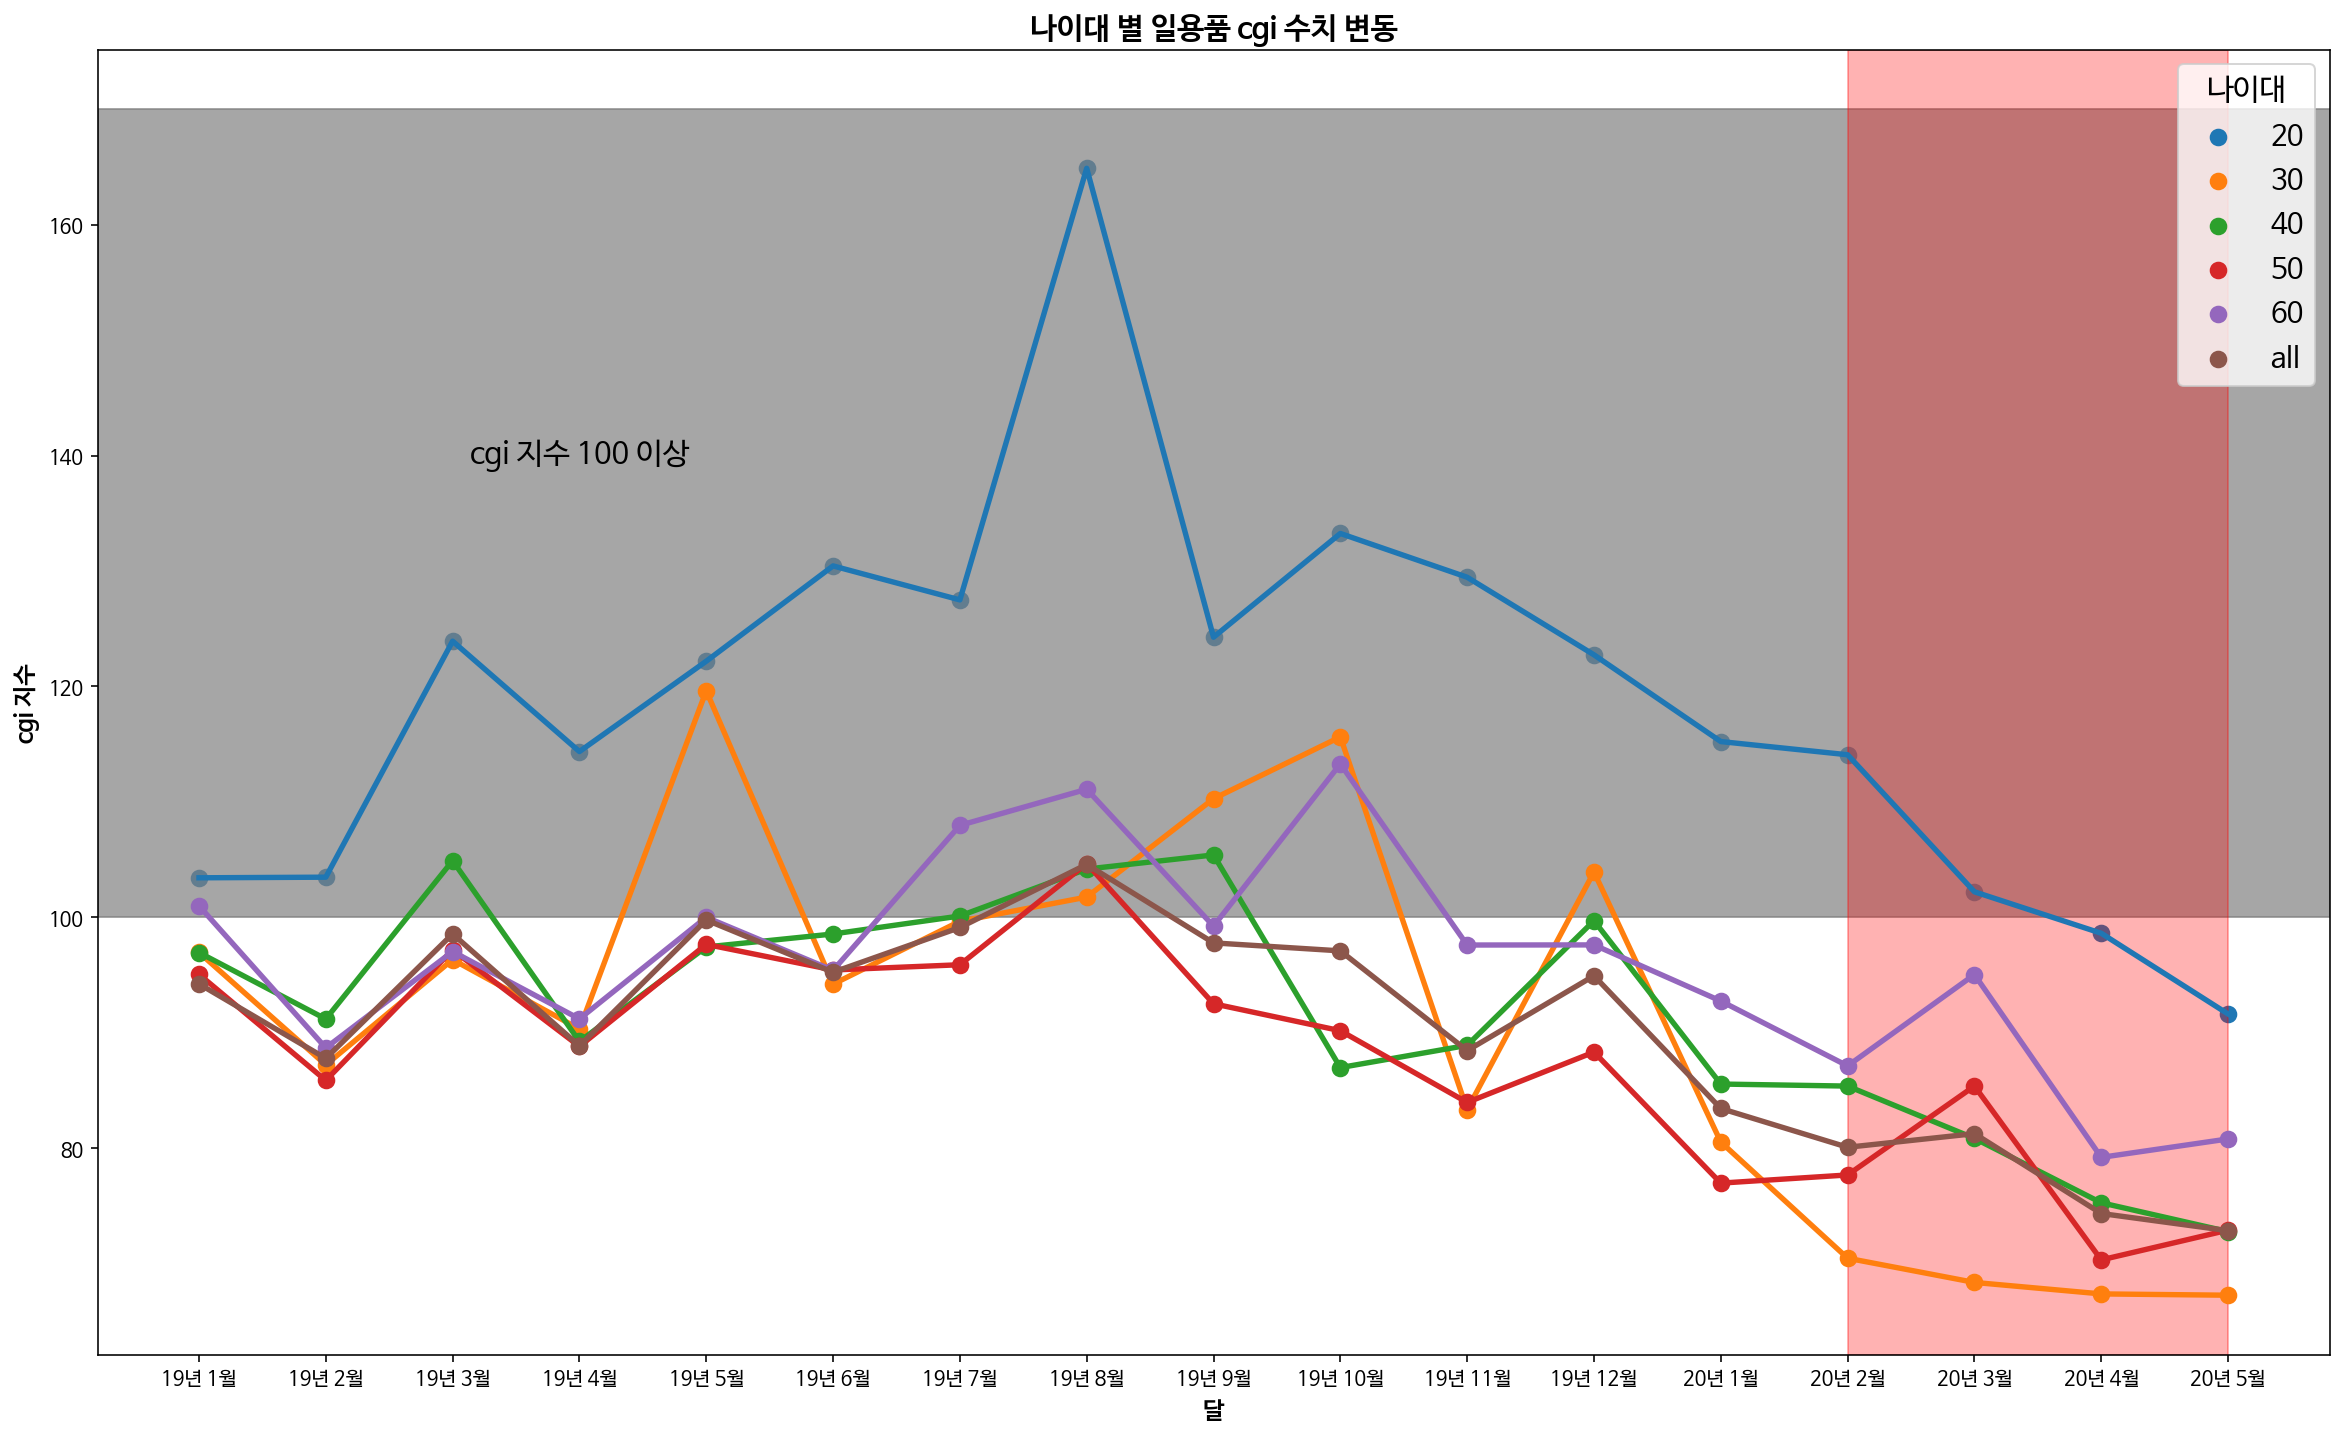

In [26]:
goods = index.loc[index['catl'] == '일용품']
goods.loc[goods.loc[goods['year'] == 2019].index,'month2'] = goods.loc[goods['year'] == 2019]['month']
goods.loc[goods.loc[goods['year'] == 2020].index,'month2'] = goods.loc[goods['year'] == 2020]['month'] + 12

fig = plt.figure(figsize = (20,12))
ax = sns.pointplot(x = 'month2', y = 'cgi', hue = 'age', data = goods, ci = False)
plt.title('나이대 별 일용품 cgi 수치 변동', fontsize = 15, fontweight = 'bold')
plt.xticks(np.arange(0,17),[f'19년 {x}월' for x in np.arange(1,13)] + [f'20년 {x}월' for x in np.arange(1,6)])
plt.axhspan(100, 170, color='gray', alpha = 0.7)
ax.annotate('cgi 지수 100 이상', xy = (3, 140), xytext = (3, 140), va = 'center', ha = 'center', fontsize = 15)
plt.legend(loc='upper right', fontsize='x-large', title = '나이대', title_fontsize= 15)
plt.axvspan(13, 16, color='red', alpha = 0.3)
plt.xlabel('달', fontsize = 12, fontweight = 'bold')
plt.ylabel('cgi 지수', fontsize = 12, fontweight = 'bold')
fig.show()

**여전히 <font color = 'blue'>20대</font>가 cgi가 가장 높았습니다.**  
**2월 이후 <font color = 'blue'>20대</font>도 감소하였지만 다른 나이대에 비해 감소폭이 적었습니다.**

## 전체 연도/나이대

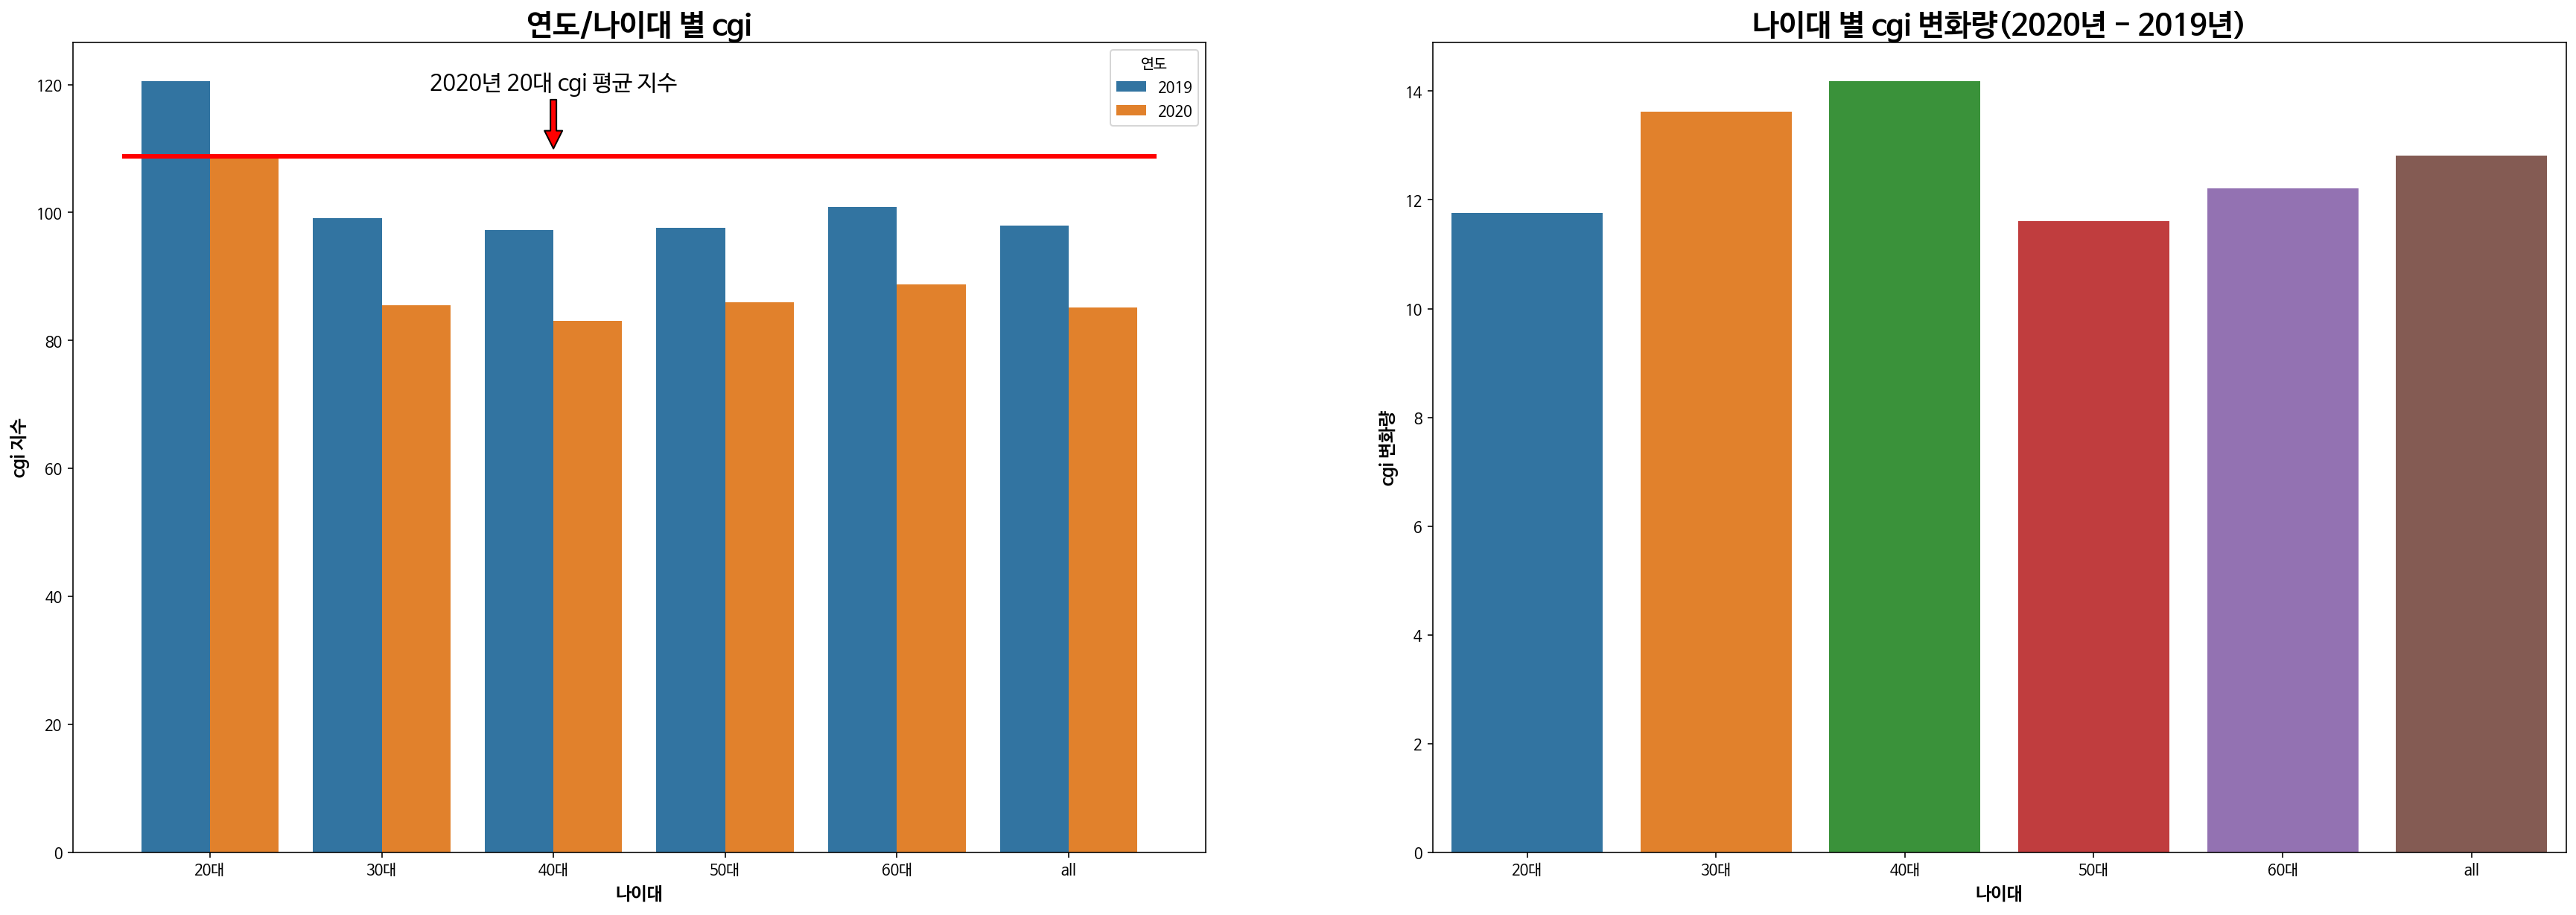

In [27]:
age_index = index.groupby(['age','year'])['cgi'].mean().to_frame().reset_index()
age_year_cgi = age_index.loc[age_index['year'] == 2019].reset_index(drop = True)['cgi']  - age_index.loc[age_index['year'] == 2020].reset_index(drop = True)['cgi']
age_year_cgi.index = ['20대','30대','40대','50대','60대','all']
age_year_cgi = age_year_cgi.to_frame().reset_index()

fig, ax = plt.subplots(1,2, figsize = (30,10))
sns.barplot(x = 'age', y = 'cgi', hue = 'year', data = age_index, ax = ax[0])
ax[0].set_title('연도/나이대 별 cgi', fontsize = 20, fontweight = 'bold')
ax[0].plot([-0.5,5.5],[108.762677,108.762677], color = 'r', linewidth = 3)
ax[0].set_xticklabels(['20대','30대','40대','50대','60대','all'])
ax[0].set_xlabel('나이대',fontsize = 12,fontweight = 'bold')
ax[0].set_ylabel('cgi 지수',fontsize = 12,fontweight = 'bold')
ax[0].legend(title = '연도', title_fontsize = 10)
ax[0].annotate('2020년 20대 cgi 평균 지수', xy = (2, 110), xytext = (2, 120), va = 'center', ha = 'center', fontsize = 15, arrowprops=dict(facecolor='red'))

sns.barplot(x = 'index', y = 'cgi', data  = age_year_cgi, ax = ax[1])
ax[1].set_xlabel('나이대',fontsize = 12,fontweight = 'bold')
ax[1].set_ylabel('cgi 변화량',fontsize = 12,fontweight = 'bold')
ax[1].set_title('나이대 별 cgi 변화량(2020년 - 2019년)', fontsize = 20, fontweight = 'bold')

fig.show()

**왼쪽 그래프를 보면 <font color = 'blue'>20대</font>의 cgi지수가 2019년 2020년 모두 높았고 <font color = 'blue'>20대</font> <font color = 'red'>2020년의 cgi 지수는 다른 나이대 2019, 2020년 cgi 보다 높았습니다<font>**  

또한 오른쪽 그래프를 보면 20대의 전체 cgi 변화량이 적었고  
30, 40대의 cgi 변화량은 비교적 컸습니다.  

**경제의 최전선에 있는 30, 40대가 가장 민감하게 반응한 것으로 보입니다.**

## 정리

- **2019년과 2020년 1 ~ 2월은 cgi 지수가 별 차이가 없습니다.**  
- **2020년 3월부터 cgi 지수가 차이를 보입니다.**
- **<font color = 'blue'>20대</font>가 모든 대분류 품목에서 가장 높은 cgi 지수를 기록하였습니다.**  
- **<font color = 'blue'>20대</font> 식품, 건강/의료용품은 2020년 3 ~ 5월에도 cgi 지수가 100을 넘겼습니다.**  
- **특히 주류에서 <font color = 'blue'>20대</font>는 cgi 지수가 100을 넘겼습니다.**  
- **담배의 경우 모든 나이대에서 cgi 지수가 100을 넘겼습니다(대체불가).**  
- **코로나가 찾아온 2020년의 <font color = 'blue'>20대</font> cgi 지수는 코로나가 오기전 2019년 다른 나이대 cgi보다도 높았습니다.**
- **<font color = 'blue'>20대</font>가 2019년 대비 2020년 cgi 지수 변화량도 적었습니다.**

# 非대면 트렌드 (카드, 배달 데이터로 본 비대면 사회)

## Card 데이터 확인

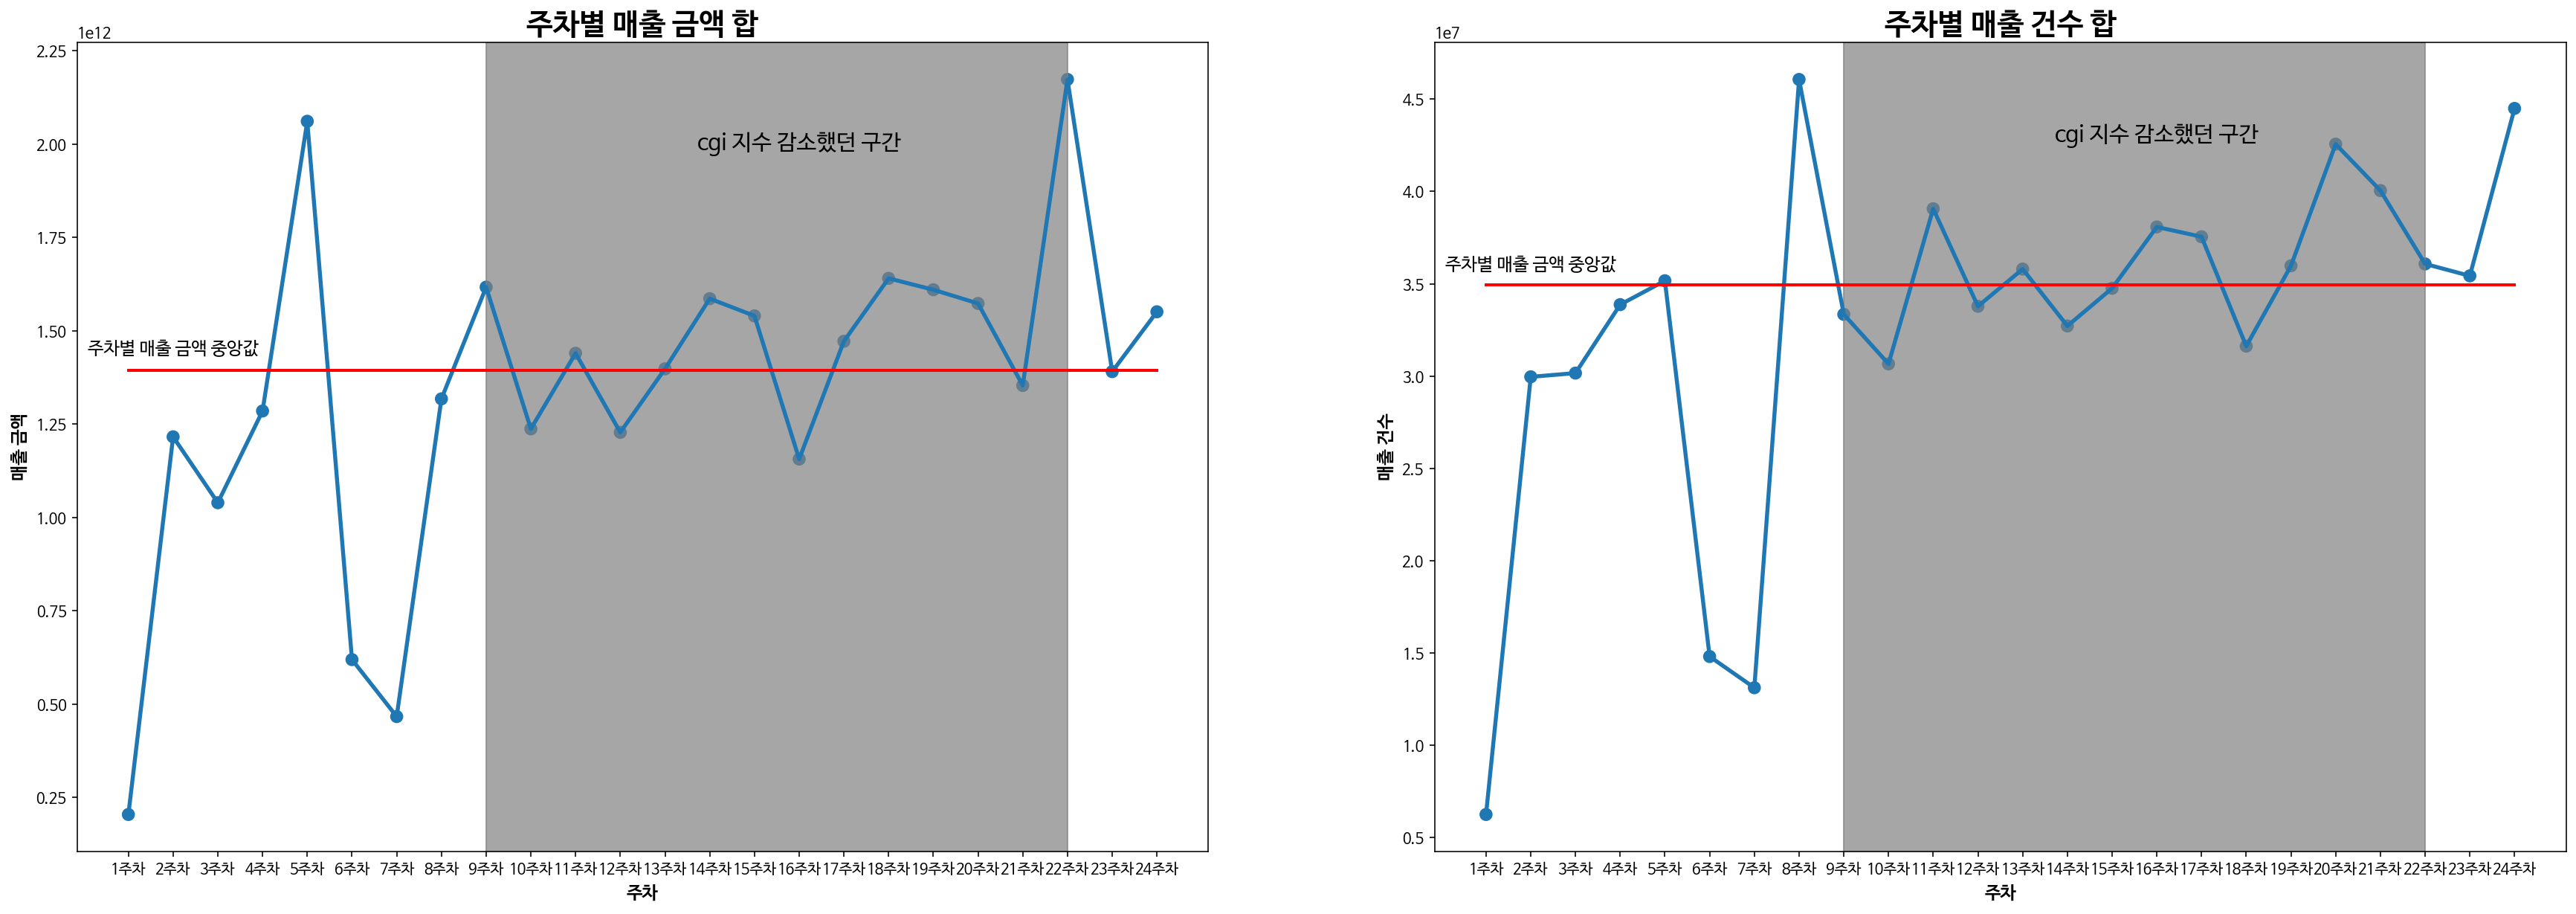

In [28]:
fig, ax = plt.subplots(1,2, figsize = (30,10))

sns.pointplot(x = 'weeks', y = 'salamt', data = card_week, ax = ax[0])
ax[0].set_title('주차별 매출 금액 합', fontsize = 20, fontweight = 'bold')
ax[0].set_xticklabels([f'{x}주차' for x in np.arange(1,25)])
ax[0].set_xlabel('주차', fontsize = 12, fontweight = 'bold')
ax[0].set_ylabel('매출 금액', fontsize = 12, fontweight = 'bold')
ax[0].plot([0,23],[card_week['salamt'].median(),card_week['salamt'].median()], color = 'r', linewidth = 2)
ax[0].axvspan(8, 21, color='gray', alpha = 0.7)
ax[0].annotate('cgi 지수 감소했던 구간', xy = (15, 2e12), xytext = (15, 2e12), va = 'center', ha = 'center', fontsize = 15)
ax[0].annotate('주차별 매출 금액 중앙값', xy = (1, 1.45e12), xytext = (1, 1.45e12), va = 'center', ha = 'center', fontsize = 12)

sns.pointplot(x = 'weeks', y = 'selng_cascnt', data = card_week, ax = ax[1])
ax[1].set_title('주차별 매출 건수 합', fontsize = 20, fontweight = 'bold')
ax[1].set_xticklabels([f'{x}주차' for x in np.arange(1,25)])
ax[1].set_xlabel('주차', fontsize = 12, fontweight = 'bold')
ax[1].set_ylabel('매출 건수', fontsize = 12, fontweight = 'bold')
ax[1].plot([0,23],[card_week['selng_cascnt'].median(),card_week['selng_cascnt'].median()], color = 'r', linewidth = 2)
ax[1].axvspan(8, 21, color='gray', alpha = 0.7)
ax[1].annotate('cgi 지수 감소했던 구간', xy = (15, 4.3e7), xytext = (15, 4.3e7), va = 'center', ha = 'center', fontsize = 15)
ax[1].annotate('주차별 매출 금액 중앙값', xy = (1, 3.6e7), xytext = (1, 3.6e7), va = 'center', ha = 'center', fontsize = 12)

fig.show()

매출 금액과 매출 건수는 **cgi 지수가 감소 했던 구간에 비해 변동이 적고 수치도 떨어지지 않았습니다.**  
**<font color = 'red'>이는 앞서 cgi 지수와 반대되는 모습을 보였습니다.</font>**

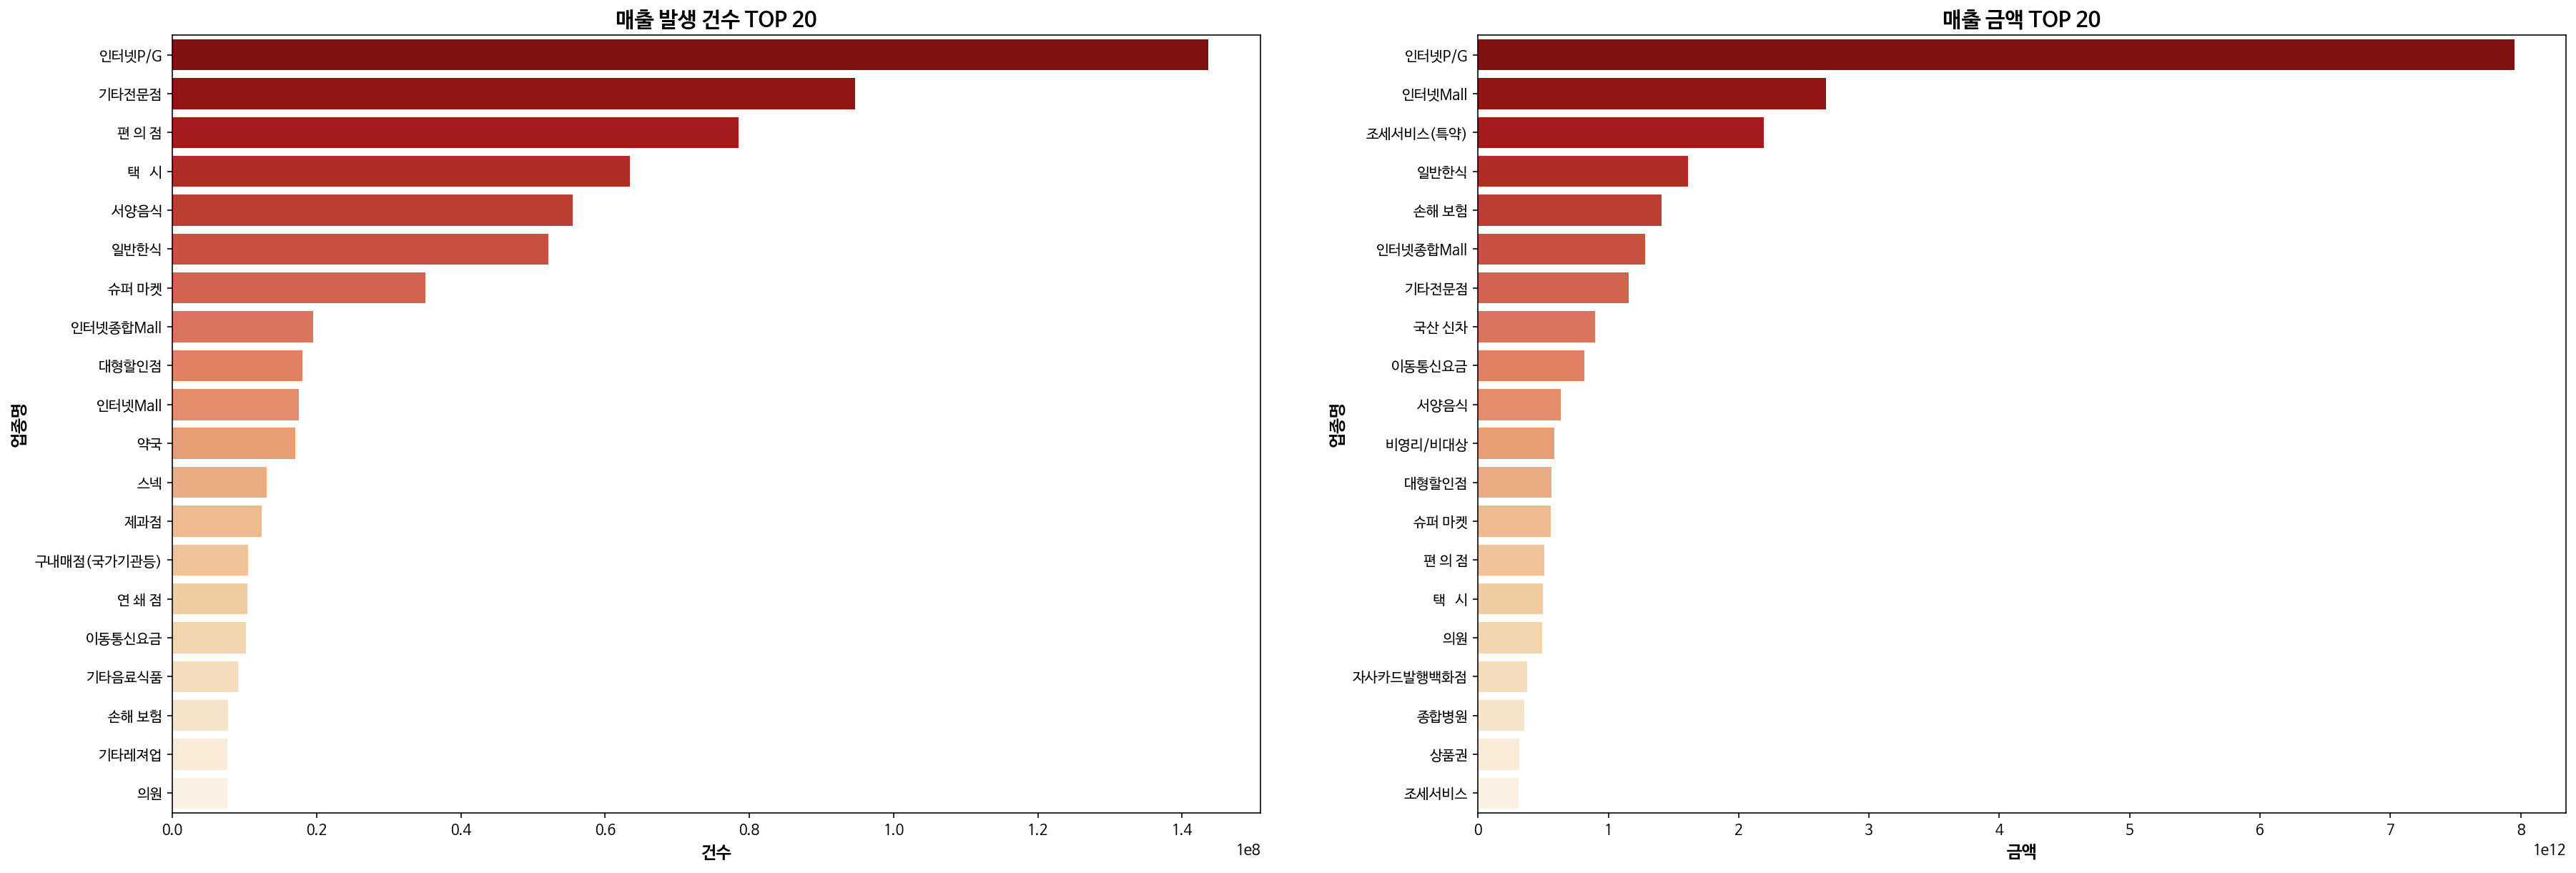

In [29]:
fig, ax = plt.subplots(1,2, figsize = (30,10))

sns.barplot(x = card_count.values[:20], y = card_count.index[:20], ax = ax[0], palette = 'OrRd_r')
sns.barplot(x = card_balance.values[:20], y = card_balance.index[:20], ax = ax[1], palette = 'OrRd_r')
ax[0].set_xlabel('건수', fontweight = 'bold', fontsize = 12)
ax[0].set_ylabel('업종명', fontweight = 'bold', fontsize = 12)
ax[0].set_title('매출 발생 건수 TOP 20', fontsize = 15, fontweight = 'bold')

ax[1].set_xlabel('금액', fontweight = 'bold', fontsize = 12)
ax[1].set_ylabel('업종명', fontweight = 'bold', fontsize = 12)
ax[1].set_title('매출 금액 TOP 20', fontsize = 15, fontweight = 'bold')

fig.show()

매출 건수와 매출 금액을 업종별로 더해 확인해 보았습니다.  

**인터넷P/G가 매출 건수, 매출 금액 모두 가장 높았습니다.**  
**이 값은 다른 업종에 비해 높은 수치를 기록하였습니다.**  
**<font color = 'red'>그렇기 때문에 card에서는 인터넷P/G가 가장 중요할 것으로 예상됩니다.</font>**



> 인터넷P/G : 고객이 인터넷 쇼핑몰에서 상품과 서비스를 구매할 때, 그 대금을 신용카드 및 기타 결제수단을 이용하여 안전하고 편리하게 결제할 수 있도록 지원하는 서비스

출처 : https://www.firstpay.co.kr/jsp/service/serviceInformation.jsp


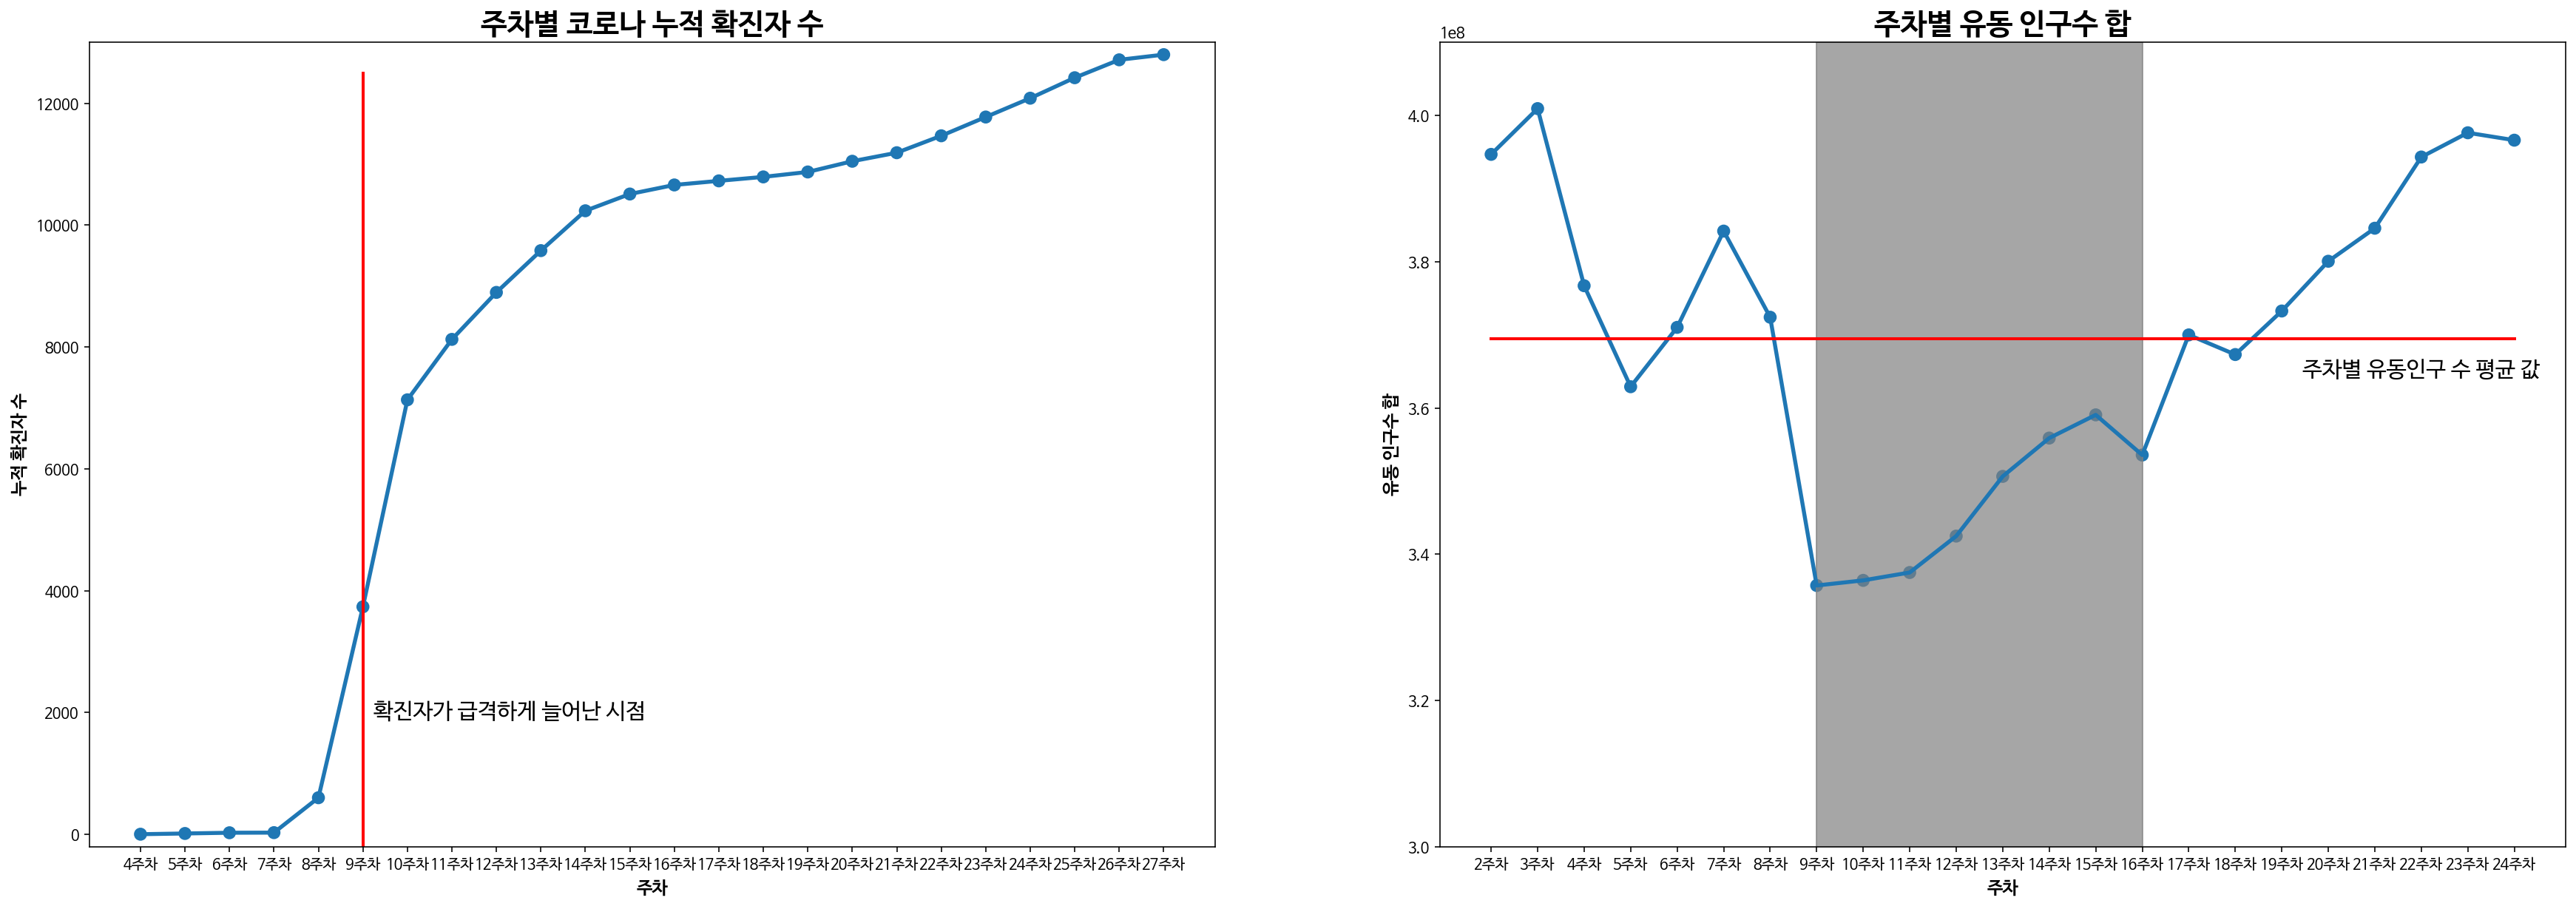

In [30]:
fig, ax = plt.subplots(1,2, figsize = (30,10))

sns.pointplot(x = 'weeks', y = 'confirmed', data = time_con, ax = ax[0])
ax[0].set_title('주차별 코로나 누적 확진자 수', fontsize = 20, fontweight = 'bold')
ax[0].set_xlabel('주차', fontsize = 12, fontweight = 'bold')
ax[0].set_ylabel('누적 확진자 수', fontsize= 12, fontweight = 'bold')
ax[0].set_xticklabels([f'{x}주차' for x in np.arange(4,28)])
ax[0].set_yticks(np.arange(0,12001,2000), [f'{x}명' for x in np.arange(0,12001,2000)])
ax[0].plot([5,5],[-200,12500], color = 'r', linewidth = 2)
ax[0].annotate('확진자가 급격하게 늘어난 시점', xy = (8.3, 2000), xytext = (8.3, 2000), va = 'center', ha = 'center', fontsize = 15)
ax[0].set_ylim(-200,13000)

sns.pointplot(x = 'weeks', y = 'popltn_cascnt', data = fpopl_gr.iloc[1:-1,:], ax = ax[1])
ax[1].set_ylim(3e8,4.1e8)
ax[1].set_xticklabels([f'{x}주차' for x in np.arange(2,25)])
ax[1].set_title('주차별 유동 인구수 합', fontsize = 20, fontweight = 'bold')
ax[1].set_xlabel('주차', fontsize = 12, fontweight = 'bold')
ax[1].set_ylabel('유동 인구수 합', fontsize = 12, fontweight = 'bold')
ax[1].plot([0,22],[fpopl_gr['popltn_cascnt'][1:-1].mean(), fpopl_gr['popltn_cascnt'][1:-1].mean()], color = 'r', linewidth = 2)
ax[1].annotate('주차별 유동인구 수 평균 값', xy = (20, 3.65e8), xytext = (20, 3.65e8), va = 'center', ha = 'center', fontsize = 15)
ax[1].axvspan(7, 14, color='gray', alpha = 0.7)

fig.show()

코로나 **누적 확진자 수가 급격하게 증가한 시점은 2020년 9주차**였습니다.  

오른쪽의 그래프를 보면 **9주차부터 유동 인구수가 급격하게 내려간 모습**입니다.  
유동 인구수는 **16주차까지 주차별 유동인구 수 평균 값보다 미만의 값**을 가졌습니다.  

그래서 **<U>9주차 ~ 16주차를 유동인구수가 적었던 시기, 코로나로 영향을 가장 받은 시기로 지정</U>**하였습니다.  
이 시기는 2월 말부터 4월 중순까지였습니다.  
cgi가 감소했던 구간과 어느정도 겹치는 모습이였습니다.  

또한 **16주차 이후의 유동 인구수와 코로나의 영향이 미미했던 9주차 이전의 유동 인구수가 비슷**하여 **16주차 이후를 사람들이 코로나의 경각심이 줄어든 시기로 가정**하였습니다.

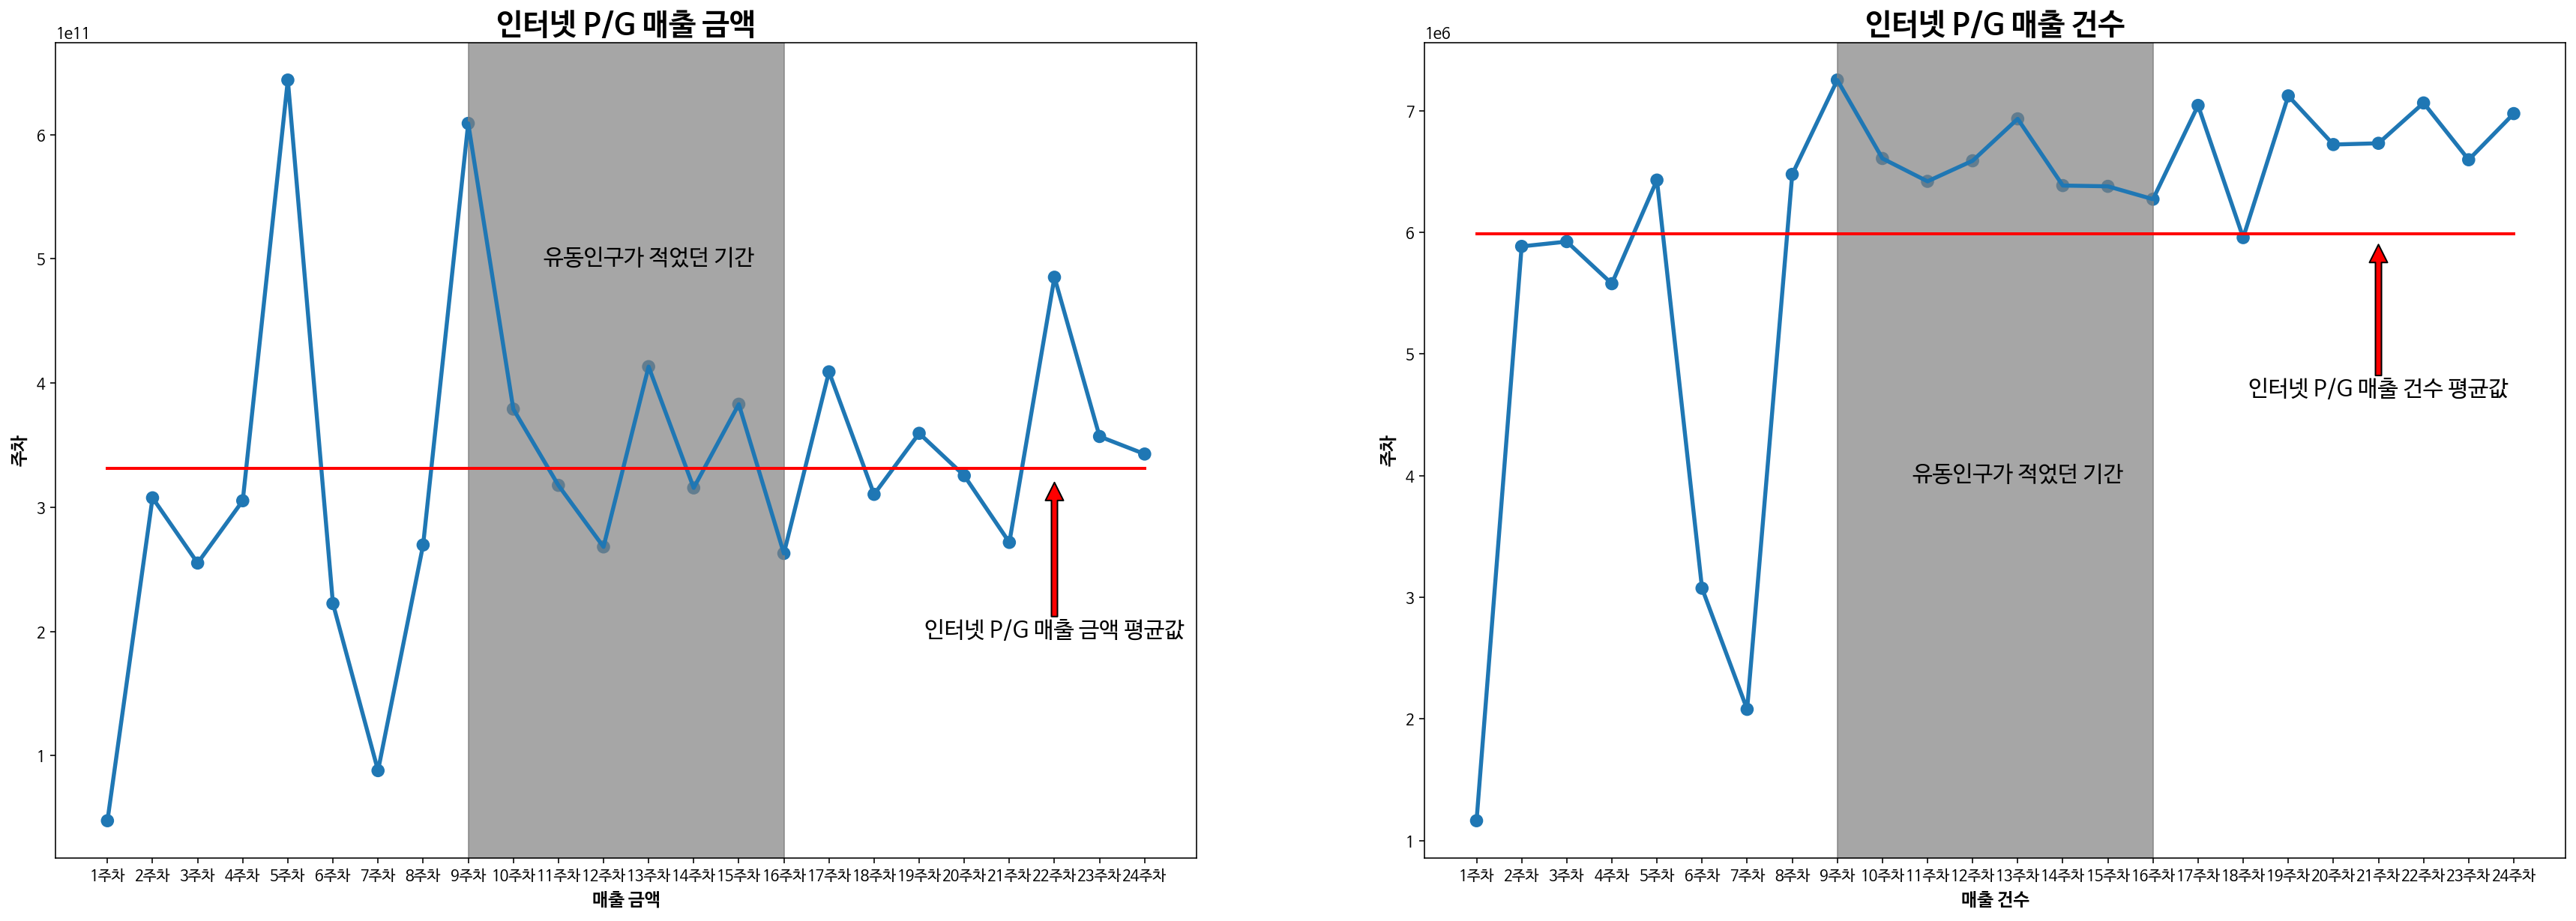

In [31]:
fig, ax = plt.subplots(1,2, figsize = (30,10))

sns.pointplot(x = 'weeks', y = 'salamt', data = card_net_df, ax = ax[0])
ax[0].set_xlabel('매출 금액', fontsize = 12, fontweight = 'bold')
ax[0].set_ylabel('주차', fontsize = 12, fontweight = 'bold')
ax[0].set_title('인터넷 P/G 매출 금액', fontsize = 20, fontweight = 'bold')
ax[0].set_xticklabels([f'{x}주차' for x in np.arange(1,25)])
ax[0].plot([0,23],[card_net_df['salamt'].mean(),card_net_df['salamt'].mean()], color = 'r', linewidth = 2)
ax[0].axvspan(8, 15, color='gray', alpha = 0.7)
ax[0].annotate('유동인구가 적었던 기간', xy = (12, 5e11), xytext = (12, 5e11), va = 'center', ha = 'center', fontsize = 15)
ax[0].annotate('인터넷 P/G 매출 금액 평균값', xy = (21, 3.2e11), xytext = (21, 2e11), va = 'center', ha = 'center', fontsize = 15, arrowprops=dict(facecolor='red'))

sns.pointplot(x = 'weeks', y = 'selng_cascnt', data = card_net.groupby('weeks')[['salamt','selng_cascnt']].sum().reset_index(), ax = ax[1])
ax[1].set_xlabel('매출 건수', fontsize = 12, fontweight = 'bold')
ax[1].set_ylabel('주차', fontsize = 12, fontweight = 'bold')
ax[1].set_title('인터넷 P/G 매출 건수', fontsize = 20, fontweight = 'bold')
ax[1].set_xticklabels([f'{x}주차' for x in np.arange(1,25)])
ax[1].plot([0,23],[card_net_df['selng_cascnt'].mean(),card_net_df['selng_cascnt'].mean()], color = 'r', linewidth = 2)
ax[1].axvspan(8, 15, color='gray', alpha = 0.7)
ax[1].annotate('유동인구가 적었던 기간', xy = (12, 4e6), xytext = (12, 4e6), va = 'center', ha = 'center', fontsize = 15)
ax[1].annotate('인터넷 P/G 매출 건수 평균값', xy = (20,5.9e6), xytext = (20, 4.7e6), va = 'center', ha = 'center', fontsize = 15, arrowprops=dict(facecolor='red'))

fig.show()

**유동인구 수가 줄었던 시점(9주차) 즉, 코로나 확진자가 급격하게 늘어난 시점에 매출 금액과 매출 건수가 높은 값을 기록하였습니다.**   

매출 금액의 경우 바로 다음주에 큰 하락을 보이긴 했지만 앞서 정의 했던 **코로나로 영향을 받은 시점에는 9주차 이전과 비교해보면 비교적 변동이 적은 모습**을 보였습니다.  

매출 건수도 마찬가지였습니다. **매출 건수도 9주차 이전에는 변동이 있는 모습이었지만 코로나로 영향을 받은 시점(9주차)부터는 변동이 적었으며 매출 건수도 매우 높았습니다.**  

**사람들의 코로나에 대한 경각심이 줄어든 시기(16주차 이후)**에 매출 금액과 매출 건수 모두 변동이 적었습니다.  

다만 **코로나로 영향을 받은 시점**부터 **매출 금액**은 매출 건수에 비해 **작은 값을 유지하는 모습**을 보였습니다.

**<font color = 'blue'>1. 9주차 이전까지는 영향이 심했다는 점**  
**2. 코로나의 영향이 큰 시점에 변동이 적었다는 점**  
**3. 코로나의 영향이 큰 시점이 끝나고 경각심이 줄어든 시점에도 매출 금액과 매출 건수가 변동이 적었다는 점</font>**  

**<font color = 'red'>위와 같은 이유로 인터넷 P/G가 포스트 코로나 시대에 유망한 산업으로 예상하였습니다.</font>**

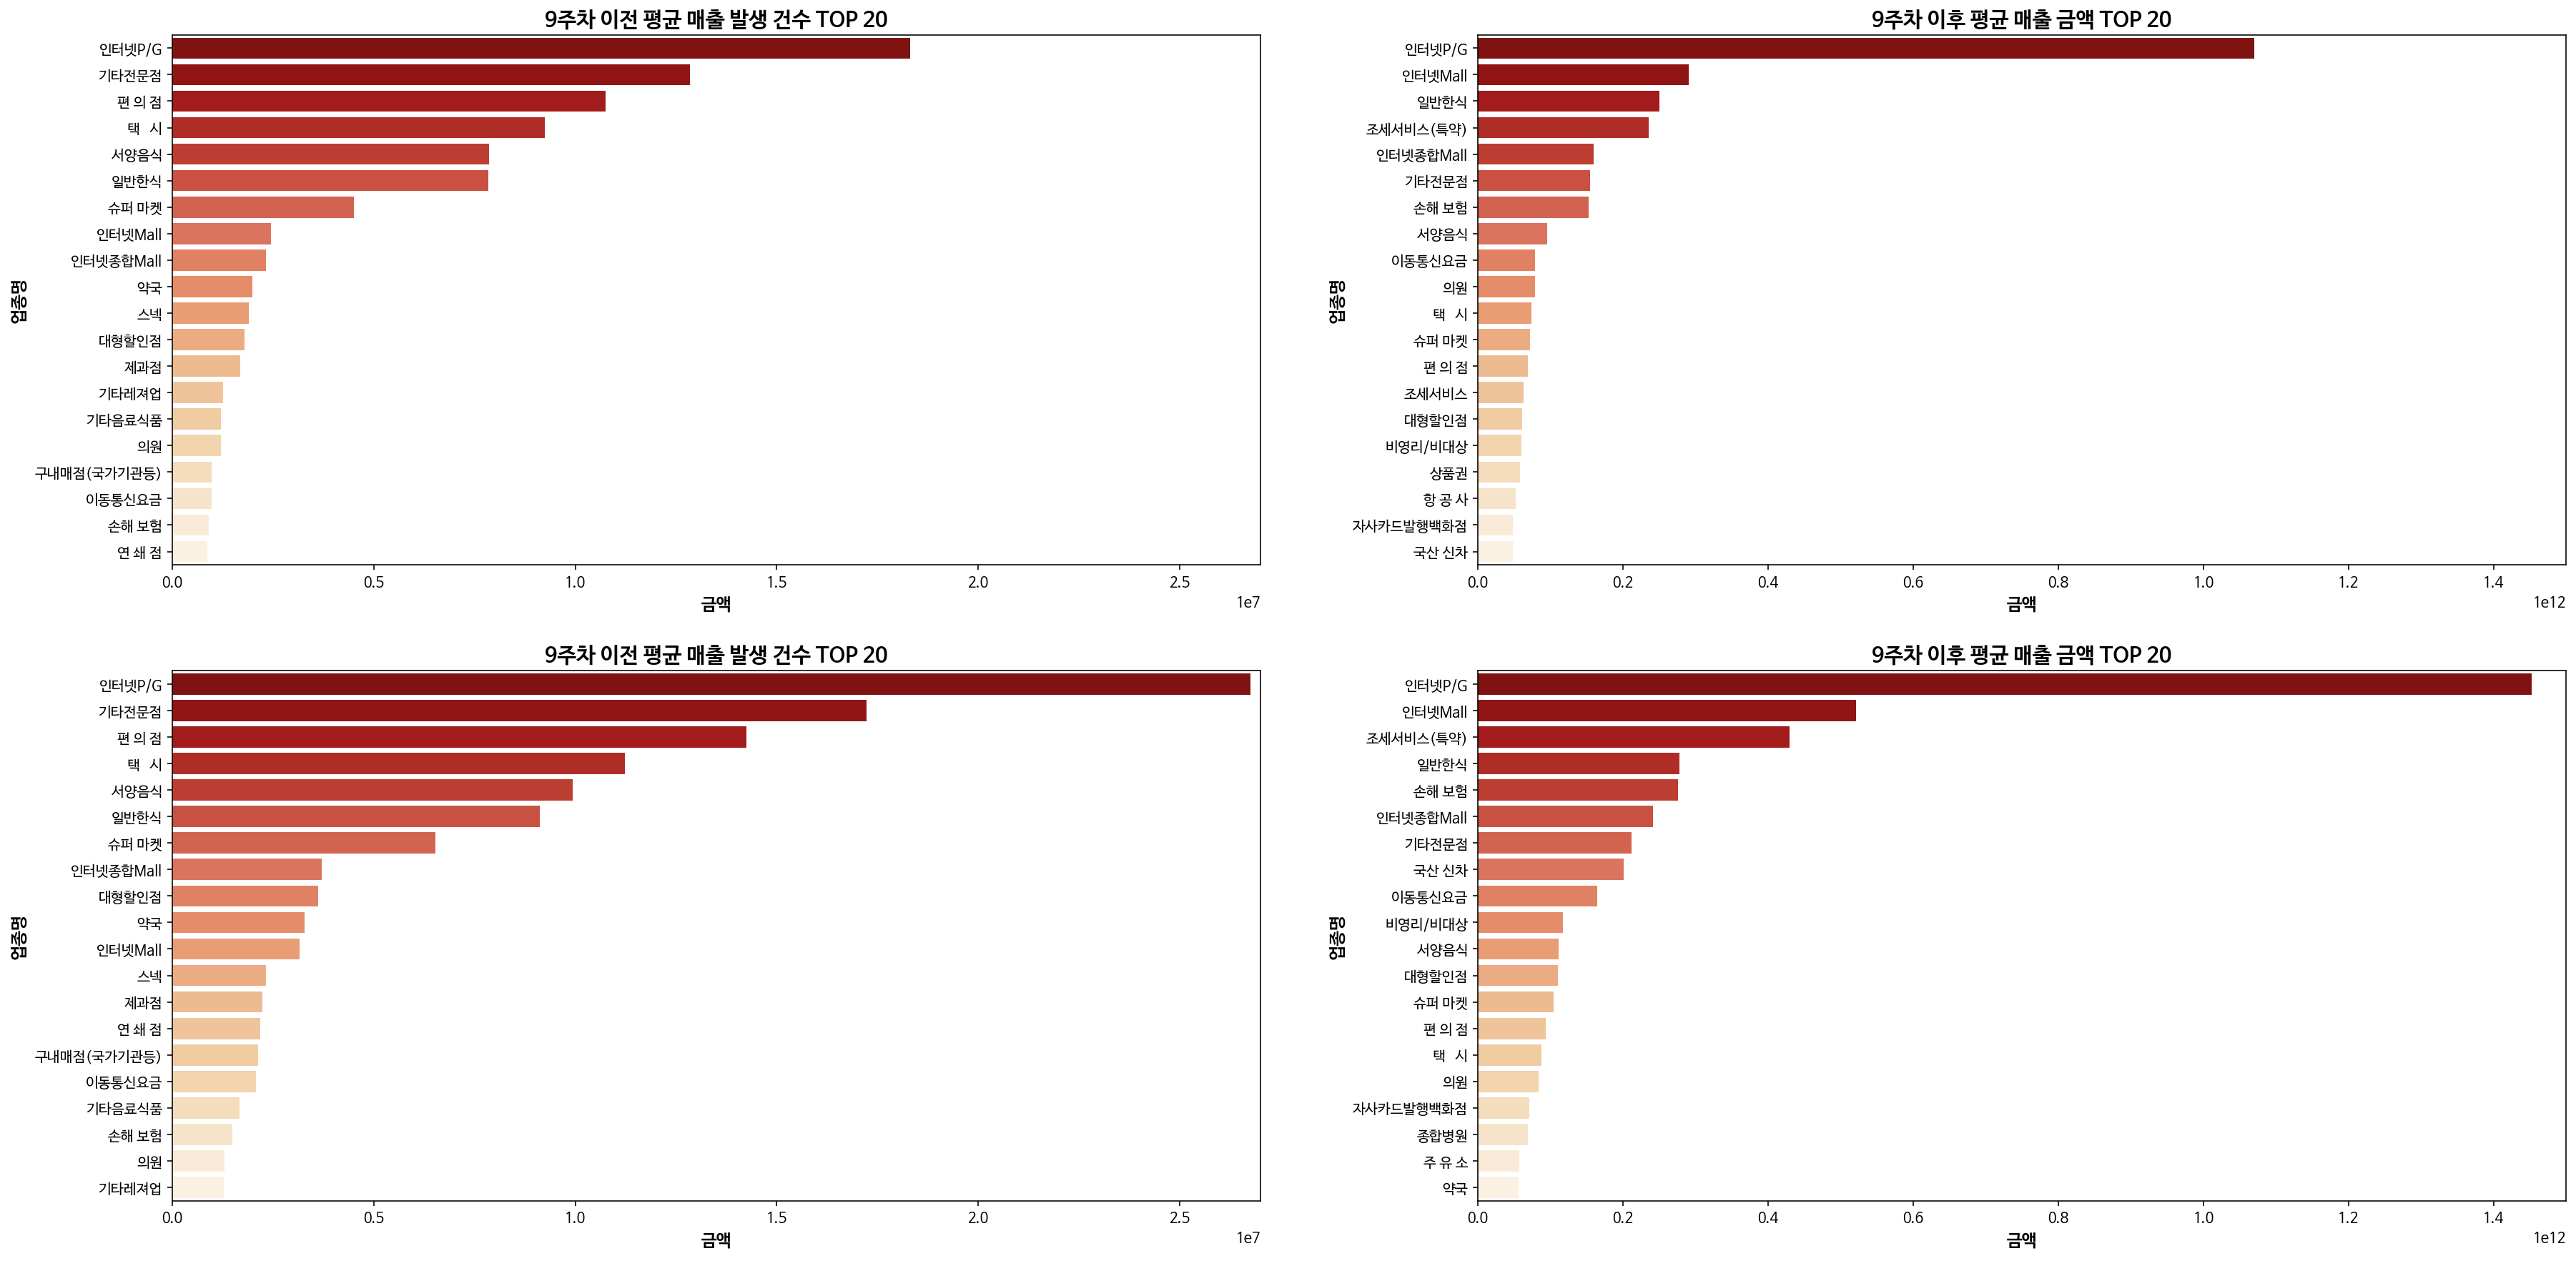

In [32]:
fig, ax = plt.subplots(2,2, figsize = (30,15))

sns.barplot(x = card_pre_count.values[:20], y = card_pre_count.index[:20], ax = ax[0,0], palette = 'OrRd_r')
sns.barplot(x = card_pre_balance .values[:20], y = card_pre_balance .index[:20], ax = ax[0,1], palette = 'OrRd_r')
ax[0,0].set_xlabel('금액', fontweight = 'bold', fontsize = 12)
ax[0,0].set_ylabel('업종명', fontweight = 'bold', fontsize = 12)
ax[0,0].set_title('9주차 이전 평균 매출 발생 건수 TOP 20', fontsize = 15, fontweight = 'bold')
ax[0,0].set_xlim(0, 2.7e+7)

ax[0,1].set_xlabel('금액', fontweight = 'bold', fontsize = 12)
ax[0,1].set_ylabel('업종명', fontweight = 'bold', fontsize = 12)
ax[0,1].set_title('9주차 이후 평균 매출 금액 TOP 20', fontsize = 15, fontweight = 'bold')
ax[0,1].set_xlim(0, 1.5e+12)

sns.barplot(x = card_pos_count.values[:20], y = card_pos_count.index[:20], ax = ax[1,0], palette = 'OrRd_r')
sns.barplot(x = card_pos_balance.values[:20], y = card_pos_balance.index[:20], ax = ax[1,1], palette = 'OrRd_r')
ax[1,0].set_xlabel('금액', fontweight = 'bold', fontsize = 12)
ax[1,0].set_ylabel('업종명', fontweight = 'bold', fontsize = 12)
ax[1,0].set_title('9주차 이전 평균 매출 발생 건수 TOP 20', fontsize = 15, fontweight = 'bold')
ax[1,0].set_xlim(0, 2.7e+7)

ax[1,1].set_xlabel('금액', fontweight = 'bold', fontsize = 12)
ax[1,1].set_ylabel('업종명', fontweight = 'bold', fontsize = 12)
ax[1,1].set_title('9주차 이후 평균 매출 금액 TOP 20', fontsize = 15, fontweight = 'bold')
ax[1,1].set_xlim(0, 1.5e+12)

fig.show()

9주차 이전과 9주차 이후로 구분을 하여 카드 평균 매출 금액과 카드 평균 매출 건수를 보았습니다.  

**다른 업종들도 9주차 이전에비해 9주차 이후에 평균 매출 금액과 평균 매출 건수가 오르긴 하였지만 인터넷 P/G가 눈에 띄게 늘어난 것을 볼 수 있습니다.**  

**또한 9주차 이전과 9주차 이후에 업종의 순위가 변동이 많이 없다는 점도 발견하였습니다.**

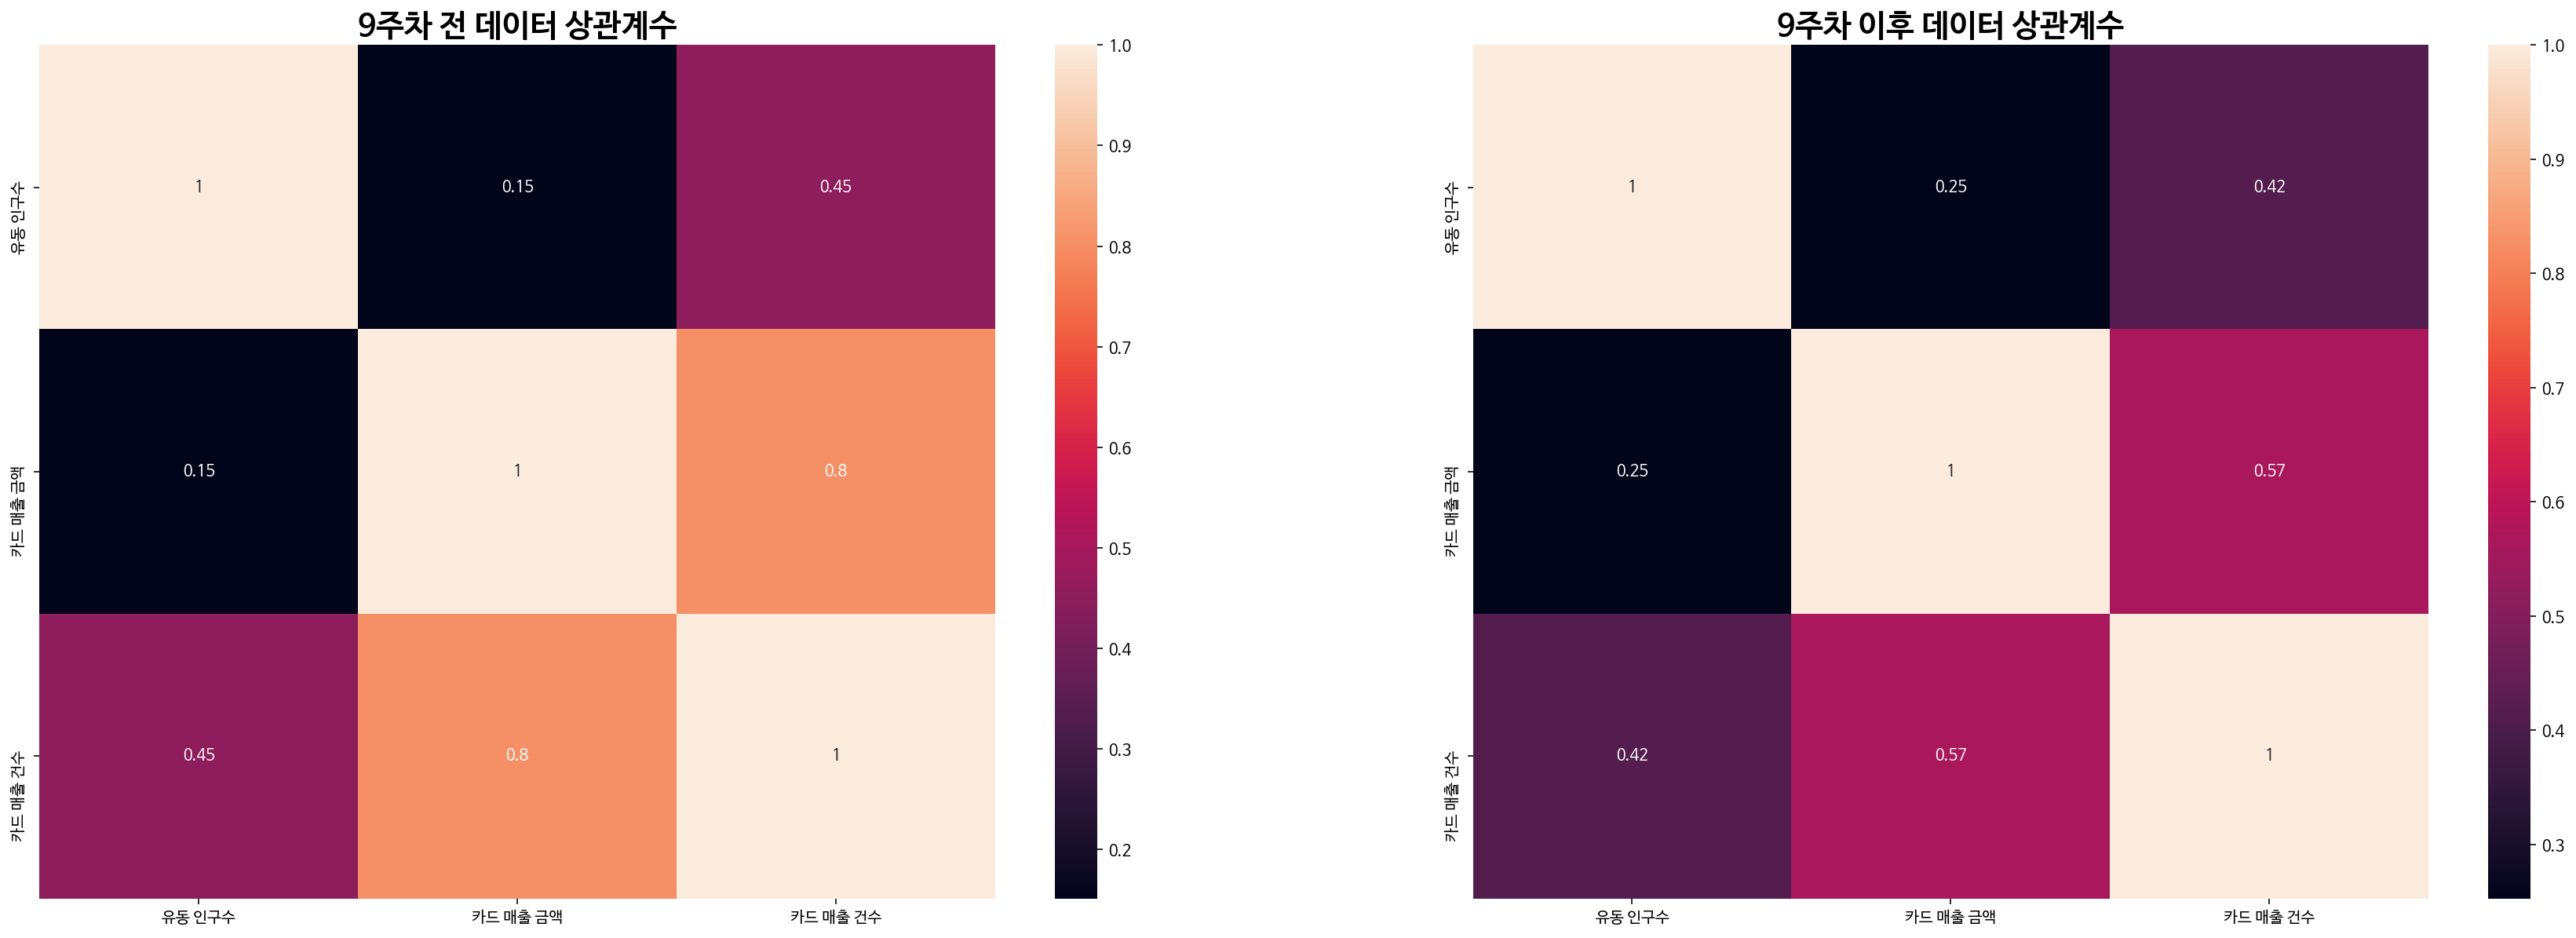

In [33]:
corr_df1 = pd.merge(fpopl_gr.loc[fpopl_gr['weeks'] <= 9].copy(), card_net_df.loc[card_net_df['weeks'] <= 9].copy(), on = 'weeks')
scaler_corr = MinMaxScaler()
fit_corr = scaler_corr.fit(corr_df1[['popltn_cascnt','salamt','selng_cascnt']])
output_corr = fit_corr.transform(corr_df1[['popltn_cascnt','salamt','selng_cascnt']])
corr_df1[['popltn_cascnt','salamt','selng_cascnt']] = output_corr
corr_df1.columns = ['주차','유동 인구수','카드 매출 금액','카드 매출 건수']

corr_df2 = pd.merge(fpopl_gr.loc[fpopl_gr['weeks'] > 9], card_net_df.loc[card_net_df['weeks'] > 9], on = 'weeks')
scaler_corr2 = MinMaxScaler()
fit_corr2 = scaler_corr2.fit(corr_df2[['popltn_cascnt','salamt','selng_cascnt']])
output_corr2 = fit_corr2.transform(corr_df2[['popltn_cascnt','salamt','selng_cascnt']])
corr_df2[['popltn_cascnt','salamt','selng_cascnt']] = output_corr2
corr_df2.columns = ['주차','유동 인구수','카드 매출 금액','카드 매출 건수']

fig, ax = plt.subplots(1,2, figsize = (30,10))
sns.heatmap(corr_df1[['유동 인구수','카드 매출 금액','카드 매출 건수']].corr(), annot=True, ax = ax[0])
ax[0].set_title('9주차 전 데이터 상관계수', fontsize = 20, fontweight = 'bold')

sns.heatmap(corr_df2[['유동 인구수','카드 매출 금액','카드 매출 건수']].corr(), annot=True, ax = ax[1])
ax[1].set_title('9주차 이후 데이터 상관계수', fontsize = 20, fontweight = 'bold')

fig.show()

**카드 매출 금액과 카드 매출 건수의 상관계수가 0.8에서 0.57로 눈에 띄게 하락하였습니다.**  

**그 이유로 '인터넷P/G 매출 건수', '인터넷P/G 매출 금액' 그래프에서 인터넷P/G의 매출 건수가 높은 값을 기록하고 매출 금액은 비교적 적었기 때문이라고 예상했습니다.**   

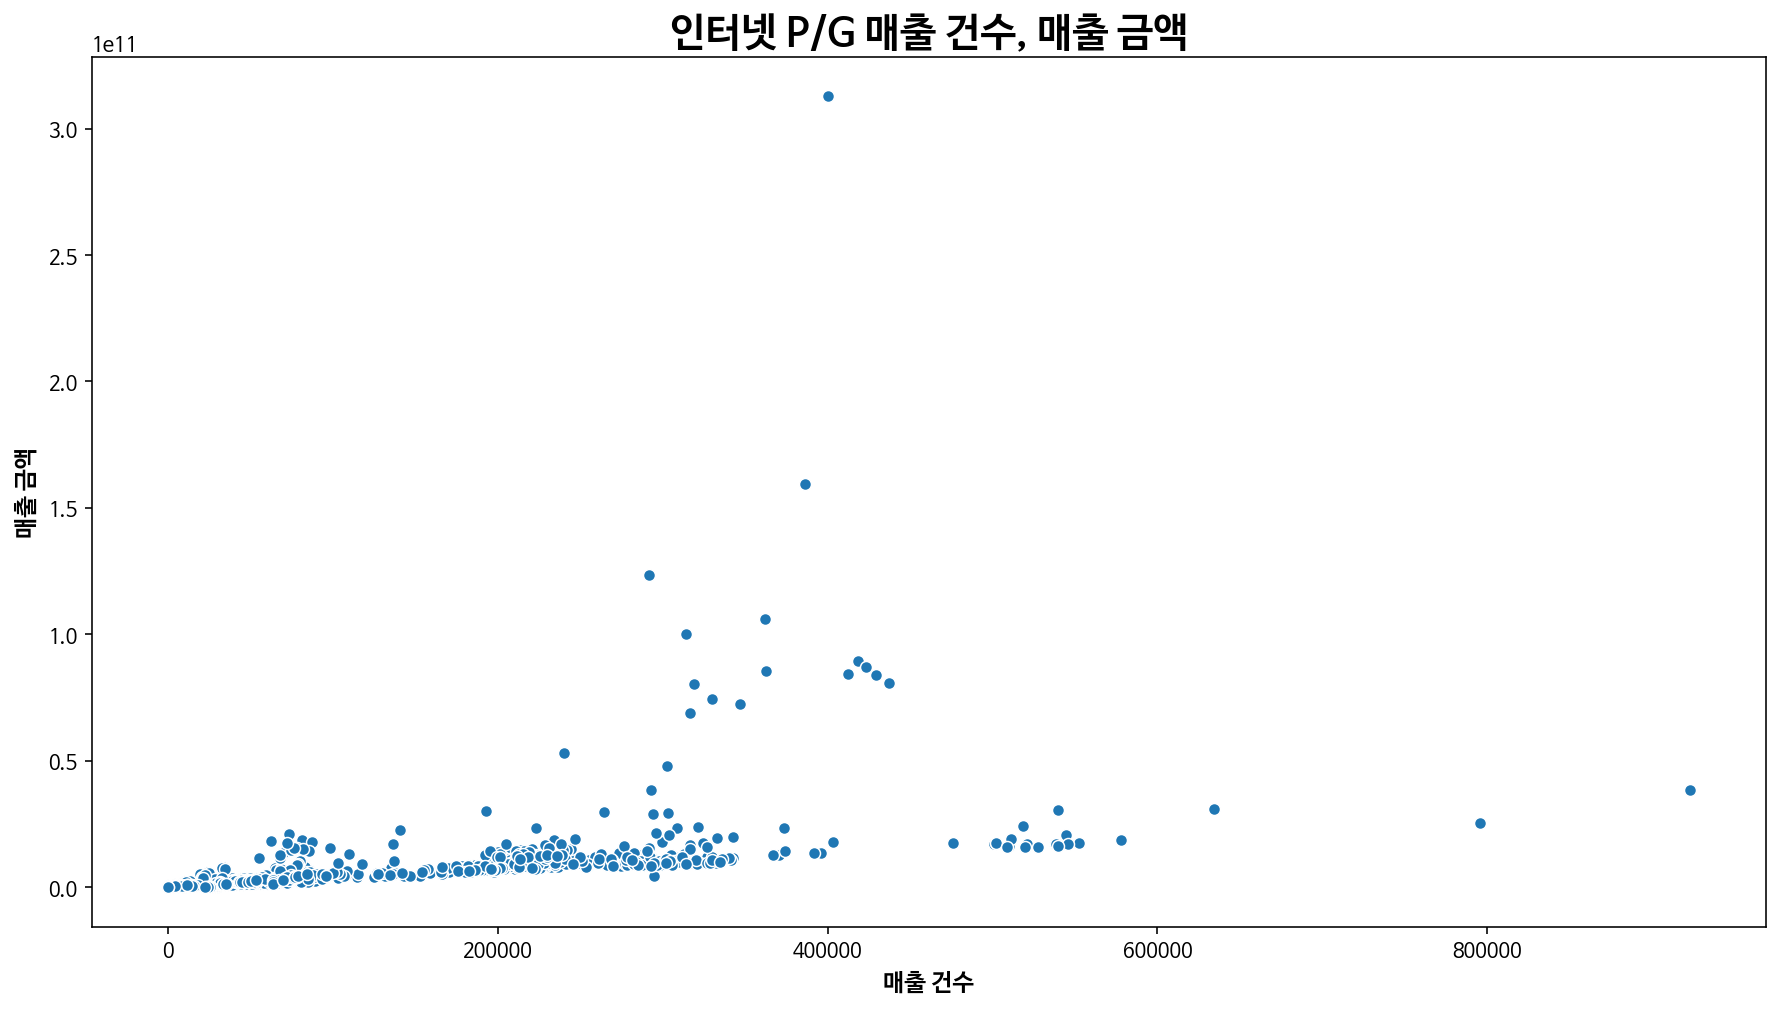

In [34]:
fig = plt.figure(figsize = (15,8))
ax = sns.scatterplot(x = 'selng_cascnt', y = 'salamt', data = card_net)
plt.xlabel('매출 건수', fontsize = 12, fontweight = 'bold')
plt.ylabel('매출 금액', fontsize = 12, fontweight = 'bold')
plt.title('인터넷 P/G 매출 건수, 매출 금액', fontsize = 20, fontweight = 'bold')
fig.show()

인터넷 P/G의 산점도를 통해 파악한 소비 형태는 **매출 건수는 많고 그에 비해 매출 금액이 작다는 것**이였습니다.  

<font color = 'blue'>**1. 9주차 이후 인터넷P/G의 월별 매출 금액, 매출 건수가 늘어난 것**  
**2. 9주차 이후 상관계수가 눈에 띄게 하락**하였다는 점  
**3. 9주차 이후 매출 금액이 매출 건수가 비교적 적었다는 점**</font>  

위 세가지 근거를 통해 사람들이 좀 더 인터넷을 통해 **<font color = 'red'>비교적 더 싼 물건의 소비를 하였다고 예상하였습니다.</font>**  

## Delivery 데이터 확인

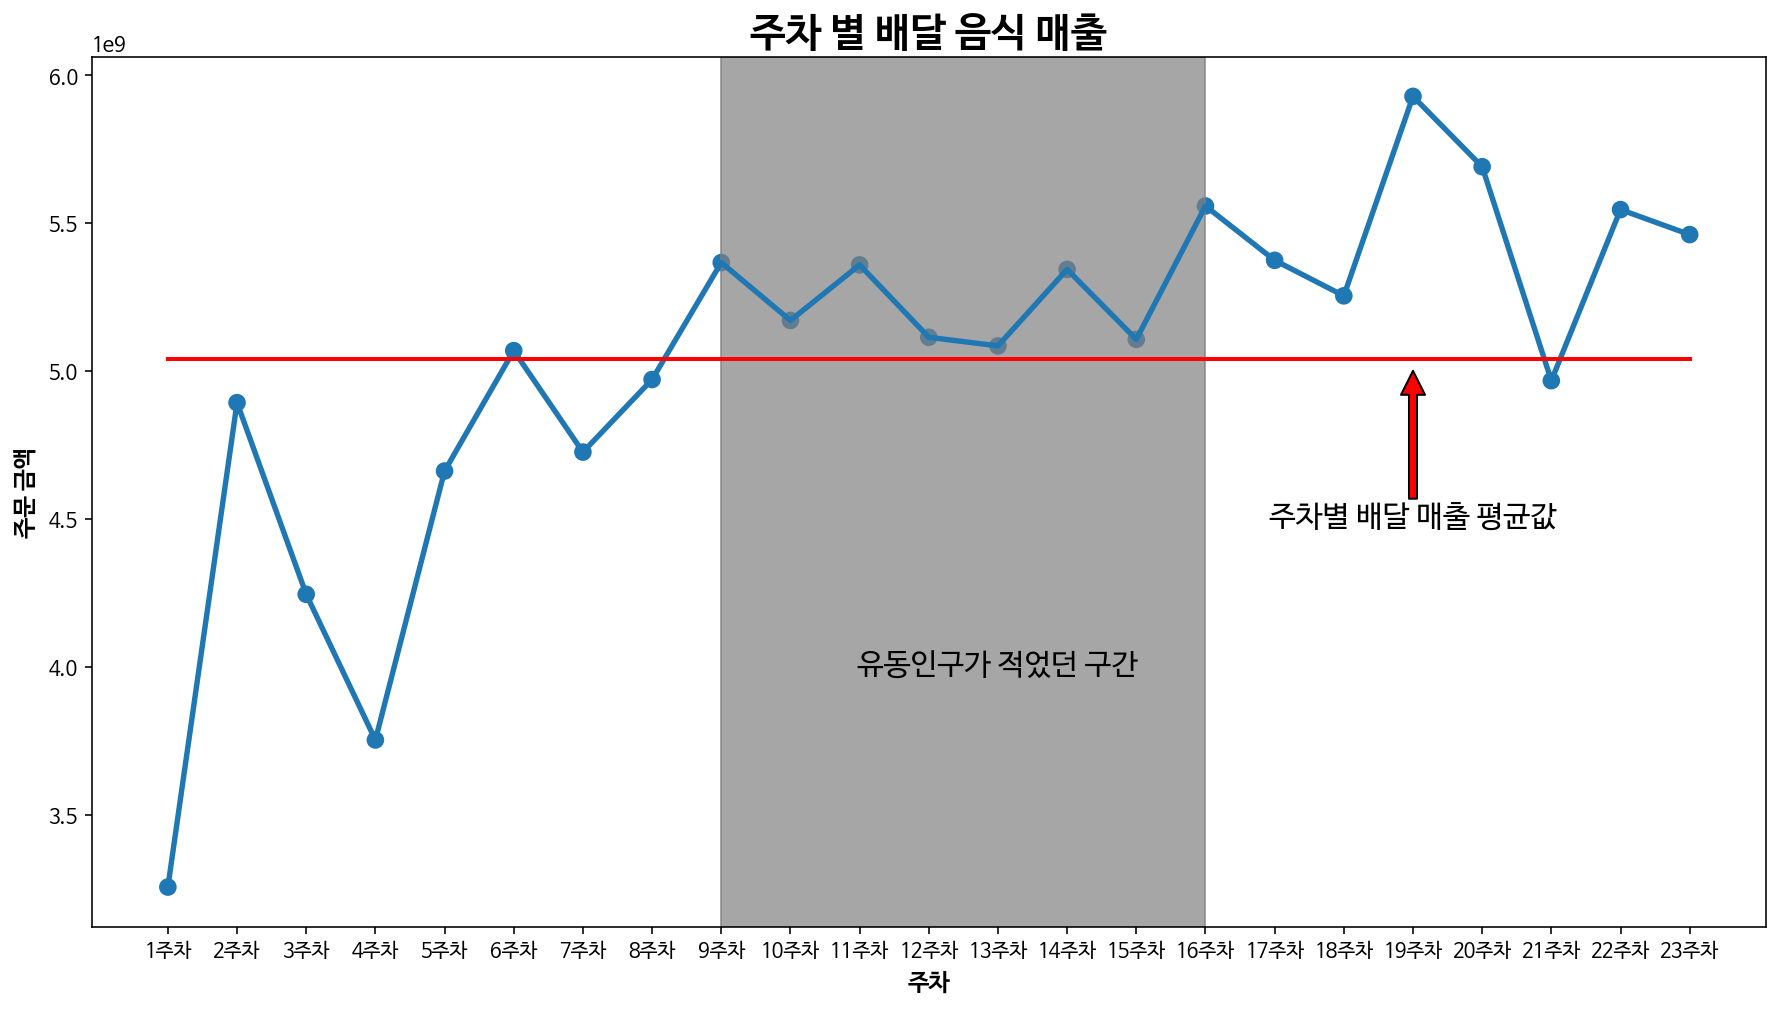

In [35]:
fig = plt.figure(figsize = (15,8))
ax = sns.pointplot(x = 'weeks', y = 'GOODS_AMOUNT', data = weeks_amount, ci = False)
plt.plot([0,22],[weeks_amount['GOODS_AMOUNT'].mean(), weeks_amount['GOODS_AMOUNT'].mean()], color = 'r', linewidth=2)
plt.title('주차 별 배달 음식 매출', fontsize = 20, fontweight = 'bold')
plt.xlabel('주차', fontsize = 12, fontweight = 'bold')
plt.ylabel('주문 금액', fontsize = 12, fontweight = 'bold')
plt.xticks(np.arange(0,23),[f'{x}주차' for x in np.arange(1,26)])
plt.axvspan(8, 15, color='gray', alpha = 0.7)
ax.annotate('유동인구가 적었던 구간', xy = (12, 4.0e+9), xytext = (12, 4.0e+9), va = 'center', ha = 'center', fontsize = 15)
plt.annotate('주차별 배달 매출 평균값', xy = (18, 5e9), xytext = (18, 4.5e9), va = 'center', ha = 'center', fontsize = 15, arrowprops=dict(facecolor='red'))
fig.show()

**유동 인구가 적었던 초기(9주차)부터 배달 음식의 금액이 평균값을 넘었습니다.**  
**유동 인구가 적었다는 것은 그만큼 사람들이 집에 있었다는 말이기 때문에 배달 음식 매출이 오른 모습입니다.**

**그러나 유동인구가 적었던 구간을 지나고서도 배달 음식의 매출이 높은 수치를 기록하였습니다.**  
**그렇기 때문에 배달 산업을 좀 더 지켜볼만 하다고 생각하였습니다.**

## 정리

- **유동인구 수가 급격히 줄어든 시점은 9주차, 이 시점은 코로나 확진자가 급격히 늘어난 시점입니다.**  
- **유동인구 수의 평균 미만 값을 가진 9주차 ~ 16주차를 유동인구가 적은 시점, 코로나에 영향을 받은 시점으로 지정하였습니다.**  
- **코로나 영향을 받은 시점에 인터넷P/G는 가장 높은 카드 매출 금액, 카드 매출 건수를 기록하였습니다.**  
- **코로나 영향을 받은 시점에 인터넷P/G 데이터는 영향을 받기 이전 시점보다 변동이 적은 모습을 보였습니다.**
- **코로나 영향을 받은 시점에 인터넷P/G는 평균 매출 금액, 매출 건수가 늘어났습니다.**  
- **코로나 영향을 받은 시점 전후로 인터넷P/G의 상관계수와 산점도를 보았을 때 비싼 물건보다는 비교적 값이 싼 물건의 소비가 늘은 것으로 예상하였습니다.**  
- **배달 금액도 코로나 영향을 받은 시점에 매출이 올랐습니다.**  
- **코로나 영향을 받은 시점 이후 사람들이 코로나의 경각심이 줄어든 시기에도 인터넷P/G와 배달 금액은 안정적인 매출을 보여준 것으로 보아 포스트 코로나 시대에도 기대가 되는 업종으로 보였습니다.**

# 군집분석(군집으로 보는 소비패턴)

In [36]:
card_count = card.groupby('mrhst_induty_cl_nm')['selng_cascnt'].sum().sort_values(ascending = False)
card_balance = card.groupby('mrhst_induty_cl_nm')['salamt'].sum().sort_values(ascending = False)

card_covid = card.loc[card['weeks'] <= 9].groupby('mrhst_induty_cl_nm')[['selng_cascnt','salamt']].sum()
card_post = card.loc[card['weeks'] > 9].groupby('mrhst_induty_cl_nm')[['selng_cascnt','salamt']].sum()

card_covid_nus = ((card_post['salamt'] / card_post['selng_cascnt']) - (card_covid['salamt'] / card_covid['selng_cascnt'])).sort_values(ascending = False)
card_covid_nus = card_covid_nus.reset_index()
card_covid_nus.columns = ['type','balance']

card_count = card_count.reset_index()
card_count.columns = ['type', 'selng_cascnt']

card_balance = card_balance.reset_index()
card_balance.columns = ['type', 'salamt']

card_count['selng_rank'] = np.arange(1,card_count.shape[0]+1)
card_balance['salamt_rank'] = np.arange(1,card_balance.shape[0]+1)

card_covid_nus = card_covid_nus.sort_values(['balance'],ascending = False)
card_covid_nus['balance_rank'] = np.arange(1,card_covid_nus.shape[0]+1)

# 인터넷P/G는 매출 금액, 매출 건수 모두 매우 높은 수치를 가지고 있으므로 우선 제외
card_count = card_count.loc[card_count['type'] != '인터넷P/G'].copy()
card_balance = card_balance.loc[card_balance['type'] != '인터넷P/G'].copy()
card_covid_nus = card_covid_nus.loc[card_covid_nus['type'] != '인터넷P/G'].copy()

card_fin = pd.merge(card_count,card_balance, on = 'type')
card_fin = pd.merge(card_fin, card_covid_nus, on = 'type')

In [37]:
scaler = RobustScaler()
fitted = scaler.fit(card_fin[['selng_cascnt','salamt','balance']])
output = scaler.transform(card_fin[['selng_cascnt','salamt','balance']])
card_fin[['selng_cascnt','salamt','balance']] = output
card_fin.dropna(inplace = True)
tsne_output = TSNE(learning_rate=100, random_state = 20).fit_transform(card_fin[['selng_cascnt','salamt','balance']])

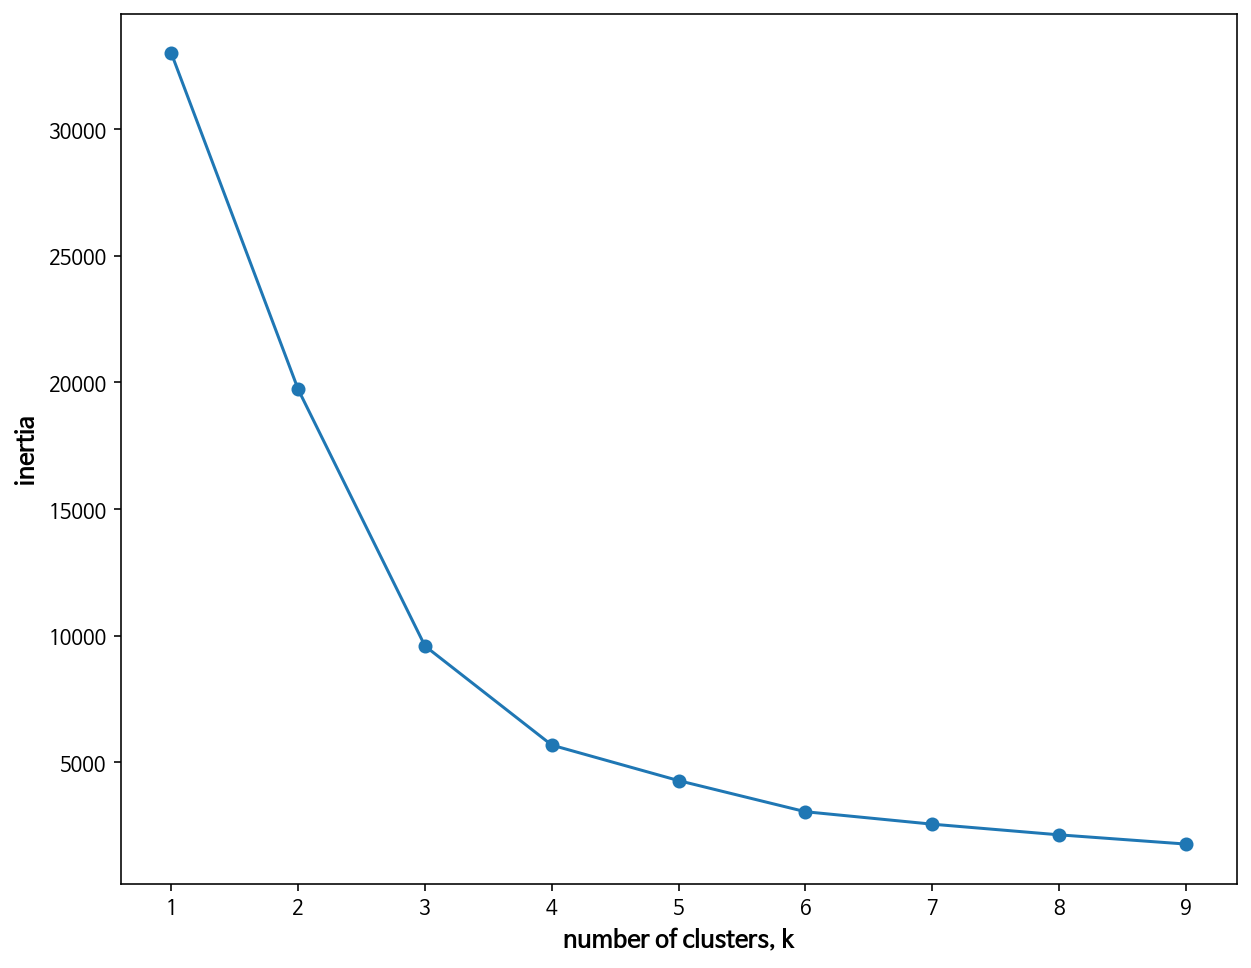

In [38]:
num = range(1,10)
inertias = []
for k in num:
    model = KMeans(n_clusters=k, random_state = 200)
    model.fit(tsne_output)
    inertias.append(model.inertia_)

fig = plt.figure(figsize = (10,8))
plt.plot(num, inertias, '-o')
plt.xlabel('number of clusters, k', fontsize = 12, fontweight = 'bold')
plt.ylabel('inertia', fontsize = 12, fontweight = 'bold')
plt.xticks(num)
fig.show()

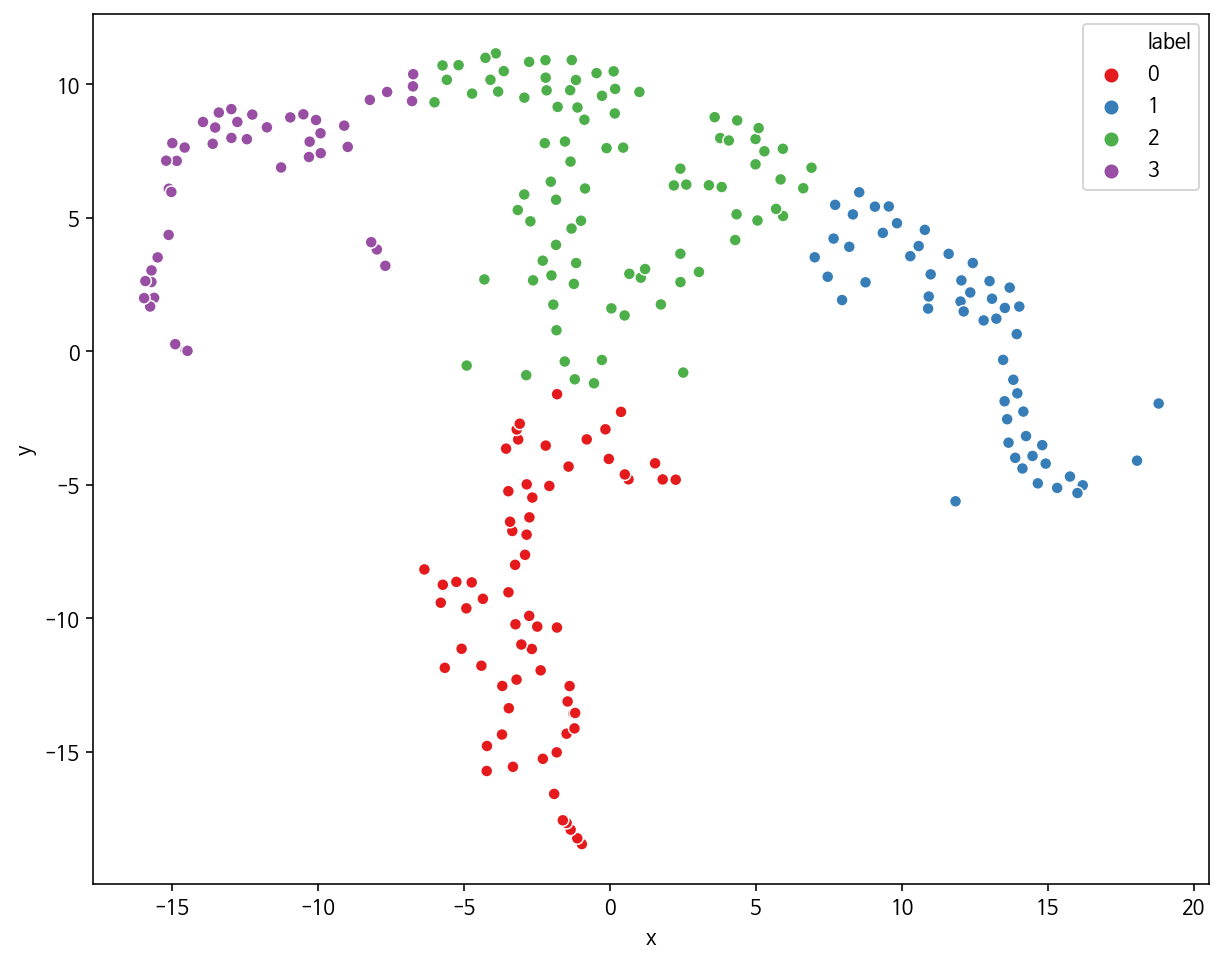

In [39]:
Kmean = KMeans(n_clusters=4, random_state = 200)
Kmean.fit(tsne_output)
labels = Kmean.labels_
card_fin['labels'] = labels
group_tsne = pd.DataFrame({'x' : tsne_output[:,0],'y' : tsne_output[:,1], 'label':labels})

fig = plt.figure(figsize = (10,8))
ax = sns.scatterplot(x = 'x', y = 'y', data = group_tsne,  hue = 'label', palette = 'Set1')

fig.show()

In [40]:
card_group_0 = card_fin.loc[card_fin['labels'] == 0][['selng_cascnt','selng_rank','salamt','salamt_rank','balance','balance_rank']].mean().reset_index()
card_group_0.columns = ['type','group0']

card_group_1 = card_fin.loc[card_fin['labels'] == 1][['selng_cascnt','selng_rank','salamt','salamt_rank','balance','balance_rank']].mean().reset_index()
card_group_1.columns = ['type','group1']

card_group_2 = card_fin.loc[card_fin['labels'] == 2][['selng_cascnt','selng_rank','salamt','salamt_rank','balance','balance_rank']].mean().reset_index()
card_group_2.columns = ['type','group2']

card_group_3 = card_fin.loc[card_fin['labels'] == 3][['selng_cascnt','selng_rank','salamt','salamt_rank','balance','balance_rank']].mean().reset_index()
card_group_3.columns = ['type','group3']

#card_group_4 = card_fin.loc[card_fin['labels'] == 4][['selng_cascnt','selng_rank','salamt','salamt_rank','balance','balance_rank']].mean().reset_index()
#card_group_4.columns = ['type','group3']

mg1 = pd.merge(card_group_0,card_group_1, on = 'type')
mg2 = pd.merge(mg1, card_group_2, on = 'type')
card_group = pd.merge(mg2, card_group_3, on = 'type')
#card_group = pd.merge(mg2, card_group, on = 'type')
card_group['type'] = ['매출 건수','매출 건수 평균 순위','매출 금액','매출 금액 평균 순위','9주차 전후 평균 금액 변화율','9주차 전후 평균 금액 변화율 순위']

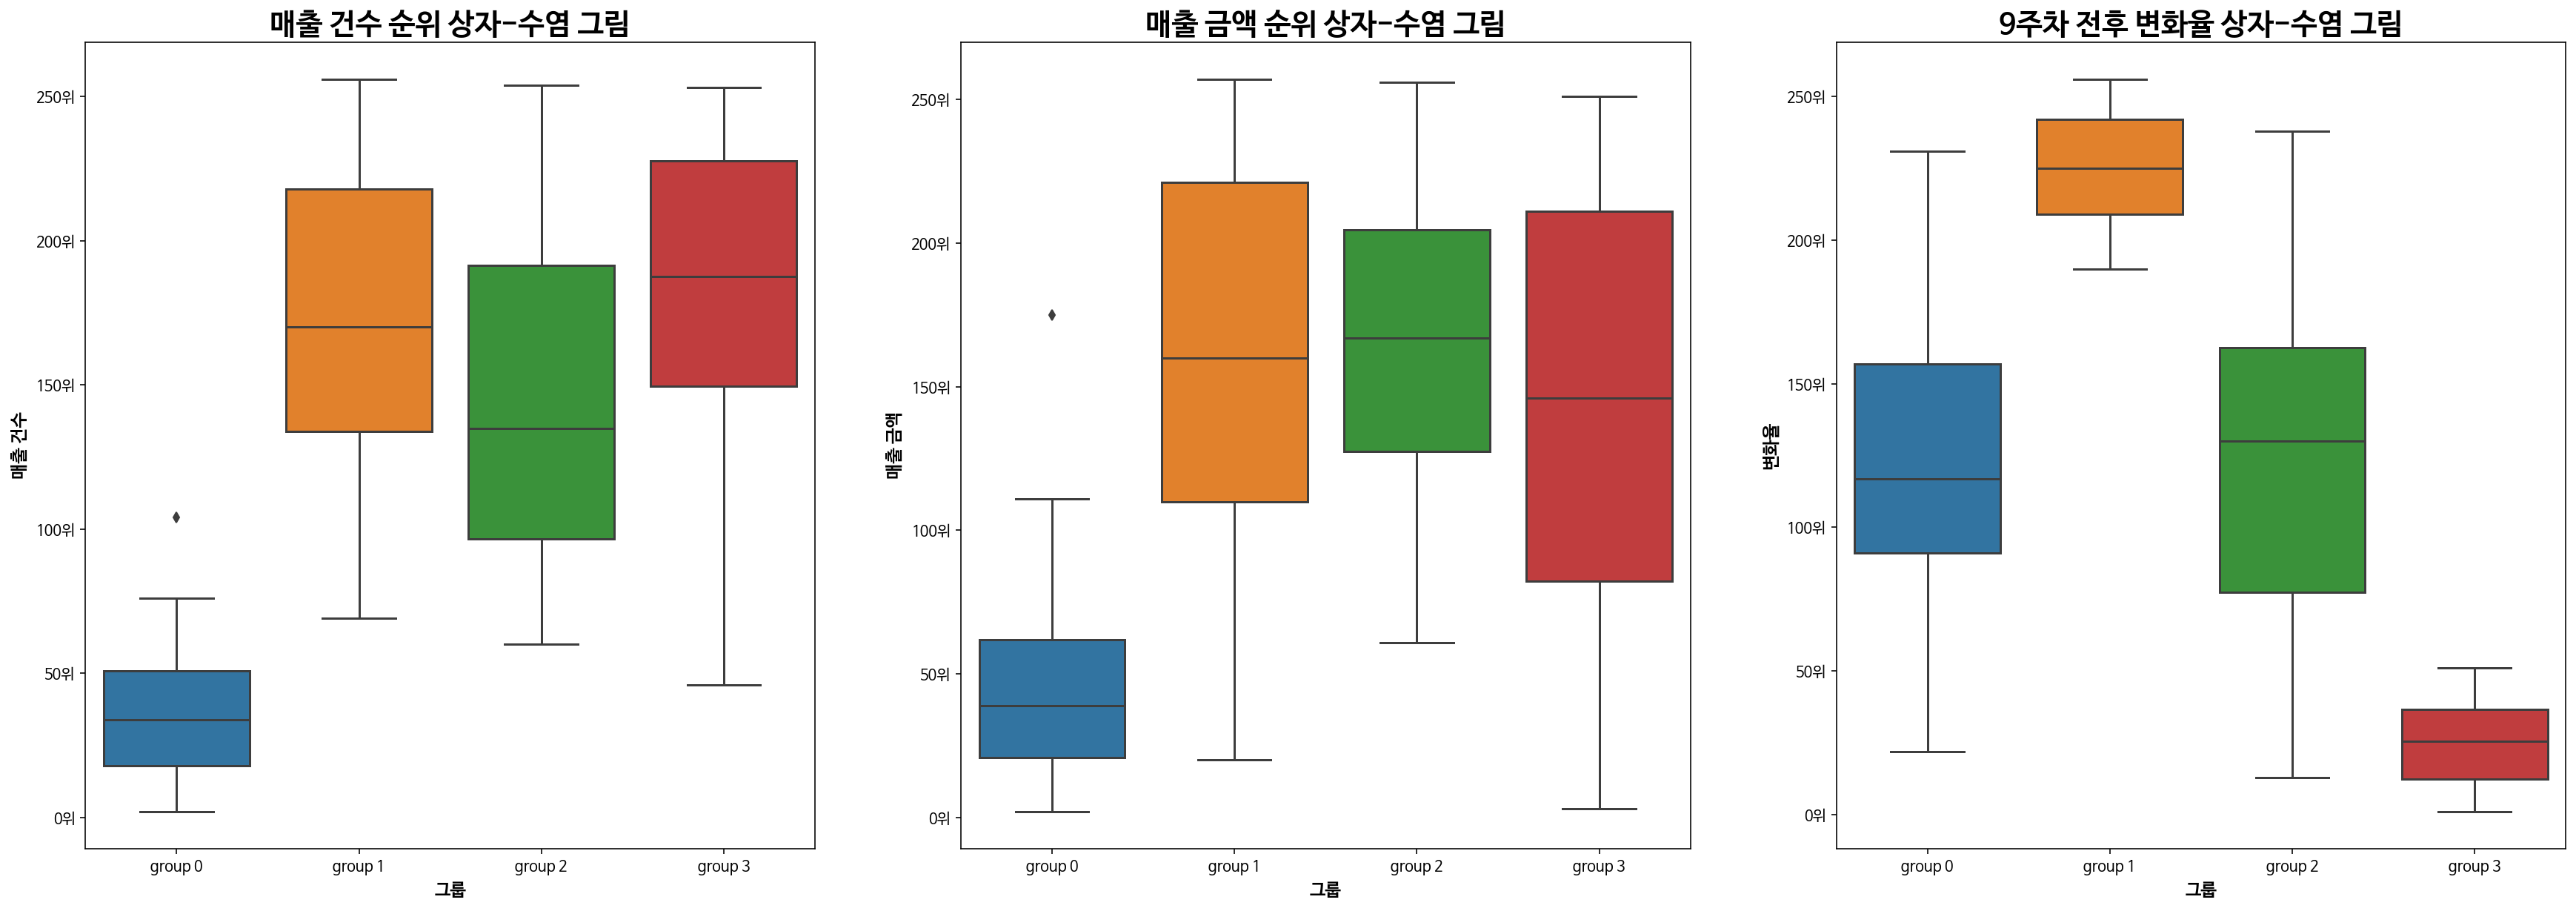

In [41]:
fig, ax = plt.subplots(1,3, figsize = (30,10))

sns.boxplot(x='labels', y = 'selng_rank', data = card_fin, ax = ax[0]) 
ax[0].set_title('매출 건수 순위 상자-수염 그림',fontsize = 20, fontweight = 'bold')
ax[0].set_xlabel('그룹', fontsize = 12, fontweight = 'bold')
ax[0].set_ylabel('매출 건수', fontsize = 12, fontweight = 'bold')
ax[0].set_xticklabels(['group 0','group 1','group 2','group 3'])
ax[0].set_yticklabels(['','0위','50위','100위','150위','200위','250위'])

sns.boxplot(x='labels', y = 'salamt_rank', data = card_fin, ax = ax[1])
ax[1].set_title('매출 금액 순위 상자-수염 그림',fontsize = 20, fontweight = 'bold')
ax[1].set_xlabel('그룹', fontsize = 12, fontweight = 'bold')
ax[1].set_ylabel('매출 금액', fontsize = 12, fontweight = 'bold')
ax[1].set_xticklabels(['group 0','group 1','group 2','group 3'])
ax[1].set_yticklabels(['','0위','50위','100위','150위','200위','250위'])

sns.boxplot(x='labels', y = 'balance_rank', data = card_fin, ax = ax[2])
ax[2].set_title('9주차 전후 변화율 상자-수염 그림',fontsize = 20, fontweight = 'bold')
ax[2].set_xlabel('그룹', fontsize = 12, fontweight = 'bold')
ax[2].set_ylabel('변화율', fontsize = 12, fontweight = 'bold')
ax[2].set_xticklabels(['group 0','group 1','group 2','group 3'])
ax[2].set_yticklabels(['','0위','50위','100위','150위','200위','250위'])

fig.show()

**상자-수염 그림을 보았을때 group 0, group 1,3의 변화율을 제외하면 서로 겹치는 부분이 많이 있기 때문에 그룹별로 명확히 정의하기 위해 25% ~ 75%의 값만 사용하여 그룹화를 하였습니다.**

In [42]:
g0 = card_fin.loc[card_fin['labels'] == 0]
g1 = card_fin.loc[card_fin['labels'] == 1]
g2 = card_fin.loc[card_fin['labels'] == 2]
g3 = card_fin.loc[card_fin['labels'] == 3]
#g4 = card_fin.loc[card_fin['labels'] == 4]

In [43]:
# (g0['salamt_rank'] >= np.percentile(g0['salamt_rank'], 25))&(g0['salamt_rank'] <= np.percentile(g0['salamt_rank'], 75))&
g0_range = (g0['balance_rank'] >= np.percentile(g0['balance_rank'], 25))&(g0['balance_rank'] <= np.percentile(g0['balance_rank'], 75))
g1_range = (g1['salamt_rank'] >= np.percentile(g1['salamt_rank'], 25))&(g1['salamt_rank'] <= np.percentile(g1['salamt_rank'], 75))&(g1['selng_rank'] >= np.percentile(g1['selng_rank'], 25))&(g1['selng_rank'] <= np.percentile(g1['selng_rank'], 75))
g2_range = (g2['salamt_rank'] >= np.percentile(g2['salamt_rank'], 25))&(g2['salamt_rank'] <= np.percentile(g2['salamt_rank'], 75))&(g2['selng_rank'] >= np.percentile(g2['selng_rank'], 25))&(g2['selng_rank'] <= np.percentile(g2['selng_rank'], 75))&(g2['balance_rank'] >= np.percentile(g2['balance_rank'], 25))&(g2['balance_rank'] <= np.percentile(g2['balance_rank'], 75))
g3_range = (g3['salamt_rank'] >= np.percentile(g3['salamt_rank'], 25))&(g3['salamt_rank'] <= np.percentile(g3['salamt_rank'], 75))&(g3['selng_rank'] >= np.percentile(g3['selng_rank'], 25))&(g3['selng_rank'] <= np.percentile(g3['selng_rank'], 75))
#g4_range = (g4['balance_rank'] >= np.percentile(g4['balance_rank'], 25))&(g4['balance_rank'] <= np.percentile(g4['balance_rank'], 75))

group_0 = g0.loc[g0_range,:]
group_1 = g1.loc[g1_range,:]
group_2 = g2.loc[g2_range,:]
group_3 = g3.loc[g3_range,:]
#group_4 = g4.loc[g4_range,:]

In [44]:
mg1_g = pd.merge(group_0.mean().reset_index(), group_1.mean().reset_index(), on = 'index')
mg2_g = pd.merge(mg1_g, group_2.mean().reset_index(), on = 'index')
card_group_df = pd.merge(mg2_g, group_3.mean().reset_index(), on = 'index')
#card_group_df = pd.merge(card_group_df, group_4.mean().reset_index(), on = 'index')
card_group_df['index'] = ['매출 건수','매출 건수 평균 순위','매출 금액','매출 금액 평균 순위','9주차 전후 평균 금액 변화율','9주차 전후 평균 금액 변화율 순위','라벨']
card_group_df.columns = ['type','group0','group1','group2','group3']

In [45]:
group_df = pd.concat([group_0,group_1,group_2,group_3])

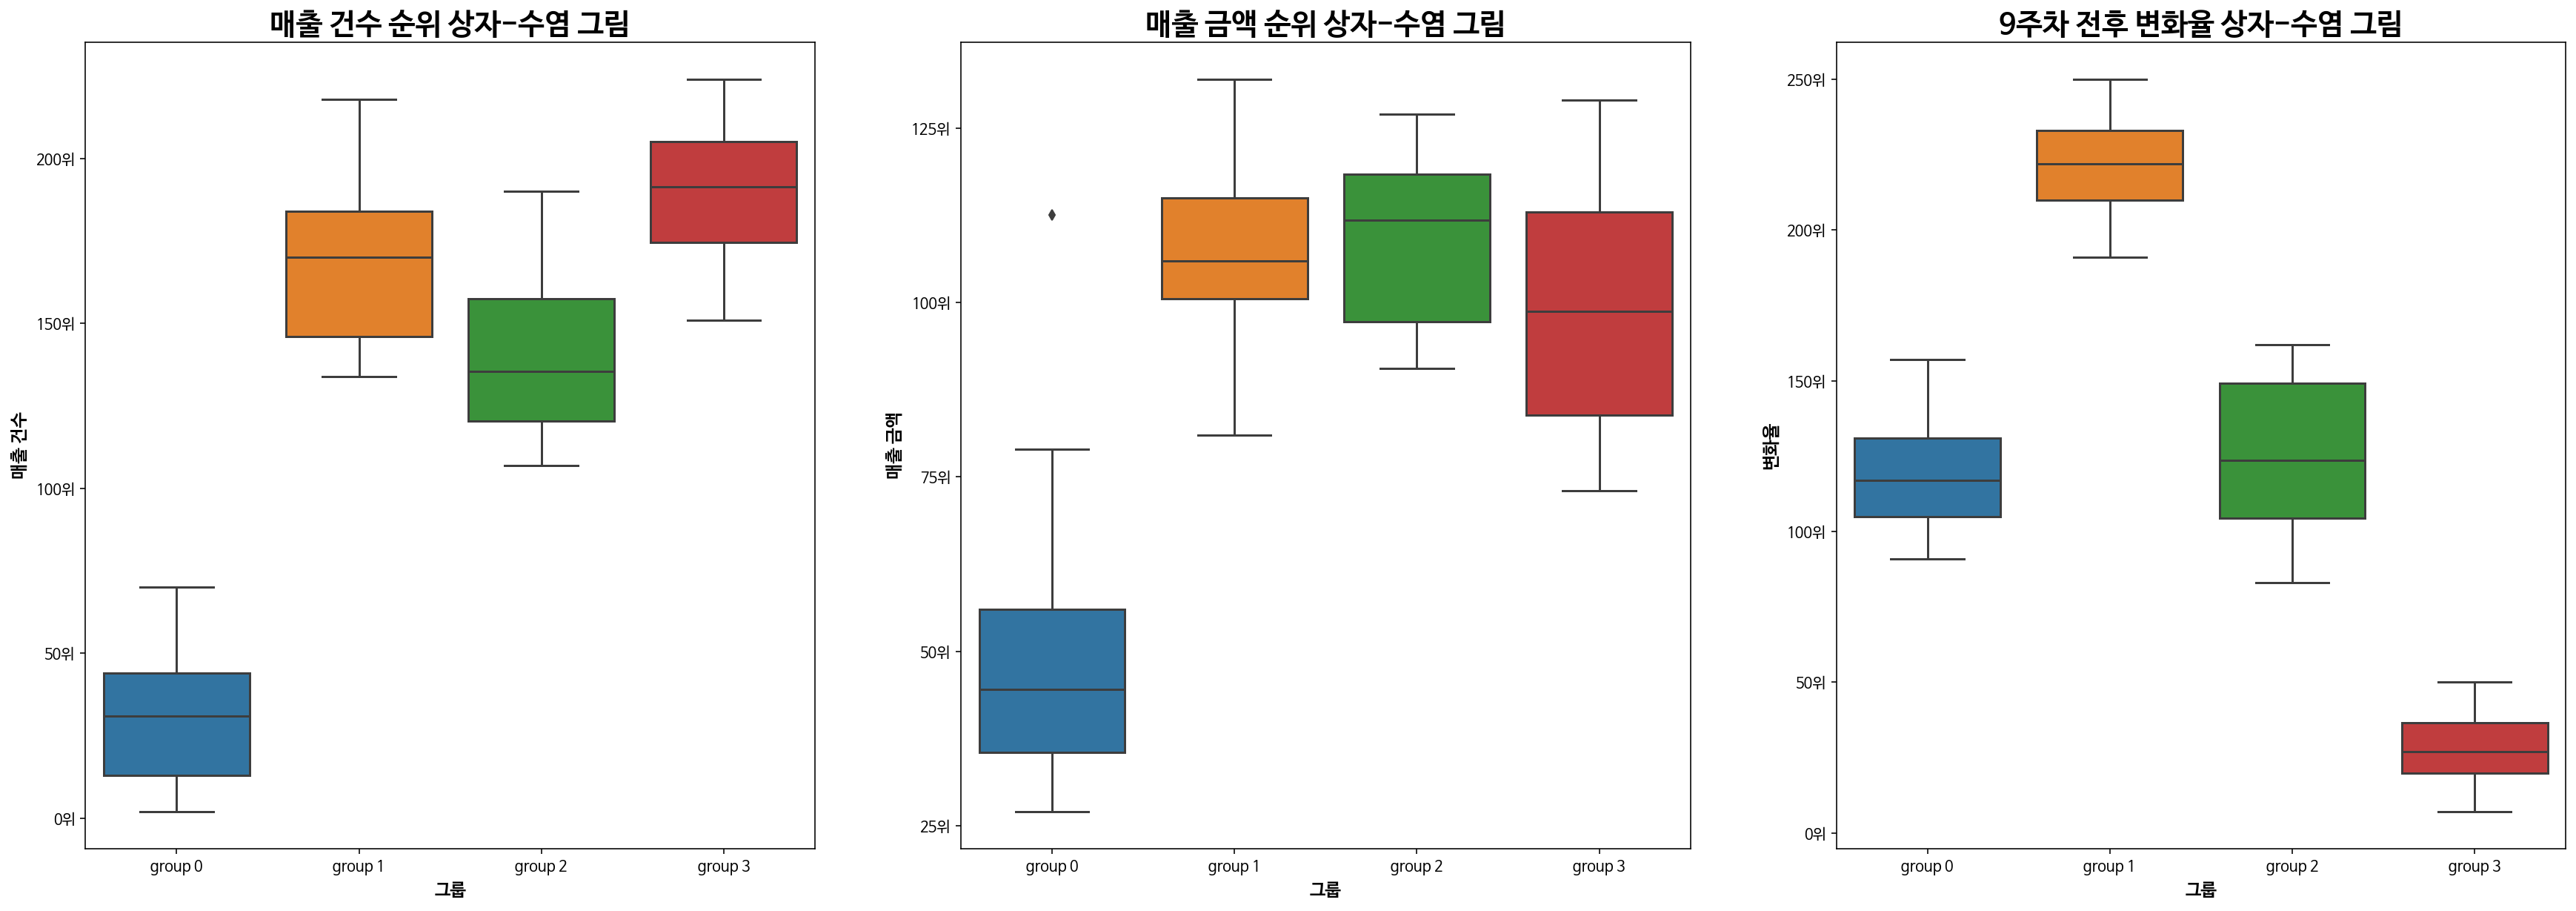

In [46]:
fig, ax = plt.subplots(1,3, figsize = (30,10))

sns.boxplot(x='labels', y = 'selng_rank', data = group_df, ax = ax[0]) 
ax[0].set_title('매출 건수 순위 상자-수염 그림',fontsize = 20, fontweight = 'bold')
ax[0].set_xlabel('그룹', fontsize = 12, fontweight = 'bold')
ax[0].set_ylabel('매출 건수', fontsize = 12, fontweight = 'bold')
ax[0].set_xticklabels(['group 0','group 1','group 2','group 3'])
ax[0].set_yticklabels(['','0위','50위','100위','150위','200위'])

sns.boxplot(x='labels', y = 'salamt_rank', data = group_df, ax = ax[1])
ax[1].set_title('매출 금액 순위 상자-수염 그림',fontsize = 20, fontweight = 'bold')
ax[1].set_xlabel('그룹', fontsize = 12, fontweight = 'bold')
ax[1].set_ylabel('매출 금액', fontsize = 12, fontweight = 'bold')
ax[1].set_xticklabels(['group 0','group 1','group 2','group 3'])
ax[1].set_yticklabels([f'{x}위' for x in np.arange(0,226,25)])

sns.boxplot(x='labels', y = 'balance_rank', data = group_df, ax = ax[2])
ax[2].set_title('9주차 전후 변화율 상자-수염 그림',fontsize = 20, fontweight = 'bold')
ax[2].set_xlabel('그룹', fontsize = 12, fontweight = 'bold')
ax[2].set_ylabel('변화율', fontsize = 12, fontweight = 'bold')
ax[2].set_xticklabels(['group 0','group 1','group 2','group 3'])
ax[2].set_yticklabels(['','0위','50위','100위','150위','200위','250위'])

fig.show()

In [47]:
card_group_df

type      group0      group1      group2      group3
0                매출 건수   26.659991   -0.090222   -0.017351   -0.121739
1          매출 건수 평균 순위   30.666667  168.380952  141.000000  190.125000
2                매출 금액    7.000427   -0.128566   -0.146414   -0.059798
3          매출 금액 평균 순위   46.363636  163.047619  169.333333  149.562500
4     9주차 전후 평균 금액 변화율    0.011129   -2.858728   -0.030879    6.107870
5  9주차 전후 평균 금액 변화율 순위  119.212121  221.238095  124.666667   28.187500
6                   라벨    0.000000    1.000000    2.000000    3.000000

group 0 : 매출 건수 순위가 상, 매출 금액 순위가 상, 큰 변화율이 없는 그룹.  
group 1 : 매출 건수 순위가 중하, 매출 금액 순위가 중하, 변화율(9주차 이전 대비 9주차 이후에 감소)이 큰 그룹  
group 2 : 매출 건수 순위가 중하(group 1 보단 비교적 높은), 매출 금액 순위가 중하, 큰 변화율이 없는 그룹.  
group 3 : 매출 건수 순위가 낮고, 매출 금액 순위가 중 ~ 중하, 변화율(9주차 이전 대비 9주차 이후에 증가)이 큰 그룹  

## 일상생활에 맞닿아있는 재화 및 서비스(group0)

![group0](https://drive.google.com/uc?export=view&id=1Gm-FICk44oXLmfg741X4lqi23iHN3W3_)


In [48]:
group_0 

type  selng_cascnt  selng_rank  ...   balance  balance_rank  labels
0       기타전문점    194.074413           2  ...  0.040083           114       0
2       택   시    129.975753           4  ...  0.092534            91       0
3        서양음식    113.678860           5  ...  0.049323           111       0
4        일반한식    106.866026           6  ...  0.038519           115       0
5       슈퍼 마켓     71.853487           7  ...  0.070215           105       0
6   인터넷종합Mall     39.828976           8  ... -0.112809           148       0
7       대형할인점     36.936059           9  ... -0.097197           146       0
9          약국     34.864450          11  ... -0.169957           150       0
11        제과점     25.190414          13  ...  0.075610            99       0
15     기타음료식품     18.473631          17  ...  0.019378           121       0
17      기타레져업     15.501209          19  ...  0.091577            93       0
19       중국음식     12.090062          21  ...  0.003597           127       0
23      주 차 장      8.880893          25  ...  0.074916           101       0
24       일식회집      8.411619          26  ...  0.018268           122       0
26       종합병원      7.433195          28  ... -0.050168           140       0
28         주점      6.853818          30  ...  0.087216            94       0
29      미 용 원      5.107849          31  ...  0.032851           118       0
31       기타잡화      4.690929          33  ... -0.025390           136       0
32    공공요금/대상      4.492612          34  ...  0.003825           126       0
34      화물 운송      3.987533          36  ...  0.036337           117       0
35    CATV홈쇼핑      3.976909          37  ...  0.086224            95       0
36      문구용 품      3.831856          38  ... -0.003647           129       0
37      고속 버스      3.701124          39  ...  0.037075           116       0
41      위탁급식업      2.776826          43  ...  0.062363           107       0
42      사무서비스      2.685587          44  ... -0.101805           147       0
43    스포츠레져용품      2.638845          45  ... -0.223933           157       0
46        한의원      2.289102          48  ... -0.009260           131       0
47       치과의원      2.235625          49  ...  0.048997           112       0
49   통신판매(일반)      2.047978          51  ...  0.053544           109       0
51        영화관      1.767834          53  ... -0.057383           142       0
62         안경      0.962011          64  ...  0.092162            92       0
64         병원      0.939122          66  ...  0.029803           120       0
68      자동차정비      0.735095          70  ...  0.074389           103       0

[33 rows x 8 columns]

group0의 매출 건수 순위가 최상, 매출 금액 순위가 최상으로 코로나 영향 이후 큰 변화가 없는 그룹이었습니다.  
group0에 해당하는 재화 및 서비스는 주로 일상생활에 맞닿아있었습니다.  

<font color = 'red'>코로나 영향에도 일상생활에 맞닿아있는 것들은 포기하지 못하는 것으로 보입니다.</font>

## 가장 먼저 포기할 수 있는 재화 및 서비스(group1)

![대체 텍스트](https://drive.google.com/uc?export=view&id=1aUePkEUmor5bqql-bFMEF--uHKwEaciL)

In [49]:
group_1 

type  selng_cascnt  selng_rank  ...    balance  balance_rank  labels
132  기타회원제형태업소1     -0.016655         134  ...  -0.966589           203       1
134       주류판매점     -0.023608         136  ...  -1.665846           216       1
138       기념품 점     -0.045841         140  ...  -2.131168           226       1
140        한방병원     -0.047461         142  ...  -1.829329           221       1
141       홍삼 제품     -0.049711         143  ...  -1.195808           209       1
144       1급 호텔     -0.057444         146  ...  -3.638534           233       1
148       가   방     -0.069182         150  ...  -1.197186           210       1
157   안마/스포츠마사지     -0.084195         159  ...  -0.702440           191       1
158       인테 리어     -0.084630         160  ...  -2.086361           225       1
161       렌 트 카     -0.087480         163  ...  -1.781648           218       1
168       2급 호텔     -0.097243         170  ...  -4.045923           234       1
169       귀 금 속     -0.098871         171  ...  -5.852205           240       1
171       시   계     -0.104738         173  ...  -1.857818           222       1
176       제 화 점     -0.113979         178  ...  -0.996178           204       1
181       악 기 점     -0.119209         183  ...  -0.778493           196       1
182         단체복     -0.119228         184  ...  -1.410107           212       1
187       옷감 직물     -0.122681         189  ...  -2.132804           227       1
191         한약방     -0.126846         193  ...  -6.799720           243       1
197       인삼 제품     -0.135729         199  ... -11.664428           250       1
203       냉열 기기     -0.139399         205  ...  -4.679428           236       1
216       유   리     -0.150536         218  ...  -2.621271           230       1

[21 rows x 8 columns]

group1의 매출 건수 순위가 중하, 매출 금액 순위가 중하, 변화(9주차 이전 대비 9주차 이후에 감소)가 큰 그룹이었습니다.  
group1에 해당하는 재화 및 서비스는 주로 필수적이지는 않는 것으로 이루어져 있습니다.  


<font color = 'red'>코로나 영향을 받으면 필수적이지 않은 제품부터 포기하는 것으로 보입니다.</font>

## 코로나든 아니든 필요할때만 찾는 재화 및 서비스(group2)

![대체 텍스트](https://drive.google.com/uc?export=view&id=1nzUms0oIUqwaWan4zSvnVobFQh_Jz-_Z)

In [50]:
group_2 

type  selng_cascnt  selng_rank  ...   balance  balance_rank  labels
105             사진관      0.131816         107  ...  0.106560            86       2
109           전문 서적      0.090120         111  ...  0.000000           128       2
114            위성방송      0.069700         116  ...  0.111437            83       2
116        부동산중개/임대      0.062055         118  ... -0.072768           144       2
118             미곡상      0.041054         120  ... -0.038756           139       2
120           세 차 장      0.034801         122  ...  0.074458           102       2
127             독서실      0.007729         129  ... -0.205000           155       2
128           미용 재료      0.006235         130  ... -0.173274           151       2
131           조명 기구     -0.011531         133  ... -0.181629           152       2
136  전자상거래 상품권 전문판매     -0.026199         138  ...  0.066015           106       2
142           페 인 트     -0.054736         144  ...  0.032470           119       2
146         기타비영리유통     -0.065764         148  ... -0.037104           138       2
154     서적출판(회원제형태)     -0.079763         156  ...  0.049381           110       2
156            아동의류     -0.083021         158  ...  0.083089            97       2
159           이 용 원     -0.084641         161  ...  0.071799           104       2
173           화방표구점     -0.108035         175  ... -0.247958           160       2
180           민예공예품     -0.118550         182  ...  0.060691           108       2
188            기타직물     -0.123578         190  ... -0.255240           162       2

[18 rows x 8 columns]

group2의 매출 건수 순위가 중하(group 1 보단 비교적 높은), 매출 금액 순위가 중하, 큰 변화가 없는 그룹이었습니다.  
group2에 해당하는 재화 및 서비스는 코로나든 아니든 필요할때만 찾는 것으로 보입니다.  


<font color = 'red'>일상품 보다는 자주 구매하지는 않지만 한 번씩 필요한 것들은 코로나의 영향이 크게 있어 보이지 않습니다.</font>

## 코로나에도 부정적인 영향을 크게 받지 않는 재화 및 서비스(group3)

![대체 텍스트](https://drive.google.com/uc?export=view&id=19EpJ1e3RXMebVPahdhdYUxsWFVfhYBvg)

In [51]:
group_3 

type  selng_cascnt  selng_rank  ...    balance  balance_rank  labels
149  기타의료기관및기타의료기기     -0.070422         151  ...   8.154570            15       3
155          통신서비스     -0.080939         157  ...   1.560081            38       3
163        기타수리서비스     -0.091838         165  ...   2.629126            29       3
165          이륜차판매     -0.092986         167  ...   1.609279            36       3
175          맞춤복 점     -0.112121         177  ...   3.076680            25       3
178          카인테리어     -0.114412         180  ...   0.652372            49       3
183    법률회계서비스(개인)     -0.119702         185  ...   0.643015            50       3
186    법률회계서비스(법인)     -0.121545         188  ...   4.837666            19       3
193          유류 판매     -0.131869         195  ...  29.715155             7       3
195           기타보험     -0.134668         197  ...   3.627085            20       3
200          화   랑     -0.136542         202  ...   3.536474            21       3
201          수 영 장     -0.139092         203  ...   3.168146            24       3
209        초중고교육기관     -0.145156         211  ...  29.579189             8       3
217          컴퓨터학원     -0.150563         219  ...   0.852447            47       3
219          산후조리원     -0.151366         221  ...   2.355147            30       3
222           기타연료     -0.154609         224  ...   1.729485            33       3

[16 rows x 8 columns]

group3의 매출 건수 순위가 낮고, 매출 금액 순위가 중 ~ 중하, 변화(2019년 대비 2020년에 증가)가 큰 그룹이었습니다.  
group3에 해당하는 재화 및 서비스는 코로나의 부정적인 영향을 크게 받지 않았습니다.    

<font color = 'red'>해당 재화 및 서비스들은 2020년 9주차 이전에 비해 9주차 이후에 평균 금액이 증가하였습니다.  
매출 금액, 매출 건수 자체는 많지 않은 모습이었습니다.</font>

## 정리

- **일상생활에 맞닿아있는 것들은 코로나의 영향을 덜 받았습니다.**  
- **일상품 보다 자주 구매하지는 않지만 한 번씩 필요한 것들도 코로나의 영향을 덜 받았습니다.**  
- **사람들은 필수적이지 않는 것들을 먼저 포기하였습니다.**  
- **코로나의 영향을 받아도 평균 금액이 증가한 업종들은 큰 매출 금액, 매출 건수를 기록하지는 못했습니다.**

# 마무리

<font size = '4'>1. 20대 주목!</font>  

**<font color = 'blue'>20대</font>가 코로나 시대에서 소비량의 변화가 가장 적었습니다.  
심지어 2020년 <font color = 'blue'>20대</font> cgi 지수의 평균 값은 다른 나이대의 2019년 cgi 지수 평균보다 높은 값을 보여주었습니다.**  

**특히 주류 부분에서는 다른 나이대와 차이가 큰 모습을 보였고 다른 품목에서 다른 나이대와 같은 추세를 보여도 20대는 상대적으로 높은 cgi 지수를 기록하였습니다.**  


<font color = 'red'><U>**이런점으로 보아 포스트 코로나 시대에 20대를 타겟으로한 산업이 유망할 것으로 예상됩니다.**</U></font>


**그리고 담배의 경우 모든 나이대의 cgi 지수가 100을 넘고 2020년에 계속 높은 지수를 기록하고 있는 것으로 보아 포스트 코로나 시대에도 꾸준한 매출이 예상이 됩니다.** 

**화장품의 경우는 모든 나이대에서 감소하였고 20대의 화장품 cgi 지수도 많은 하락을 보였기 때문에 포스트 코로나 시대에 화장품 산업의 전망이 밝아보이지 않습니다.**  

**~~경기가 언 와중에도 계속해서 돈 써준 20대가 있었기에 그나마 경제가 돌아가지 않았을까. 그런고로 돈을 써준 전국의 수많은 20대들에게 감사를 돌린다.~~**  

<font size = '4'>2. 非대면 트렌드</font>  

**코로나는 사람들의 생활을 바꾸어 놓았습니다.**  

**많은 사람들은 코로나의 누적 확진자 수가 급격하게 늘어난 시점(9주차)부터 집에서 보내는 시간이 많아졌습니다.**  

**집에서 보내는 시간이 많아졌지만 여전히 필요한 물건이 있었습니다.(9주차 이후에도 매출 금액, 매출 순위의 품목들이 큰 변화 없음.)**

**그로 인해 사람들은 <font color = 'blue'>인터넷을 통해 필요한 물건을 구매</font>하였고, <font color = 'blue'>좀 더 싼 물건</font>을 찾았습니다. 또한 <font color = 'blue'>집에서 배달 음식을 주문</font>하기 시작하였습니다.**  

**<font color = 'red'>즉, 사람들의 소비 패턴이 바뀌기 시작하였습니다.</font>**  

**그리고 유동 인구가 다시 많아진 시점에도 사람들의 바뀐 소비 패턴은 다시 돌아오는 모습을 보이지 않았습니다.**  

<font size = '4'>3. 군집 분석</font>  

**코로나로 인해 사람들은 <font color = 'red'>선택해야 될 것</font>과 <font color = 'red'>포기해야될 것</font>을 정한 것 같습니다.**  

**식품과 같이 일상생활에 맞닿아 있는 재화 및 서비스는 매출 금액, 매출 건수가 많았으며 코로나에 영향을 받기 전과 큰 변동이 없었습니다.**  

**하지만 호텔, 귀금속과 같이 꼭 필요하지 않는 재화 및 서비스는 평균 매출이 줄어들었습니다.**

지금까지 저희가 정한 3가지 키워드를 토대로 이야기를 풀어봤습니다.

아직 많이 부족한 실력이지만 끝까지 읽어 주신분들에게 감사드립니다.  

코로나로 고통받는 시기가 빨리 지나가길 기원하며 글을 마무리하도록 하겠습니다.  

